# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.6177376831849237 -2.5826969883804853
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    training = tf.placeholder(tf.bool, [], name='training')
    return states, actions, targetQs, reward, training

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [15]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [16]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward, training): # model input
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    #Qs_label = tf.reshape(0.01*targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    Qs_label = tf.reshape(tf.nn.sigmoid(targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    g_loss_p = tf.reduce_mean(neg_log_prob_actions * Qs_label) * reward 
    # reward/rate = episode_total_reward/goal_total_reward --> success/fail rate of episode
    
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states) # Q=sum(rewards)
    Qs_logits += discriminator(actions=tf.nn.softmax(actions_logits), hidden_size=hidden_size, states=states, 
                               reuse=True) # Q=sum(rewards)
    Qs_logits += discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    Qs_logits /= 3
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits, 
                                                                    labels=reward*tf.ones_like(Qs_logits)))
    g_loss_q = tf.reduce_mean(tf.square(Qs_logits[:-1]-Qs_label))
    # g_loss_q = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
    #                                                                   labels=tf.nn.sigmoid(Qs_label)))
    g_loss = g_loss_p + g_loss_q
    return actions_logits, Qs_logits, g_loss, d_loss, g_loss_p, g_loss_q

In [17]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [18]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward, self.training = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_loss_p, self.g_loss_q = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, reward=self.reward, targetQs=self.targetQs, 
            training=self.training) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [19]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [20]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [21]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [23]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

# Now train with experiences
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            Q_logits = sess.run(model.Qs_logits, feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                            model.actions: np.array([action])})
            targetQ = Q_logits * (1-float(done))
            batch.append([state, action, targetQ])
            state = next_state
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # success criteria
                success_rate = total_reward/500 # success rate
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, g_loss_p, g_loss_q, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                             model.g_loss_p, model.g_loss_q, 
                                                             model.g_opt, model.d_opt],
                                                            feed_dict = {model.states: states, 
                                                                         model.actions: actions,
                                                                         model.reward: success_rate,
                                                                         model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'stdR:{:.4f}'.format(np.std(episodes_total_reward)),
              'glossP:{:.4f}'.format(g_loss_p),
              'glossQ:{:.4f}'.format(g_loss_q),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:10.0000 stdR:0.0000 glossP:0.0110 glossQ:0.4224 gloss:0.4333 dloss:0.9460
Episode:1 meanR:9.5000 stdR:0.5000 glossP:0.0080 glossQ:0.3650 gloss:0.3731 dloss:0.8639
Episode:2 meanR:9.6667 stdR:0.4714 glossP:0.0073 glossQ:0.3361 gloss:0.3434 dloss:0.8194
Episode:3 meanR:9.5000 stdR:0.5000 glossP:0.0053 glossQ:0.2988 gloss:0.3041 dloss:0.7570
Episode:4 meanR:9.4000 stdR:0.4899 glossP:0.0043 glossQ:0.2768 gloss:0.2811 dloss:0.7145
Episode:5 meanR:9.1667 stdR:0.6872 glossP:0.0030 glossQ:0.2585 gloss:0.2615 dloss:0.6664
Episode:6 meanR:9.1429 stdR:0.6389 glossP:0.0025 glossQ:0.2413 gloss:0.2438 dloss:0.6273
Episode:7 meanR:9.2500 stdR:0.6614 glossP:0.0018 glossQ:0.2283 gloss:0.2301 dloss:0.5923
Episode:8 meanR:9.2222 stdR:0.6285 glossP:0.0010 glossQ:0.2240 gloss:0.2250 dloss:0.5551
Episode:9 meanR:9.2000 stdR:0.6000 glossP:0.0002 glossQ:0.2201 gloss:0.2204 dloss:0.5150
Episode:10 meanR:9.0909 stdR:0.6680 glossP:-0.0002 glossQ:0.2313 gloss:0.2311 dloss:0.4868
Episode:11 meanR:9

Episode:91 meanR:24.6630 stdR:60.2632 glossP:-1.0459 glossQ:0.0942 gloss:-0.9517 dloss:1.6828
Episode:92 meanR:25.2473 stdR:60.1998 glossP:-0.3186 glossQ:0.1541 gloss:-0.1645 dloss:0.5437
Episode:93 meanR:25.9043 stdR:60.2129 glossP:-0.3436 glossQ:0.1443 gloss:-0.1993 dloss:0.5858
Episode:94 meanR:26.3895 stdR:60.0796 glossP:-0.2736 glossQ:0.1616 gloss:-0.1120 dloss:0.4806
Episode:95 meanR:27.0104 stdR:60.0716 glossP:-0.3396 glossQ:0.2038 gloss:-0.1358 dloss:0.5832
Episode:96 meanR:28.9485 stdR:62.7054 glossP:-0.8098 glossQ:0.0855 gloss:-0.7243 dloss:1.3269
Episode:97 meanR:29.3163 stdR:62.4898 glossP:-0.2409 glossQ:0.1932 gloss:-0.0477 dloss:0.4359
Episode:98 meanR:30.2727 stdR:62.8901 glossP:-0.4307 glossQ:0.1199 gloss:-0.3108 dloss:0.7443
Episode:99 meanR:30.5700 stdR:62.6448 glossP:-0.2034 glossQ:0.1950 gloss:-0.0084 dloss:0.3900
Episode:100 meanR:30.9600 stdR:62.6369 glossP:-0.1605 glossQ:0.2109 gloss:0.0504 dloss:0.3274
Episode:101 meanR:31.2100 stdR:62.5986 glossP:-0.1064 glossQ

Episode:180 meanR:29.4800 stdR:35.4315 glossP:-0.5356 glossQ:0.1862 gloss:-0.3494 dloss:0.8594
Episode:181 meanR:30.5800 stdR:36.7114 glossP:-0.5089 glossQ:0.2168 gloss:-0.2921 dloss:0.8199
Episode:182 meanR:30.9500 stdR:36.7590 glossP:-0.2048 glossQ:0.2733 gloss:0.0684 dloss:0.3689
Episode:183 meanR:32.3100 stdR:38.9635 glossP:-0.6318 glossQ:0.1289 gloss:-0.5029 dloss:1.0058
Episode:184 meanR:32.7500 stdR:39.0928 glossP:-0.2426 glossQ:0.2224 gloss:-0.0201 dloss:0.4296
Episode:185 meanR:32.9000 stdR:39.0954 glossP:-0.1355 glossQ:0.1985 gloss:0.0630 dloss:0.2850
Episode:186 meanR:32.6600 stdR:39.0388 glossP:-0.0966 glossQ:0.2741 gloss:0.1774 dloss:0.2282
Episode:187 meanR:32.7200 stdR:39.0469 glossP:-0.1274 glossQ:0.1850 gloss:0.0576 dloss:0.2839
Episode:188 meanR:32.6700 stdR:39.0548 glossP:-0.0718 glossQ:0.2858 gloss:0.2141 dloss:0.2013
Episode:189 meanR:32.5900 stdR:39.0520 glossP:-0.0898 glossQ:0.2511 gloss:0.1613 dloss:0.2309
Episode:190 meanR:32.4200 stdR:38.9823 glossP:-0.1209 gl

Episode:267 meanR:39.0500 stdR:23.4931 glossP:-0.1178 glossQ:0.1613 gloss:0.0435 dloss:0.2750
Episode:268 meanR:39.4100 stdR:23.5814 glossP:-0.1922 glossQ:0.1079 gloss:-0.0843 dloss:0.3880
Episode:269 meanR:39.7000 stdR:23.5561 glossP:-0.1625 glossQ:0.1535 gloss:-0.0090 dloss:0.3375
Episode:270 meanR:40.2100 stdR:23.8262 glossP:-0.2411 glossQ:0.1066 gloss:-0.1345 dloss:0.4608
Episode:271 meanR:40.3300 stdR:23.8449 glossP:-0.1537 glossQ:0.1550 gloss:0.0014 dloss:0.3272
Episode:272 meanR:40.2200 stdR:23.8762 glossP:-0.0850 glossQ:0.3199 gloss:0.2349 dloss:0.2219
Episode:273 meanR:40.1400 stdR:23.9169 glossP:-0.0728 glossQ:0.3516 gloss:0.2788 dloss:0.2025
Episode:274 meanR:40.1500 stdR:23.9104 glossP:-0.0745 glossQ:0.3073 gloss:0.2328 dloss:0.2085
Episode:275 meanR:40.0600 stdR:23.9428 glossP:-0.0817 glossQ:0.2963 gloss:0.2145 dloss:0.2174
Episode:276 meanR:40.3400 stdR:23.8819 glossP:-0.1477 glossQ:0.1693 gloss:0.0216 dloss:0.3221
Episode:277 meanR:40.2100 stdR:23.8915 glossP:-0.0965 glo

Episode:355 meanR:33.1600 stdR:13.9834 glossP:-0.1336 glossQ:0.1869 gloss:0.0534 dloss:0.2794
Episode:356 meanR:33.0900 stdR:14.0065 glossP:-0.0880 glossQ:0.3483 gloss:0.2603 dloss:0.1998
Episode:357 meanR:33.1400 stdR:14.0221 glossP:-0.1441 glossQ:0.2599 gloss:0.1158 dloss:0.2829
Episode:358 meanR:33.0300 stdR:13.9796 glossP:-0.1169 glossQ:0.2608 gloss:0.1439 dloss:0.2437
Episode:359 meanR:32.8200 stdR:14.1353 glossP:-0.0426 glossQ:0.8239 gloss:0.7813 dloss:0.1243
Episode:360 meanR:32.7600 stdR:14.1429 glossP:-0.1002 glossQ:0.3273 gloss:0.2271 dloss:0.2163
Episode:361 meanR:32.2600 stdR:13.0970 glossP:-0.1300 glossQ:0.2743 gloss:0.1442 dloss:0.2608
Episode:362 meanR:32.2700 stdR:13.0965 glossP:-0.1107 glossQ:0.2447 gloss:0.1340 dloss:0.2379
Episode:363 meanR:32.3400 stdR:13.1827 glossP:-0.1851 glossQ:0.1578 gloss:-0.0273 dloss:0.3465
Episode:364 meanR:32.3400 stdR:13.1827 glossP:-0.1164 glossQ:0.2453 gloss:0.1289 dloss:0.2435
Episode:365 meanR:32.1900 stdR:13.1459 glossP:-0.0988 gloss

Episode:443 meanR:31.3300 stdR:15.4681 glossP:-0.0732 glossQ:0.3334 gloss:0.2602 dloss:0.1858
Episode:444 meanR:31.5700 stdR:15.4456 glossP:-0.1456 glossQ:0.1852 gloss:0.0396 dloss:0.2915
Episode:445 meanR:31.8000 stdR:15.4428 glossP:-0.1484 glossQ:0.1873 gloss:0.0389 dloss:0.2967
Episode:446 meanR:31.9600 stdR:15.3192 glossP:-0.0990 glossQ:0.2980 gloss:0.1990 dloss:0.2165
Episode:447 meanR:31.6000 stdR:14.9091 glossP:-0.1081 glossQ:0.2502 gloss:0.1420 dloss:0.2329
Episode:448 meanR:31.7000 stdR:14.8913 glossP:-0.1177 glossQ:0.2377 gloss:0.1200 dloss:0.2489
Episode:449 meanR:31.8100 stdR:14.8968 glossP:-0.1263 glossQ:0.1952 gloss:0.0689 dloss:0.2691
Episode:450 meanR:31.7700 stdR:14.9391 glossP:-0.0453 glossQ:0.5505 gloss:0.5052 dloss:0.1435
Episode:451 meanR:31.7600 stdR:14.9493 glossP:-0.0527 glossQ:0.4687 gloss:0.4160 dloss:0.1538
Episode:452 meanR:31.5600 stdR:15.0780 glossP:-0.0391 glossQ:0.6833 gloss:0.6442 dloss:0.1314
Episode:453 meanR:31.3900 stdR:15.1003 glossP:-0.0690 glossQ

Episode:533 meanR:30.6700 stdR:14.8506 glossP:-0.0532 glossQ:0.6000 gloss:0.5468 dloss:0.1423
Episode:534 meanR:30.2100 stdR:14.6460 glossP:-0.0509 glossQ:0.6507 gloss:0.5998 dloss:0.1352
Episode:535 meanR:29.9400 stdR:14.7301 glossP:-0.0428 glossQ:0.7765 gloss:0.7337 dloss:0.1240
Episode:536 meanR:29.6500 stdR:14.7752 glossP:-0.0461 glossQ:0.6872 gloss:0.6410 dloss:0.1305
Episode:537 meanR:29.4900 stdR:14.8570 glossP:-0.0501 glossQ:0.6295 gloss:0.5794 dloss:0.1353
Episode:538 meanR:29.2700 stdR:14.8330 glossP:-0.0717 glossQ:0.4374 gloss:0.3656 dloss:0.1706
Episode:539 meanR:29.3200 stdR:14.7830 glossP:-0.0613 glossQ:0.5762 gloss:0.5149 dloss:0.1528
Episode:540 meanR:28.8400 stdR:13.6020 glossP:-0.1455 glossQ:0.2283 gloss:0.0828 dloss:0.2831
Episode:541 meanR:28.5800 stdR:13.3845 glossP:-0.0993 glossQ:0.3577 gloss:0.2583 dloss:0.2103
Episode:542 meanR:28.8800 stdR:14.3424 glossP:-0.3298 glossQ:0.1065 gloss:-0.2233 dloss:0.5555
Episode:543 meanR:28.7900 stdR:14.4134 glossP:-0.0471 gloss

Episode:622 meanR:30.8000 stdR:16.7344 glossP:-0.0435 glossQ:0.8434 gloss:0.7999 dloss:0.1358
Episode:623 meanR:30.7700 stdR:16.7528 glossP:-0.0618 glossQ:0.3725 gloss:0.3107 dloss:0.1715
Episode:624 meanR:30.5300 stdR:16.3710 glossP:-0.1481 glossQ:0.1551 gloss:0.0070 dloss:0.3046
Episode:625 meanR:30.6700 stdR:16.2715 glossP:-0.0850 glossQ:0.2861 gloss:0.2011 dloss:0.2078
Episode:626 meanR:30.5000 stdR:16.3141 glossP:-0.0598 glossQ:0.4115 gloss:0.3518 dloss:0.1647
Episode:627 meanR:30.2800 stdR:16.1159 glossP:-0.1140 glossQ:0.2157 gloss:0.1017 dloss:0.2487
Episode:628 meanR:30.0100 stdR:16.2102 glossP:-0.0364 glossQ:0.8601 gloss:0.8238 dloss:0.1240
Episode:629 meanR:29.8100 stdR:16.2583 glossP:-0.0494 glossQ:0.4371 gloss:0.3877 dloss:0.1589
Episode:630 meanR:29.6700 stdR:16.2991 glossP:-0.0577 glossQ:0.4148 gloss:0.3571 dloss:0.1663
Episode:631 meanR:29.6300 stdR:16.3179 glossP:-0.0638 glossQ:0.3641 gloss:0.3002 dloss:0.1774
Episode:632 meanR:29.5900 stdR:16.3414 glossP:-0.0575 glossQ

Episode:713 meanR:32.3300 stdR:23.2706 glossP:-0.0432 glossQ:0.3692 gloss:0.3261 dloss:0.1750
Episode:714 meanR:32.4300 stdR:23.2389 glossP:-0.0846 glossQ:0.2189 gloss:0.1343 dloss:0.2358
Episode:715 meanR:32.3900 stdR:23.2310 glossP:-0.1005 glossQ:0.1872 gloss:0.0868 dloss:0.2575
Episode:716 meanR:32.5300 stdR:23.1980 glossP:-0.0982 glossQ:0.2102 gloss:0.1120 dloss:0.2527
Episode:717 meanR:32.1000 stdR:22.9711 glossP:-0.0668 glossQ:0.2777 gloss:0.2109 dloss:0.2006
Episode:718 meanR:32.1100 stdR:22.9682 glossP:-0.0760 glossQ:0.2517 gloss:0.1758 dloss:0.2144
Episode:719 meanR:31.9500 stdR:22.9614 glossP:-0.0749 glossQ:0.2704 gloss:0.1955 dloss:0.2079
Episode:720 meanR:31.9100 stdR:22.9857 glossP:-0.0482 glossQ:0.4298 gloss:0.3816 dloss:0.1611
Episode:721 meanR:31.5900 stdR:22.9404 glossP:-0.0582 glossQ:0.3872 gloss:0.3290 dloss:0.1758
Episode:722 meanR:31.6900 stdR:22.8809 glossP:-0.0709 glossQ:0.3145 gloss:0.2436 dloss:0.1958
Episode:723 meanR:31.7100 stdR:22.8706 glossP:-0.0683 glossQ

Episode:802 meanR:30.8800 stdR:20.8635 glossP:-0.1317 glossQ:0.2175 gloss:0.0857 dloss:0.2842
Episode:803 meanR:31.1900 stdR:20.8258 glossP:-0.1443 glossQ:0.1929 gloss:0.0487 dloss:0.2997
Episode:804 meanR:31.4200 stdR:20.7837 glossP:-0.1283 glossQ:0.2474 gloss:0.1191 dloss:0.2745
Episode:805 meanR:31.5600 stdR:20.7400 glossP:-0.1075 glossQ:0.3125 gloss:0.2049 dloss:0.2385
Episode:806 meanR:31.2900 stdR:20.3977 glossP:-0.1473 glossQ:0.2437 gloss:0.0965 dloss:0.3006
Episode:807 meanR:31.5100 stdR:20.5973 glossP:-0.2077 glossQ:0.1635 gloss:-0.0442 dloss:0.3898
Episode:808 meanR:31.2900 stdR:20.5374 glossP:-0.0903 glossQ:0.3839 gloss:0.2936 dloss:0.2058
Episode:809 meanR:31.2000 stdR:20.5407 glossP:-0.0804 glossQ:0.2555 gloss:0.1751 dloss:0.2107
Episode:810 meanR:31.3700 stdR:20.4679 glossP:-0.0979 glossQ:0.2227 gloss:0.1248 dloss:0.2343
Episode:811 meanR:31.4500 stdR:20.4115 glossP:-0.0658 glossQ:0.3352 gloss:0.2695 dloss:0.1840
Episode:812 meanR:31.5100 stdR:20.3688 glossP:-0.0626 gloss

Episode:891 meanR:29.9400 stdR:15.2386 glossP:-0.1514 glossQ:0.2555 gloss:0.1041 dloss:0.2896
Episode:892 meanR:30.0700 stdR:15.1916 glossP:-0.1145 glossQ:0.3186 gloss:0.2042 dloss:0.2333
Episode:893 meanR:30.1500 stdR:15.1594 glossP:-0.1029 glossQ:0.3439 gloss:0.2410 dloss:0.2162
Episode:894 meanR:30.1900 stdR:15.1325 glossP:-0.0791 glossQ:0.4416 gloss:0.3624 dloss:0.1825
Episode:895 meanR:30.2400 stdR:15.1236 glossP:-0.1083 glossQ:0.3383 gloss:0.2300 dloss:0.2279
Episode:896 meanR:30.2800 stdR:15.1097 glossP:-0.0980 glossQ:0.3321 gloss:0.2341 dloss:0.2109
Episode:897 meanR:30.1600 stdR:15.2064 glossP:-0.0431 glossQ:0.7414 gloss:0.6983 dloss:0.1240
Episode:898 meanR:30.0400 stdR:15.3094 glossP:-0.0381 glossQ:0.7900 gloss:0.7519 dloss:0.1196
Episode:899 meanR:30.0300 stdR:15.3130 glossP:-0.0875 glossQ:0.4079 gloss:0.3205 dloss:0.1936
Episode:900 meanR:29.7600 stdR:15.3552 glossP:-0.0495 glossQ:0.6084 gloss:0.5589 dloss:0.1366
Episode:901 meanR:29.8500 stdR:15.3768 glossP:-0.1472 glossQ

Episode:984 meanR:32.3500 stdR:24.1968 glossP:-0.0630 glossQ:0.4676 gloss:0.4046 dloss:0.1606
Episode:985 meanR:32.3600 stdR:24.1928 glossP:-0.0809 glossQ:0.3582 gloss:0.2773 dloss:0.1887
Episode:986 meanR:32.3600 stdR:24.1928 glossP:-0.1307 glossQ:0.2196 gloss:0.0890 dloss:0.2652
Episode:987 meanR:32.4100 stdR:24.1889 glossP:-0.1154 glossQ:0.2462 gloss:0.1308 dloss:0.2435
Episode:988 meanR:32.7600 stdR:24.3894 glossP:-0.2185 glossQ:0.1106 gloss:-0.1079 dloss:0.4055
Episode:989 meanR:32.5200 stdR:24.0987 glossP:-0.1720 glossQ:0.1416 gloss:-0.0303 dloss:0.3335
Episode:990 meanR:33.0600 stdR:24.9403 glossP:-0.3515 glossQ:0.0776 gloss:-0.2738 dloss:0.5968
Episode:991 meanR:33.1200 stdR:24.9665 glossP:-0.1705 glossQ:0.1964 gloss:0.0260 dloss:0.3215
Episode:992 meanR:33.3500 stdR:25.0517 glossP:-0.1912 glossQ:0.1529 gloss:-0.0383 dloss:0.3575
Episode:993 meanR:33.7300 stdR:25.2550 glossP:-0.2575 glossQ:0.1831 gloss:-0.0744 dloss:0.4419
Episode:994 meanR:33.8200 stdR:25.2291 glossP:-0.1138 g

Episode:1074 meanR:38.3800 stdR:38.9037 glossP:-0.0483 glossQ:0.3313 gloss:0.2830 dloss:0.1833
Episode:1075 meanR:38.3200 stdR:38.9088 glossP:-0.0847 glossQ:0.1845 gloss:0.0998 dloss:0.2490
Episode:1076 meanR:38.2900 stdR:38.9195 glossP:-0.0636 glossQ:0.2843 gloss:0.2208 dloss:0.2046
Episode:1077 meanR:38.3800 stdR:38.9014 glossP:-0.0960 glossQ:0.1794 gloss:0.0833 dloss:0.2597
Episode:1078 meanR:38.3000 stdR:38.9185 glossP:-0.0744 glossQ:0.2544 gloss:0.1800 dloss:0.2158
Episode:1079 meanR:38.3400 stdR:38.9089 glossP:-0.0892 glossQ:0.2218 gloss:0.1325 dloss:0.2387
Episode:1080 meanR:38.4800 stdR:38.8642 glossP:-0.0981 glossQ:0.2083 gloss:0.1102 dloss:0.2465
Episode:1081 meanR:38.5200 stdR:38.8565 glossP:-0.1011 glossQ:0.2149 gloss:0.1138 dloss:0.2453
Episode:1082 meanR:38.6700 stdR:38.8059 glossP:-0.1023 glossQ:0.2185 gloss:0.1163 dloss:0.2449
Episode:1083 meanR:38.8700 stdR:38.7556 glossP:-0.1210 glossQ:0.1905 gloss:0.0696 dloss:0.2742
Episode:1084 meanR:39.0300 stdR:38.7021 glossP:-0.

Episode:1161 meanR:41.5200 stdR:35.5419 glossP:-0.1167 glossQ:0.1242 gloss:0.0074 dloss:0.2966
Episode:1162 meanR:41.0900 stdR:35.3576 glossP:-0.1017 glossQ:0.1629 gloss:0.0612 dloss:0.2580
Episode:1163 meanR:40.9100 stdR:35.3780 glossP:-0.0883 glossQ:0.2573 gloss:0.1690 dloss:0.2210
Episode:1164 meanR:40.1700 stdR:35.0531 glossP:-0.0594 glossQ:0.3498 gloss:0.2905 dloss:0.1754
Episode:1165 meanR:40.0800 stdR:35.1086 glossP:-0.0424 glossQ:0.4923 gloss:0.4500 dloss:0.1512
Episode:1166 meanR:40.0200 stdR:35.1480 glossP:-0.0431 glossQ:0.5825 gloss:0.5394 dloss:0.1497
Episode:1167 meanR:40.0400 stdR:35.1360 glossP:-0.0605 glossQ:0.3476 gloss:0.2871 dloss:0.1830
Episode:1168 meanR:40.1900 stdR:35.0907 glossP:-0.1072 glossQ:0.1594 gloss:0.0522 dloss:0.2668
Episode:1169 meanR:40.5100 stdR:35.0692 glossP:-0.1541 glossQ:0.1129 gloss:-0.0412 dloss:0.3435
Episode:1170 meanR:41.1700 stdR:35.1098 glossP:-0.2090 glossQ:0.0730 gloss:-0.1360 dloss:0.4371
Episode:1171 meanR:45.5800 stdR:53.6127 glossP:-

Episode:1253 meanR:42.8600 stdR:57.7936 glossP:-0.1099 glossQ:0.3127 gloss:0.2028 dloss:0.2225
Episode:1254 meanR:42.9800 stdR:57.7522 glossP:-0.1106 glossQ:0.3246 gloss:0.2140 dloss:0.2225
Episode:1255 meanR:42.8500 stdR:57.7487 glossP:-0.1429 glossQ:0.2595 gloss:0.1166 dloss:0.2741
Episode:1256 meanR:41.0900 stdR:55.3513 glossP:-0.1182 glossQ:0.2988 gloss:0.1807 dloss:0.2340
Episode:1257 meanR:41.0100 stdR:55.3716 glossP:-0.0882 glossQ:0.4634 gloss:0.3751 dloss:0.1870
Episode:1258 meanR:41.1100 stdR:55.3299 glossP:-0.0892 glossQ:0.4557 gloss:0.3665 dloss:0.1870
Episode:1259 meanR:41.2200 stdR:55.2848 glossP:-0.0926 glossQ:0.4097 gloss:0.3171 dloss:0.1928
Episode:1260 meanR:41.3000 stdR:55.2497 glossP:-0.0801 glossQ:0.4920 gloss:0.4119 dloss:0.1750
Episode:1261 meanR:41.1600 stdR:55.2630 glossP:-0.1126 glossQ:0.3234 gloss:0.2108 dloss:0.2227
Episode:1262 meanR:41.1900 stdR:55.2604 glossP:-0.1455 glossQ:0.2786 gloss:0.1331 dloss:0.2748
Episode:1263 meanR:41.3100 stdR:55.2447 glossP:-0.

Episode:1344 meanR:34.0400 stdR:18.0283 glossP:-0.2128 glossQ:0.1017 gloss:-0.1111 dloss:0.4017
Episode:1345 meanR:34.4400 stdR:18.1556 glossP:-0.2044 glossQ:0.1088 gloss:-0.0955 dloss:0.3842
Episode:1346 meanR:34.5800 stdR:18.0821 glossP:-0.1094 glossQ:0.2435 gloss:0.1341 dloss:0.2380
Episode:1347 meanR:34.7000 stdR:17.9847 glossP:-0.0917 glossQ:0.3314 gloss:0.2397 dloss:0.2051
Episode:1348 meanR:34.7800 stdR:17.9146 glossP:-0.0813 glossQ:0.3697 gloss:0.2884 dloss:0.1884
Episode:1349 meanR:34.7800 stdR:17.9146 glossP:-0.0536 glossQ:0.5237 gloss:0.4702 dloss:0.1519
Episode:1350 meanR:35.1000 stdR:17.8261 glossP:-0.1556 glossQ:0.1457 gloss:-0.0099 dloss:0.3113
Episode:1351 meanR:35.0700 stdR:17.8557 glossP:-0.0548 glossQ:0.5718 gloss:0.5170 dloss:0.1505
Episode:1352 meanR:34.9300 stdR:17.9729 glossP:-0.0463 glossQ:0.6993 gloss:0.6530 dloss:0.1302
Episode:1353 meanR:34.8000 stdR:18.0621 glossP:-0.0560 glossQ:0.5125 gloss:0.4565 dloss:0.1496
Episode:1354 meanR:34.7000 stdR:18.1215 glossP:

Episode:1431 meanR:39.9600 stdR:52.7560 glossP:-1.4995 glossQ:0.0278 gloss:-1.4717 dloss:2.3863
Episode:1432 meanR:39.9200 stdR:52.7560 glossP:-0.1096 glossQ:0.1765 gloss:0.0669 dloss:0.2718
Episode:1433 meanR:39.6900 stdR:52.8227 glossP:-0.0368 glossQ:0.5033 gloss:0.4665 dloss:0.1539
Episode:1434 meanR:39.3200 stdR:52.7526 glossP:-0.0868 glossQ:0.2876 gloss:0.2008 dloss:0.2441
Episode:1435 meanR:39.2500 stdR:52.7629 glossP:-0.0784 glossQ:0.3245 gloss:0.2461 dloss:0.2313
Episode:1436 meanR:39.1000 stdR:52.8075 glossP:-0.0379 glossQ:0.2797 gloss:0.2418 dloss:0.1939
Episode:1437 meanR:38.9900 stdR:52.8503 glossP:-0.0300 glossQ:0.3459 gloss:0.3159 dloss:0.1841
Episode:1438 meanR:38.8700 stdR:52.9023 glossP:-0.0230 glossQ:0.5660 gloss:0.5431 dloss:0.1680
Episode:1439 meanR:38.7500 stdR:52.9540 glossP:-0.0222 glossQ:0.4757 gloss:0.4535 dloss:0.1749
Episode:1440 meanR:38.6700 stdR:52.9853 glossP:-0.0310 glossQ:0.2930 gloss:0.2620 dloss:0.1958
Episode:1441 meanR:38.5600 stdR:53.0250 glossP:-0

Episode:1521 meanR:38.9100 stdR:52.9721 glossP:-0.0955 glossQ:0.3978 gloss:0.3022 dloss:0.2049
Episode:1522 meanR:39.2100 stdR:53.1640 glossP:-0.3014 glossQ:0.1185 gloss:-0.1829 dloss:0.5305
Episode:1523 meanR:40.1100 stdR:53.7756 glossP:-0.3352 glossQ:0.0502 gloss:-0.2850 dloss:0.6370
Episode:1524 meanR:40.2400 stdR:53.7667 glossP:-0.1399 glossQ:0.1568 gloss:0.0169 dloss:0.2941
Episode:1525 meanR:40.2900 stdR:53.7530 glossP:-0.0900 glossQ:0.2591 gloss:0.1692 dloss:0.2186
Episode:1526 meanR:40.3000 stdR:53.7504 glossP:-0.0895 glossQ:0.2790 gloss:0.1895 dloss:0.2122
Episode:1527 meanR:40.0500 stdR:53.8047 glossP:-0.0499 glossQ:0.4858 gloss:0.4359 dloss:0.1579
Episode:1528 meanR:39.7100 stdR:53.8229 glossP:-0.0646 glossQ:0.3775 gloss:0.3130 dloss:0.1766
Episode:1529 meanR:38.3200 stdR:52.5029 glossP:-0.0640 glossQ:0.3775 gloss:0.3135 dloss:0.1772
Episode:1530 meanR:37.3600 stdR:51.9670 glossP:-0.0596 glossQ:0.3967 gloss:0.3371 dloss:0.1738
Episode:1531 meanR:32.8700 stdR:23.2790 glossP:-

Episode:1608 meanR:32.8300 stdR:20.2292 glossP:-0.1186 glossQ:0.2824 gloss:0.1638 dloss:0.2442
Episode:1609 meanR:33.5000 stdR:20.8919 glossP:-0.3037 glossQ:0.1257 gloss:-0.1780 dloss:0.5303
Episode:1610 meanR:33.6900 stdR:20.8637 glossP:-0.1476 glossQ:0.2526 gloss:0.1050 dloss:0.2850
Episode:1611 meanR:34.7100 stdR:22.8159 glossP:-0.4344 glossQ:0.1057 gloss:-0.3287 dloss:0.7341
Episode:1612 meanR:35.5900 stdR:24.0496 glossP:-0.3839 glossQ:0.1247 gloss:-0.2592 dloss:0.6578
Episode:1613 meanR:35.6200 stdR:24.0457 glossP:-0.1201 glossQ:0.3154 gloss:0.1953 dloss:0.2519
Episode:1614 meanR:35.4900 stdR:24.1054 glossP:-0.0612 glossQ:0.3964 gloss:0.3351 dloss:0.1634
Episode:1615 meanR:35.3900 stdR:24.1776 glossP:-0.0440 glossQ:0.7010 gloss:0.6571 dloss:0.1347
Episode:1616 meanR:35.3400 stdR:24.2145 glossP:-0.0497 glossQ:0.5005 gloss:0.4508 dloss:0.1486
Episode:1617 meanR:35.4100 stdR:24.1715 glossP:-0.0804 glossQ:0.2877 gloss:0.2073 dloss:0.1969
Episode:1618 meanR:35.4900 stdR:24.1303 glossP:

Episode:1696 meanR:39.8900 stdR:53.4327 glossP:-0.1018 glossQ:0.1999 gloss:0.0981 dloss:0.2644
Episode:1697 meanR:40.0500 stdR:53.4747 glossP:-0.1941 glossQ:0.1236 gloss:-0.0705 dloss:0.3871
Episode:1698 meanR:40.6800 stdR:53.7583 glossP:-0.3315 glossQ:0.1165 gloss:-0.2150 dloss:0.5800
Episode:1699 meanR:41.0400 stdR:53.7860 glossP:-0.1856 glossQ:0.1240 gloss:-0.0617 dloss:0.3867
Episode:1700 meanR:41.2500 stdR:53.7601 glossP:-0.1228 glossQ:0.1480 gloss:0.0253 dloss:0.3050
Episode:1701 meanR:41.5700 stdR:53.7279 glossP:-0.1400 glossQ:0.1588 gloss:0.0188 dloss:0.3362
Episode:1702 meanR:41.8600 stdR:53.6673 glossP:-0.1181 glossQ:0.1716 gloss:0.0535 dloss:0.3063
Episode:1703 meanR:41.8000 stdR:53.6939 glossP:-0.0379 glossQ:0.3296 gloss:0.2916 dloss:0.1804
Episode:1704 meanR:41.7500 stdR:53.7165 glossP:-0.0390 glossQ:0.3762 gloss:0.3372 dloss:0.1770
Episode:1705 meanR:41.7200 stdR:53.7306 glossP:-0.0382 glossQ:0.3313 gloss:0.2930 dloss:0.1795
Episode:1706 meanR:41.9400 stdR:53.7027 glossP:

Episode:1785 meanR:44.9800 stdR:49.8321 glossP:-0.4449 glossQ:0.1661 gloss:-0.2788 dloss:0.7363
Episode:1786 meanR:40.2000 stdR:19.8806 glossP:-0.0771 glossQ:0.3485 gloss:0.2714 dloss:0.1847
Episode:1787 meanR:39.9200 stdR:20.0218 glossP:-0.0580 glossQ:0.5136 gloss:0.4556 dloss:0.1491
Episode:1788 meanR:39.9000 stdR:20.0477 glossP:-0.0476 glossQ:0.6885 gloss:0.6409 dloss:0.1305
Episode:1789 meanR:40.0100 stdR:19.9296 glossP:-0.0817 glossQ:0.3184 gloss:0.2367 dloss:0.1970
Episode:1790 meanR:39.8900 stdR:20.0374 glossP:-0.0525 glossQ:0.4806 gloss:0.4281 dloss:0.1545
Episode:1791 meanR:39.8600 stdR:20.0769 glossP:-0.0385 glossQ:0.6881 gloss:0.6496 dloss:0.1340
Episode:1792 meanR:39.8900 stdR:20.0449 glossP:-0.0654 glossQ:0.3720 gloss:0.3066 dloss:0.1767
Episode:1793 meanR:39.9300 stdR:20.0011 glossP:-0.0691 glossQ:0.3642 gloss:0.2951 dloss:0.1747
Episode:1794 meanR:39.9100 stdR:20.0270 glossP:-0.0475 glossQ:0.6824 gloss:0.6349 dloss:0.1308
Episode:1795 meanR:39.6900 stdR:20.1890 glossP:-0

Episode:1875 meanR:37.6800 stdR:21.8210 glossP:-0.0619 glossQ:0.4804 gloss:0.4185 dloss:0.1620
Episode:1876 meanR:38.0400 stdR:21.9385 glossP:-0.1939 glossQ:0.1413 gloss:-0.0526 dloss:0.3887
Episode:1877 meanR:37.9400 stdR:22.0385 glossP:-0.0328 glossQ:0.7965 gloss:0.7637 dloss:0.1335
Episode:1878 meanR:38.8700 stdR:23.3138 glossP:-0.3794 glossQ:0.0888 gloss:-0.2906 dloss:0.6584
Episode:1879 meanR:38.3500 stdR:23.2157 glossP:-0.0629 glossQ:0.5570 gloss:0.4941 dloss:0.1522
Episode:1880 meanR:38.2900 stdR:23.2552 glossP:-0.0768 glossQ:0.4954 gloss:0.4186 dloss:0.1694
Episode:1881 meanR:38.3400 stdR:23.2234 glossP:-0.0962 glossQ:0.3952 gloss:0.2990 dloss:0.2049
Episode:1882 meanR:38.8100 stdR:23.5035 glossP:-0.2498 glossQ:0.1122 gloss:-0.1376 dloss:0.4605
Episode:1883 meanR:42.2900 stdR:41.1945 glossP:-1.1964 glossQ:0.0347 gloss:-1.1617 dloss:1.9072
Episode:1884 meanR:42.8300 stdR:41.4876 glossP:-0.2624 glossQ:0.0752 gloss:-0.1872 dloss:0.5108
Episode:1885 meanR:42.3600 stdR:40.8724 gloss

Episode:1965 meanR:62.1800 stdR:88.6139 glossP:-0.3119 glossQ:0.0933 gloss:-0.2186 dloss:0.5786
Episode:1966 meanR:62.1600 stdR:88.6210 glossP:-0.0904 glossQ:0.2240 gloss:0.1336 dloss:0.2339
Episode:1967 meanR:62.0900 stdR:88.6586 glossP:-0.0339 glossQ:0.7215 gloss:0.6875 dloss:0.1313
Episode:1968 meanR:62.0000 stdR:88.6703 glossP:-0.1311 glossQ:0.1425 gloss:0.0114 dloss:0.3082
Episode:1969 meanR:62.3400 stdR:88.6121 glossP:-0.1830 glossQ:0.1108 gloss:-0.0722 dloss:0.3883
Episode:1970 meanR:62.2300 stdR:88.6540 glossP:-0.0707 glossQ:0.2713 gloss:0.2006 dloss:0.1979
Episode:1971 meanR:62.0400 stdR:88.7411 glossP:-0.0392 glossQ:0.7847 gloss:0.7455 dloss:0.1318
Episode:1972 meanR:61.9900 stdR:88.7633 glossP:-0.0651 glossQ:0.3230 gloss:0.2579 dloss:0.1778
Episode:1973 meanR:61.8600 stdR:88.7786 glossP:-0.1327 glossQ:0.1619 gloss:0.0292 dloss:0.3036
Episode:1974 meanR:62.8000 stdR:88.7327 glossP:-0.2983 glossQ:0.0823 gloss:-0.2160 dloss:0.5675
Episode:1975 meanR:63.5000 stdR:88.6526 glossP:

Episode:2053 meanR:52.7500 stdR:43.9378 glossP:-0.1492 glossQ:0.0837 gloss:-0.0655 dloss:0.3876
Episode:2054 meanR:53.0200 stdR:44.0704 glossP:-0.2095 glossQ:0.0767 gloss:-0.1327 dloss:0.4743
Episode:2055 meanR:53.5700 stdR:44.0355 glossP:-0.1804 glossQ:0.0827 gloss:-0.0977 dloss:0.4355
Episode:2056 meanR:54.4300 stdR:44.1525 glossP:-0.2162 glossQ:0.0639 gloss:-0.1523 dloss:0.5221
Episode:2057 meanR:54.8200 stdR:44.1956 glossP:-0.1660 glossQ:0.0742 gloss:-0.0917 dloss:0.4395
Episode:2058 meanR:55.1000 stdR:44.2275 glossP:-0.1689 glossQ:0.0873 gloss:-0.0817 dloss:0.4203
Episode:2059 meanR:54.5100 stdR:43.8699 glossP:-0.1197 glossQ:0.1132 gloss:-0.0065 dloss:0.3389
Episode:2060 meanR:55.1000 stdR:43.6906 glossP:-0.1564 glossQ:0.0876 gloss:-0.0688 dloss:0.4099
Episode:2061 meanR:55.3500 stdR:43.6922 glossP:-0.1569 glossQ:0.0932 gloss:-0.0637 dloss:0.3987
Episode:2062 meanR:55.9700 stdR:43.5264 glossP:-0.1766 glossQ:0.0958 gloss:-0.0808 dloss:0.4253
Episode:2063 meanR:56.8900 stdR:43.6229 

Episode:2139 meanR:70.3700 stdR:72.0401 glossP:-0.1205 glossQ:0.1218 gloss:0.0013 dloss:0.3479
Episode:2140 meanR:70.7700 stdR:71.8312 glossP:-0.1218 glossQ:0.1153 gloss:-0.0065 dloss:0.3431
Episode:2141 meanR:71.1000 stdR:71.8935 glossP:-0.2330 glossQ:0.0661 gloss:-0.1669 dloss:0.5198
Episode:2142 meanR:71.2900 stdR:71.9920 glossP:-0.2773 glossQ:0.0601 gloss:-0.2172 dloss:0.5855
Episode:2143 meanR:70.6700 stdR:71.7416 glossP:-0.1666 glossQ:0.1230 gloss:-0.0435 dloss:0.4035
Episode:2144 meanR:70.6700 stdR:71.7416 glossP:-0.1302 glossQ:0.1308 gloss:0.0006 dloss:0.3369
Episode:2145 meanR:70.2200 stdR:71.9417 glossP:-0.0439 glossQ:0.3537 gloss:0.3098 dloss:0.1748
Episode:2146 meanR:70.5400 stdR:71.7663 glossP:-0.1210 glossQ:0.1655 gloss:0.0445 dloss:0.3166
Episode:2147 meanR:70.4900 stdR:71.8019 glossP:-0.0478 glossQ:0.3547 gloss:0.3069 dloss:0.1771
Episode:2148 meanR:70.3800 stdR:71.8294 glossP:-0.1249 glossQ:0.1610 gloss:0.0361 dloss:0.3155
Episode:2149 meanR:70.1800 stdR:71.7605 glossP

Episode:2225 meanR:65.7700 stdR:44.9090 glossP:-0.1958 glossQ:0.0863 gloss:-0.1095 dloss:0.4417
Episode:2226 meanR:64.9700 stdR:44.2878 glossP:-0.1528 glossQ:0.1085 gloss:-0.0443 dloss:0.3672
Episode:2227 meanR:64.9400 stdR:44.2935 glossP:-0.1445 glossQ:0.1196 gloss:-0.0249 dloss:0.3468
Episode:2228 meanR:65.2000 stdR:44.2344 glossP:-0.1811 glossQ:0.0952 gloss:-0.0859 dloss:0.4013
Episode:2229 meanR:65.2500 stdR:44.2143 glossP:-0.1294 glossQ:0.1164 gloss:-0.0129 dloss:0.3268
Episode:2230 meanR:65.3900 stdR:44.2228 glossP:-0.1860 glossQ:0.0738 gloss:-0.1122 dloss:0.4279
Episode:2231 meanR:65.6300 stdR:44.2960 glossP:-0.2252 glossQ:0.0602 gloss:-0.1651 dloss:0.4923
Episode:2232 meanR:65.3200 stdR:43.9797 glossP:-0.2379 glossQ:0.0611 gloss:-0.1768 dloss:0.5100
Episode:2233 meanR:65.4700 stdR:44.0721 glossP:-0.2422 glossQ:0.0644 gloss:-0.1779 dloss:0.5290
Episode:2234 meanR:65.7700 stdR:44.1291 glossP:-0.2216 glossQ:0.0641 gloss:-0.1575 dloss:0.4887
Episode:2235 meanR:65.6000 stdR:44.3105 

Episode:2311 meanR:66.1900 stdR:69.5074 glossP:-0.1470 glossQ:0.1475 gloss:0.0005 dloss:0.3453
Episode:2312 meanR:66.7000 stdR:69.3094 glossP:-0.1853 glossQ:0.1116 gloss:-0.0737 dloss:0.3939
Episode:2313 meanR:67.9500 stdR:69.8872 glossP:-0.4774 glossQ:0.0657 gloss:-0.4117 dloss:0.8341
Episode:2314 meanR:67.9100 stdR:69.9049 glossP:-0.1057 glossQ:0.1709 gloss:0.0652 dloss:0.2580
Episode:2315 meanR:67.7100 stdR:70.0416 glossP:-0.0305 glossQ:0.9849 gloss:0.9544 dloss:0.1287
Episode:2316 meanR:67.6800 stdR:70.0562 glossP:-0.0956 glossQ:0.2016 gloss:0.1060 dloss:0.2437
Episode:2317 meanR:68.4300 stdR:70.2961 glossP:-0.3541 glossQ:0.0775 gloss:-0.2766 dloss:0.6635
Episode:2318 meanR:68.1700 stdR:70.4007 glossP:-0.0724 glossQ:0.2254 gloss:0.1530 dloss:0.2300
Episode:2319 meanR:68.5900 stdR:70.3507 glossP:-0.1985 glossQ:0.1111 gloss:-0.0873 dloss:0.4535
Episode:2320 meanR:68.9900 stdR:70.3121 glossP:-0.1942 glossQ:0.1071 gloss:-0.0871 dloss:0.4564
Episode:2321 meanR:68.9100 stdR:70.3644 gloss

Episode:2400 meanR:71.1200 stdR:44.6854 glossP:-0.0815 glossQ:0.1926 gloss:0.1111 dloss:0.2400
Episode:2401 meanR:71.0700 stdR:44.6782 glossP:-0.1932 glossQ:0.0920 gloss:-0.1013 dloss:0.4307
Episode:2402 meanR:70.1300 stdR:44.8798 glossP:-0.0393 glossQ:0.4058 gloss:0.3665 dloss:0.1635
Episode:2403 meanR:69.9300 stdR:44.8398 glossP:-0.1778 glossQ:0.0869 gloss:-0.0909 dloss:0.4047
Episode:2404 meanR:69.2200 stdR:45.1408 glossP:-0.0447 glossQ:0.4200 gloss:0.3752 dloss:0.1602
Episode:2405 meanR:69.2100 stdR:45.1529 glossP:-0.0430 glossQ:0.5296 gloss:0.4866 dloss:0.1510
Episode:2406 meanR:69.2000 stdR:45.1644 glossP:-0.0501 glossQ:0.3959 gloss:0.3458 dloss:0.1707
Episode:2407 meanR:69.8900 stdR:46.5332 glossP:-0.5101 glossQ:0.0654 gloss:-0.4447 dloss:0.9205
Episode:2408 meanR:69.4600 stdR:46.8020 glossP:-0.0504 glossQ:0.3098 gloss:0.2594 dloss:0.1935
Episode:2409 meanR:69.5000 stdR:46.7597 glossP:-0.0613 glossQ:0.2801 gloss:0.2188 dloss:0.2023
Episode:2410 meanR:69.8400 stdR:46.4996 glossP:

Episode:2486 meanR:67.7200 stdR:56.1530 glossP:-0.3452 glossQ:0.0621 gloss:-0.2831 dloss:0.6997
Episode:2487 meanR:71.5500 stdR:69.1644 glossP:-1.0284 glossQ:0.0398 gloss:-0.9886 dloss:1.8135
Episode:2488 meanR:70.7300 stdR:69.3554 glossP:-0.0358 glossQ:0.3936 gloss:0.3578 dloss:0.1781
Episode:2489 meanR:70.2000 stdR:69.4315 glossP:-0.0738 glossQ:0.2018 gloss:0.1280 dloss:0.2812
Episode:2490 meanR:69.4500 stdR:69.6615 glossP:-0.0249 glossQ:0.5366 gloss:0.5116 dloss:0.1779
Episode:2491 meanR:68.5800 stdR:69.8426 glossP:-0.0265 glossQ:0.6289 gloss:0.6023 dloss:0.1697
Episode:2492 meanR:68.5200 stdR:69.8894 glossP:-0.0243 glossQ:0.4930 gloss:0.4687 dloss:0.1844
Episode:2493 meanR:67.8700 stdR:70.1094 glossP:-0.0265 glossQ:0.4483 gloss:0.4218 dloss:0.1886
Episode:2494 meanR:67.2100 stdR:70.3119 glossP:-0.0286 glossQ:0.3842 gloss:0.3555 dloss:0.1940
Episode:2495 meanR:66.6900 stdR:70.3189 glossP:-0.0754 glossQ:0.1236 gloss:0.0482 dloss:0.3141
Episode:2496 meanR:65.8300 stdR:70.0526 glossP:-

Episode:2573 meanR:97.8900 stdR:75.6560 glossP:-1.0807 glossQ:0.0539 gloss:-1.0268 dloss:1.9026
Episode:2574 meanR:102.5300 stdR:85.3284 glossP:-1.2557 glossQ:0.0486 gloss:-1.2072 dloss:2.1089
Episode:2575 meanR:101.7700 stdR:85.8182 glossP:-0.0218 glossQ:0.8240 gloss:0.8022 dloss:0.1577
Episode:2576 meanR:100.9500 stdR:86.2980 glossP:-0.0242 glossQ:0.6739 gloss:0.6497 dloss:0.1662
Episode:2577 meanR:100.0700 stdR:86.7710 glossP:-0.0251 glossQ:0.8973 gloss:0.8721 dloss:0.1624
Episode:2578 meanR:99.4900 stdR:87.1830 glossP:-0.0208 glossQ:0.8131 gloss:0.7922 dloss:0.1683
Episode:2579 meanR:98.9200 stdR:87.5724 glossP:-0.0251 glossQ:0.6316 gloss:0.6065 dloss:0.1829
Episode:2580 meanR:98.2700 stdR:87.9878 glossP:-0.0192 glossQ:0.4208 gloss:0.4016 dloss:0.2071
Episode:2581 meanR:97.9200 stdR:88.1928 glossP:-0.0547 glossQ:0.1412 gloss:0.0865 dloss:0.2796
Episode:2582 meanR:99.2800 stdR:88.7370 glossP:-0.2739 glossQ:0.0873 gloss:-0.1866 dloss:0.7596
Episode:2583 meanR:99.4500 stdR:88.7603 glo

Episode:2658 meanR:160.9500 stdR:103.0209 glossP:-0.1183 glossQ:0.1408 gloss:0.0225 dloss:1.0023
Episode:2659 meanR:162.1200 stdR:102.3597 glossP:-0.0360 glossQ:0.1453 gloss:0.1093 dloss:0.6345
Episode:2660 meanR:160.8500 stdR:101.4998 glossP:-0.0356 glossQ:0.1460 gloss:0.1104 dloss:0.6401
Episode:2661 meanR:161.7500 stdR:101.5060 glossP:-0.0393 glossQ:0.1473 gloss:0.1080 dloss:0.6822
Episode:2662 meanR:162.6300 stdR:101.3395 glossP:-0.0327 glossQ:0.1492 gloss:0.1165 dloss:0.6615
Episode:2663 meanR:164.1200 stdR:100.2474 glossP:-0.0265 glossQ:0.1510 gloss:0.1245 dloss:0.6385
Episode:2664 meanR:165.6300 stdR:99.8040 glossP:-0.0260 glossQ:0.1537 gloss:0.1277 dloss:0.6846
Episode:2665 meanR:166.8200 stdR:99.3172 glossP:-0.0227 glossQ:0.1543 gloss:0.1316 dloss:0.6598
Episode:2666 meanR:168.1900 stdR:98.9994 glossP:-0.0207 glossQ:0.1564 gloss:0.1356 dloss:0.6861
Episode:2667 meanR:169.2500 stdR:98.7880 glossP:-0.0199 glossQ:0.1566 gloss:0.1367 dloss:0.6760
Episode:2668 meanR:170.8400 stdR:9

Episode:2744 meanR:276.4900 stdR:139.3761 glossP:0.1332 glossQ:0.3973 gloss:0.5305 dloss:0.8477
Episode:2745 meanR:278.6900 stdR:139.0666 glossP:0.3699 glossQ:0.4489 gloss:0.8188 dloss:0.5869
Episode:2746 meanR:280.1600 stdR:139.1836 glossP:0.3283 glossQ:0.4096 gloss:0.7379 dloss:0.6193
Episode:2747 meanR:281.5400 stdR:139.0958 glossP:0.3372 glossQ:0.4558 gloss:0.7930 dloss:0.6282
Episode:2748 meanR:284.8900 stdR:140.2778 glossP:0.5220 glossQ:0.4685 gloss:0.9904 dloss:0.3672
Episode:2749 meanR:284.2000 stdR:141.0090 glossP:0.0853 glossQ:0.4504 gloss:0.5356 dloss:0.9985
Episode:2750 meanR:283.4100 stdR:141.8597 glossP:0.0712 glossQ:0.4332 gloss:0.5044 dloss:0.9876
Episode:2751 meanR:282.3700 stdR:142.9762 glossP:0.0515 glossQ:0.3998 gloss:0.4513 dloss:0.9503
Episode:2752 meanR:281.8500 stdR:143.4812 glossP:0.0785 glossQ:0.4147 gloss:0.4932 dloss:0.9231
Episode:2753 meanR:281.5500 stdR:143.7167 glossP:0.0897 glossQ:0.3670 gloss:0.4566 dloss:0.8207
Episode:2754 meanR:280.2100 stdR:144.543

Episode:2830 meanR:278.5500 stdR:165.8117 glossP:1.0548 glossQ:0.7876 gloss:1.8425 dloss:0.1067
Episode:2831 meanR:279.2300 stdR:165.1465 glossP:0.2527 glossQ:0.9074 gloss:1.1601 dloss:2.0867
Episode:2832 meanR:279.2300 stdR:165.1465 glossP:1.2355 glossQ:0.8476 gloss:2.0831 dloss:0.0620
Episode:2833 meanR:279.2300 stdR:165.1465 glossP:1.3006 glossQ:0.8596 gloss:2.1603 dloss:0.0563
Episode:2834 meanR:279.1300 stdR:165.2180 glossP:0.2534 glossQ:0.9371 gloss:1.1905 dloss:2.2097
Episode:2835 meanR:283.1900 stdR:165.6068 glossP:1.2192 glossQ:0.8577 gloss:2.0769 dloss:0.0613
Episode:2836 meanR:283.1900 stdR:165.6068 glossP:1.1151 glossQ:0.8425 gloss:1.9575 dloss:0.0718
Episode:2837 meanR:283.1900 stdR:165.6068 glossP:1.1492 glossQ:0.8396 gloss:1.9888 dloss:0.0796
Episode:2838 meanR:283.8700 stdR:166.3544 glossP:1.1319 glossQ:0.8162 gloss:1.9481 dloss:0.0854
Episode:2839 meanR:283.8700 stdR:166.3544 glossP:1.1409 glossQ:0.8221 gloss:1.9631 dloss:0.0834
Episode:2840 meanR:283.8700 stdR:166.354

Episode:2919 meanR:267.1700 stdR:219.5395 glossP:-0.0183 glossQ:1.0855 gloss:1.0672 dloss:0.1186
Episode:2920 meanR:262.3000 stdR:219.7221 glossP:-0.0206 glossQ:1.1196 gloss:1.0990 dloss:0.1232
Episode:2921 meanR:257.4200 stdR:219.8078 glossP:-0.0185 glossQ:1.1978 gloss:1.1793 dloss:0.1150
Episode:2922 meanR:252.5500 stdR:219.7743 glossP:-0.0227 glossQ:1.2562 gloss:1.2335 dloss:0.1214
Episode:2923 meanR:250.2800 stdR:221.0813 glossP:-0.0184 glossQ:1.6230 gloss:1.6045 dloss:0.1064
Episode:2924 meanR:245.4000 stdR:220.9011 glossP:-0.0194 glossQ:1.3603 gloss:1.3408 dloss:0.1138
Episode:2925 meanR:240.5200 stdR:220.6128 glossP:-0.0202 glossQ:1.5612 gloss:1.5410 dloss:0.1138
Episode:2926 meanR:235.6500 stdR:220.2059 glossP:-0.0219 glossQ:1.2983 gloss:1.2764 dloss:0.1213
Episode:2927 meanR:233.3500 stdR:221.3259 glossP:-0.0205 glossQ:1.5764 gloss:1.5559 dloss:0.1137
Episode:2928 meanR:228.4800 stdR:220.7622 glossP:-0.0232 glossQ:1.3872 gloss:1.3640 dloss:0.1214
Episode:2929 meanR:223.5900 st

Episode:3005 meanR:16.4600 stdR:5.6043 glossP:-0.0642 glossQ:0.5265 gloss:0.4624 dloss:0.2793
Episode:3006 meanR:16.5900 stdR:5.7412 glossP:-0.0537 glossQ:0.6051 gloss:0.5514 dloss:0.2320
Episode:3007 meanR:16.8000 stdR:6.0893 glossP:-0.0650 glossQ:0.5974 gloss:0.5324 dloss:0.2775
Episode:3008 meanR:17.0700 stdR:6.5410 glossP:-0.0663 glossQ:0.4911 gloss:0.4249 dloss:0.3015
Episode:3009 meanR:17.3000 stdR:6.9936 glossP:-0.0727 glossQ:0.5216 gloss:0.4489 dloss:0.3026
Episode:3010 meanR:17.4500 stdR:7.1866 glossP:-0.0618 glossQ:0.7955 gloss:0.7337 dloss:0.2585
Episode:3011 meanR:17.6200 stdR:7.3495 glossP:-0.0612 glossQ:0.4793 gloss:0.4182 dloss:0.2512
Episode:3012 meanR:17.8000 stdR:7.5260 glossP:-0.0685 glossQ:0.5328 gloss:0.4643 dloss:0.2575
Episode:3013 meanR:18.0100 stdR:7.6805 glossP:-0.0664 glossQ:0.5173 gloss:0.4509 dloss:0.2573
Episode:3014 meanR:18.2500 stdR:7.9528 glossP:-0.0787 glossQ:0.5373 gloss:0.4587 dloss:0.2846
Episode:3015 meanR:18.4200 stdR:8.0414 glossP:-0.0648 glossQ

Episode:3092 meanR:36.5200 stdR:9.8868 glossP:-0.0715 glossQ:0.6608 gloss:0.5892 dloss:0.2051
Episode:3093 meanR:36.6400 stdR:9.6587 glossP:-0.0719 glossQ:0.4622 gloss:0.3904 dloss:0.2039
Episode:3094 meanR:36.7900 stdR:9.4194 glossP:-0.0831 glossQ:0.4813 gloss:0.3982 dloss:0.2286
Episode:3095 meanR:36.9900 stdR:9.1853 glossP:-0.0959 glossQ:0.3447 gloss:0.2488 dloss:0.2645
Episode:3096 meanR:37.5600 stdR:9.8573 glossP:-0.1930 glossQ:0.3994 gloss:0.2065 dloss:0.4856
Episode:3097 meanR:37.7700 stdR:9.7682 glossP:-0.1138 glossQ:0.3181 gloss:0.2043 dloss:0.3043
Episode:3098 meanR:38.3100 stdR:10.5116 glossP:-0.2011 glossQ:0.3222 gloss:0.1211 dloss:0.4940
Episode:3099 meanR:38.3100 stdR:10.5116 glossP:-0.0677 glossQ:0.4736 gloss:0.4059 dloss:0.2152
Episode:3100 meanR:38.2800 stdR:10.5509 glossP:-0.0636 glossQ:0.4844 gloss:0.4209 dloss:0.2026
Episode:3101 meanR:38.1800 stdR:10.6568 glossP:-0.0604 glossQ:0.4559 gloss:0.3955 dloss:0.1969
Episode:3102 meanR:38.0900 stdR:10.7295 glossP:-0.0652 g

Episode:3179 meanR:108.7900 stdR:90.3998 glossP:-0.0990 glossQ:0.1438 gloss:0.0448 dloss:0.6745
Episode:3180 meanR:110.6600 stdR:90.6224 glossP:-0.0976 glossQ:0.1669 gloss:0.0693 dloss:0.7260
Episode:3181 meanR:112.7900 stdR:91.2496 glossP:-0.0735 glossQ:0.2039 gloss:0.1304 dloss:0.8085
Episode:3182 meanR:112.9200 stdR:91.1735 glossP:-0.0415 glossQ:0.2748 gloss:0.2333 dloss:0.5030
Episode:3183 meanR:113.0500 stdR:91.1072 glossP:-0.0437 glossQ:0.2361 gloss:0.1924 dloss:0.5165
Episode:3184 meanR:113.3400 stdR:90.9362 glossP:-0.0412 glossQ:0.3104 gloss:0.2692 dloss:0.5228
Episode:3185 meanR:113.6500 stdR:90.7143 glossP:-0.0448 glossQ:0.3369 gloss:0.2921 dloss:0.4931
Episode:3186 meanR:113.8100 stdR:90.5806 glossP:-0.0413 glossQ:0.2501 gloss:0.2088 dloss:0.4481
Episode:3187 meanR:114.4900 stdR:90.1355 glossP:-0.0721 glossQ:0.2267 gloss:0.1546 dloss:0.5585
Episode:3188 meanR:115.5800 stdR:89.8505 glossP:-0.1179 glossQ:0.2054 gloss:0.0876 dloss:0.6885
Episode:3189 meanR:116.1700 stdR:89.5586

Episode:3269 meanR:71.6000 stdR:63.6627 glossP:-0.1082 glossQ:0.0965 gloss:-0.0118 dloss:0.3630
Episode:3270 meanR:70.1900 stdR:62.3964 glossP:-0.1068 glossQ:0.1031 gloss:-0.0037 dloss:0.3583
Episode:3271 meanR:68.9400 stdR:61.9151 glossP:-0.0421 glossQ:0.2212 gloss:0.1791 dloss:0.2702
Episode:3272 meanR:67.9400 stdR:61.2891 glossP:-0.1122 glossQ:0.1024 gloss:-0.0098 dloss:0.3579
Episode:3273 meanR:67.1800 stdR:60.8481 glossP:-0.1084 glossQ:0.1364 gloss:0.0279 dloss:0.3902
Episode:3274 meanR:66.6500 stdR:60.4760 glossP:-0.1294 glossQ:0.0986 gloss:-0.0308 dloss:0.4559
Episode:3275 meanR:65.3800 stdR:60.2976 glossP:-0.0282 glossQ:0.6889 gloss:0.6606 dloss:0.1515
Episode:3276 meanR:64.0800 stdR:59.9458 glossP:-0.0410 glossQ:0.4237 gloss:0.3827 dloss:0.1797
Episode:3277 meanR:63.0100 stdR:59.3005 glossP:-0.1123 glossQ:0.1314 gloss:0.0191 dloss:0.3116
Episode:3278 meanR:63.6400 stdR:60.6262 glossP:-0.5129 glossQ:0.0545 gloss:-0.4584 dloss:0.9730
Episode:3279 meanR:65.2000 stdR:65.5370 gloss

Episode:3356 meanR:79.9200 stdR:99.0778 glossP:-0.1106 glossQ:0.1044 gloss:-0.0061 dloss:0.4266
Episode:3357 meanR:79.9100 stdR:99.0760 glossP:-0.1363 glossQ:0.0919 gloss:-0.0444 dloss:0.4950
Episode:3358 meanR:80.0100 stdR:99.0609 glossP:-0.0919 glossQ:0.1042 gloss:0.0123 dloss:0.4297
Episode:3359 meanR:80.1600 stdR:99.0389 glossP:-0.1009 glossQ:0.1089 gloss:0.0080 dloss:0.4330
Episode:3360 meanR:79.7400 stdR:98.9835 glossP:-0.0965 glossQ:0.1082 gloss:0.0116 dloss:0.4328
Episode:3361 meanR:80.2400 stdR:99.0037 glossP:-0.1306 glossQ:0.0946 gloss:-0.0360 dloss:0.5285
Episode:3362 meanR:80.2800 stdR:99.0016 glossP:-0.0917 glossQ:0.1039 gloss:0.0123 dloss:0.4541
Episode:3363 meanR:80.5700 stdR:99.1014 glossP:-0.1546 glossQ:0.0935 gloss:-0.0612 dloss:0.5754
Episode:3364 meanR:80.9400 stdR:99.2087 glossP:-0.1457 glossQ:0.0947 gloss:-0.0510 dloss:0.5715
Episode:3365 meanR:83.1100 stdR:100.5659 glossP:-0.3003 glossQ:0.0861 gloss:-0.2142 dloss:0.8623
Episode:3366 meanR:86.3200 stdR:103.3610 gl

Episode:3441 meanR:120.6200 stdR:77.5638 glossP:-0.1380 glossQ:0.1083 gloss:-0.0297 dloss:0.5357
Episode:3442 meanR:121.4000 stdR:76.8971 glossP:-0.1217 glossQ:0.1086 gloss:-0.0132 dloss:0.4929
Episode:3443 meanR:122.3100 stdR:76.1556 glossP:-0.1376 glossQ:0.1059 gloss:-0.0316 dloss:0.5198
Episode:3444 meanR:124.5600 stdR:76.2756 glossP:-0.1834 glossQ:0.1059 gloss:-0.0775 dloss:0.7717
Episode:3445 meanR:126.6400 stdR:76.0681 glossP:-0.1703 glossQ:0.1076 gloss:-0.0627 dloss:0.7396
Episode:3446 meanR:128.0800 stdR:75.3575 glossP:-0.1344 glossQ:0.1060 gloss:-0.0284 dloss:0.6366
Episode:3447 meanR:128.8100 stdR:75.1446 glossP:-0.1271 glossQ:0.1063 gloss:-0.0207 dloss:0.6028
Episode:3448 meanR:127.8900 stdR:75.2712 glossP:-0.0742 glossQ:0.1231 gloss:0.0488 dloss:0.4516
Episode:3449 meanR:124.5900 stdR:68.0525 glossP:-0.1211 glossQ:0.1029 gloss:-0.0182 dloss:0.5524
Episode:3450 meanR:123.9600 stdR:67.8186 glossP:-0.1259 glossQ:0.1015 gloss:-0.0245 dloss:0.5535
Episode:3451 meanR:122.7300 std

Episode:3526 meanR:105.8400 stdR:48.2636 glossP:-0.0561 glossQ:0.2305 gloss:0.1744 dloss:0.2451
Episode:3527 meanR:104.7500 stdR:48.7980 glossP:-0.0568 glossQ:0.2506 gloss:0.1938 dloss:0.2485
Episode:3528 meanR:102.7400 stdR:43.7711 glossP:-0.1833 glossQ:0.0846 gloss:-0.0988 dloss:0.5585
Episode:3529 meanR:102.0800 stdR:43.0016 glossP:-0.1734 glossQ:0.0813 gloss:-0.0922 dloss:0.5577
Episode:3530 meanR:102.3400 stdR:43.0486 glossP:-0.1733 glossQ:0.0820 gloss:-0.0913 dloss:0.5654
Episode:3531 meanR:102.0000 stdR:43.0026 glossP:-0.1468 glossQ:0.0928 gloss:-0.0540 dloss:0.4777
Episode:3532 meanR:101.9100 stdR:43.0244 glossP:-0.1377 glossQ:0.1007 gloss:-0.0371 dloss:0.4655
Episode:3533 meanR:102.4600 stdR:43.2834 glossP:-0.1999 glossQ:0.0809 gloss:-0.1190 dloss:0.6295
Episode:3534 meanR:102.9400 stdR:43.0086 glossP:-0.1736 glossQ:0.0910 gloss:-0.0826 dloss:0.5104
Episode:3535 meanR:102.9200 stdR:43.0322 glossP:-0.1064 glossQ:0.1668 gloss:0.0604 dloss:0.3435
Episode:3536 meanR:103.1400 stdR:

Episode:3614 meanR:78.3600 stdR:59.2214 glossP:-0.1788 glossQ:0.0827 gloss:-0.0961 dloss:0.5522
Episode:3615 meanR:78.9500 stdR:59.3094 glossP:-0.1527 glossQ:0.0872 gloss:-0.0655 dloss:0.5472
Episode:3616 meanR:79.5800 stdR:59.5663 glossP:-0.1574 glossQ:0.0870 gloss:-0.0704 dloss:0.5873
Episode:3617 meanR:81.2300 stdR:60.0929 glossP:-0.3457 glossQ:0.0745 gloss:-0.2712 dloss:0.7709
Episode:3618 meanR:81.5700 stdR:60.0340 glossP:-0.1762 glossQ:0.1078 gloss:-0.0684 dloss:0.4718
Episode:3619 meanR:81.6500 stdR:60.0465 glossP:-0.1784 glossQ:0.1006 gloss:-0.0777 dloss:0.4928
Episode:3620 meanR:82.1800 stdR:59.8129 glossP:-0.1733 glossQ:0.1209 gloss:-0.0524 dloss:0.4512
Episode:3621 meanR:82.1600 stdR:59.8097 glossP:-0.1866 glossQ:0.1044 gloss:-0.0821 dloss:0.4813
Episode:3622 meanR:82.9100 stdR:60.1842 glossP:-0.3234 glossQ:0.0839 gloss:-0.2395 dloss:0.6949
Episode:3623 meanR:83.4400 stdR:60.0725 glossP:-0.1721 glossQ:0.1014 gloss:-0.0708 dloss:0.4967
Episode:3624 meanR:82.4700 stdR:59.9991 

Episode:3700 meanR:110.4900 stdR:90.9230 glossP:-0.0786 glossQ:0.1220 gloss:0.0434 dloss:0.6117
Episode:3701 meanR:112.9400 stdR:91.5617 glossP:-0.1416 glossQ:0.1155 gloss:-0.0261 dloss:0.7731
Episode:3702 meanR:114.8500 stdR:92.2186 glossP:-0.1195 glossQ:0.1211 gloss:0.0016 dloss:0.7425
Episode:3703 meanR:116.2700 stdR:92.2869 glossP:-0.0948 glossQ:0.1224 gloss:0.0276 dloss:0.6720
Episode:3704 meanR:118.1500 stdR:92.3641 glossP:-0.1022 glossQ:0.1225 gloss:0.0202 dloss:0.7046
Episode:3705 meanR:119.3500 stdR:92.1723 glossP:-0.0678 glossQ:0.1299 gloss:0.0622 dloss:0.6343
Episode:3706 meanR:118.8300 stdR:91.8393 glossP:-0.0595 glossQ:0.1330 gloss:0.0735 dloss:0.6192
Episode:3707 meanR:119.2800 stdR:92.0422 glossP:-0.0797 glossQ:0.1286 gloss:0.0489 dloss:0.6599
Episode:3708 meanR:119.6800 stdR:92.1487 glossP:-0.0659 glossQ:0.1317 gloss:0.0658 dloss:0.6347
Episode:3709 meanR:120.0300 stdR:92.1663 glossP:-0.0612 glossQ:0.1307 gloss:0.0695 dloss:0.6045
Episode:3710 meanR:120.1400 stdR:92.153

Episode:3786 meanR:200.2200 stdR:78.9431 glossP:-0.0176 glossQ:0.1561 gloss:0.1385 dloss:0.6153
Episode:3787 meanR:200.9700 stdR:78.3605 glossP:-0.0142 glossQ:0.1606 gloss:0.1464 dloss:0.6551
Episode:3788 meanR:200.7700 stdR:78.4061 glossP:-0.0118 glossQ:0.1619 gloss:0.1501 dloss:0.6522
Episode:3789 meanR:199.9800 stdR:78.4149 glossP:-0.0115 glossQ:0.1620 gloss:0.1504 dloss:0.6399
Episode:3790 meanR:201.7500 stdR:79.3937 glossP:0.0569 glossQ:0.1885 gloss:0.2454 dloss:0.7570
Episode:3791 meanR:201.8200 stdR:79.3670 glossP:-0.0031 glossQ:0.1672 gloss:0.1640 dloss:0.6548
Episode:3792 meanR:200.0900 stdR:78.7643 glossP:-0.0175 glossQ:0.1570 gloss:0.1395 dloss:0.6201
Episode:3793 meanR:199.3600 stdR:78.6737 glossP:-0.0056 glossQ:0.1663 gloss:0.1607 dloss:0.6532
Episode:3794 meanR:199.4000 stdR:78.6501 glossP:-0.0120 glossQ:0.1617 gloss:0.1497 dloss:0.6346
Episode:3795 meanR:202.8700 stdR:83.9992 glossP:0.1655 glossQ:0.2072 gloss:0.3726 dloss:0.7943
Episode:3796 meanR:204.0700 stdR:84.4343 g

Episode:3872 meanR:265.5300 stdR:149.7655 glossP:0.8820 glossQ:0.6332 gloss:1.5151 dloss:0.2175
Episode:3873 meanR:268.8500 stdR:151.2393 glossP:0.8726 glossQ:0.6328 gloss:1.5053 dloss:0.2173
Episode:3874 meanR:268.9000 stdR:151.2055 glossP:0.1556 glossQ:0.4133 gloss:0.5689 dloss:0.8741
Episode:3875 meanR:269.2300 stdR:151.0164 glossP:0.1965 glossQ:0.4544 gloss:0.6510 dloss:0.9033
Episode:3876 meanR:269.0900 stdR:151.1102 glossP:0.1383 glossQ:0.4097 gloss:0.5480 dloss:0.9090
Episode:3877 meanR:268.4300 stdR:151.5540 glossP:0.0905 glossQ:0.3578 gloss:0.4483 dloss:0.8807
Episode:3878 meanR:271.7300 stdR:152.9610 glossP:1.2048 glossQ:0.7794 gloss:1.9842 dloss:0.1082
Episode:3879 meanR:271.2000 stdR:153.3589 glossP:0.0821 glossQ:0.3488 gloss:0.4309 dloss:0.8674
Episode:3880 meanR:267.6700 stdR:152.1093 glossP:0.1067 glossQ:0.3780 gloss:0.4847 dloss:0.8924
Episode:3881 meanR:267.1100 stdR:152.4270 glossP:0.1094 glossQ:0.3742 gloss:0.4836 dloss:0.8792
Episode:3882 meanR:264.6300 stdR:151.641

Episode:3957 meanR:257.1000 stdR:174.0184 glossP:0.7232 glossQ:0.5585 gloss:1.2817 dloss:0.2758
Episode:3958 meanR:257.1000 stdR:174.0184 glossP:0.9038 glossQ:0.6749 gloss:1.5786 dloss:0.1805
Episode:3959 meanR:257.1000 stdR:174.0184 glossP:0.8650 glossQ:0.6650 gloss:1.5300 dloss:0.1868
Episode:3960 meanR:257.1000 stdR:174.0184 glossP:0.7822 glossQ:0.6241 gloss:1.4062 dloss:0.2177
Episode:3961 meanR:257.1700 stdR:174.1147 glossP:0.8486 glossQ:0.6407 gloss:1.4893 dloss:0.2045
Episode:3962 meanR:260.5300 stdR:175.5206 glossP:0.9042 glossQ:0.6779 gloss:1.5821 dloss:0.1754
Episode:3963 meanR:263.8700 stdR:176.8628 glossP:0.9654 glossQ:0.7038 gloss:1.6692 dloss:0.1569
Episode:3964 meanR:264.6600 stdR:177.7371 glossP:0.9856 glossQ:0.7258 gloss:1.7114 dloss:0.1403
Episode:3965 meanR:265.0000 stdR:177.5365 glossP:0.3004 glossQ:0.8720 gloss:1.1724 dloss:1.7703
Episode:3966 meanR:265.5900 stdR:178.2171 glossP:1.0993 glossQ:0.7828 gloss:1.8821 dloss:0.1045
Episode:3967 meanR:265.5900 stdR:178.217

Episode:4045 meanR:174.7700 stdR:201.2030 glossP:-0.0060 glossQ:1.2977 gloss:1.2917 dloss:0.2136
Episode:4046 meanR:169.9400 stdR:199.1243 glossP:-0.0065 glossQ:1.4665 gloss:1.4600 dloss:0.2374
Episode:4047 meanR:165.0900 stdR:196.9203 glossP:-0.0030 glossQ:1.3979 gloss:1.3949 dloss:0.2177
Episode:4048 meanR:160.2500 stdR:194.5632 glossP:-0.0029 glossQ:1.6445 gloss:1.6416 dloss:0.2333
Episode:4049 meanR:155.4100 stdR:192.0552 glossP:-0.0032 glossQ:1.5944 gloss:1.5912 dloss:0.2362
Episode:4050 meanR:150.5900 stdR:189.3762 glossP:-0.0045 glossQ:1.5535 gloss:1.5489 dloss:0.2372
Episode:4051 meanR:145.7900 stdR:186.5207 glossP:-0.0065 glossQ:1.3822 gloss:1.3757 dloss:0.2375
Episode:4052 meanR:143.8900 stdR:186.8244 glossP:-0.0064 glossQ:1.2215 gloss:1.2151 dloss:0.2402
Episode:4053 meanR:139.0700 stdR:183.7674 glossP:-0.0063 glossQ:1.2469 gloss:1.2406 dloss:0.2242
Episode:4054 meanR:134.2700 stdR:180.5173 glossP:-0.0080 glossQ:1.1100 gloss:1.1020 dloss:0.2322
Episode:4055 meanR:132.5500 st

Episode:4132 meanR:31.5900 stdR:18.3778 glossP:-0.1425 glossQ:0.0798 gloss:-0.0627 dloss:0.6265
Episode:4133 meanR:32.6300 stdR:20.2048 glossP:-0.1181 glossQ:0.0870 gloss:-0.0311 dloss:0.5745
Episode:4134 meanR:33.5800 stdR:21.3655 glossP:-0.0981 glossQ:0.0873 gloss:-0.0108 dloss:0.5285
Episode:4135 meanR:34.8000 stdR:23.3731 glossP:-0.1210 glossQ:0.0871 gloss:-0.0339 dloss:0.6109
Episode:4136 meanR:35.8000 stdR:24.4479 glossP:-0.0917 glossQ:0.0961 gloss:0.0044 dloss:0.5387
Episode:4137 meanR:36.9700 stdR:25.9844 glossP:-0.1046 glossQ:0.0968 gloss:-0.0078 dloss:0.5877
Episode:4138 meanR:37.9300 stdR:26.8404 glossP:-0.0764 glossQ:0.1016 gloss:0.0252 dloss:0.5304
Episode:4139 meanR:38.9000 stdR:27.6270 glossP:-0.0731 glossQ:0.1052 gloss:0.0322 dloss:0.5304
Episode:4140 meanR:40.0400 stdR:28.9382 glossP:-0.0831 glossQ:0.1015 gloss:0.0183 dloss:0.5796
Episode:4141 meanR:40.9900 stdR:29.6832 glossP:-0.0650 glossQ:0.1123 gloss:0.0473 dloss:0.5362
Episode:4142 meanR:41.9100 stdR:30.2830 gloss

Episode:4218 meanR:246.8400 stdR:173.5911 glossP:0.6071 glossQ:0.5384 gloss:1.1455 dloss:0.3241
Episode:4219 meanR:251.5100 stdR:174.0565 glossP:0.7255 glossQ:0.6225 gloss:1.3480 dloss:0.2440
Episode:4220 meanR:256.1400 stdR:174.4464 glossP:0.7298 glossQ:0.6316 gloss:1.3614 dloss:0.2378
Episode:4221 meanR:260.7800 stdR:174.7000 glossP:0.6469 glossQ:0.6066 gloss:1.2535 dloss:0.2660
Episode:4222 meanR:265.4200 stdR:174.8301 glossP:0.6592 glossQ:0.5886 gloss:1.2478 dloss:0.2826
Episode:4223 meanR:270.0300 stdR:174.8769 glossP:0.7346 glossQ:0.6357 gloss:1.3703 dloss:0.2433
Episode:4224 meanR:274.5600 stdR:174.9081 glossP:0.7413 glossQ:0.6444 gloss:1.3857 dloss:0.2412
Episode:4225 meanR:279.0000 stdR:174.9391 glossP:0.7267 glossQ:0.6334 gloss:1.3601 dloss:0.2523
Episode:4226 meanR:283.5600 stdR:174.6970 glossP:0.7507 glossQ:0.6585 gloss:1.4092 dloss:0.2385
Episode:4227 meanR:288.0500 stdR:174.4320 glossP:0.7838 glossQ:0.6829 gloss:1.4667 dloss:0.2211
Episode:4228 meanR:292.3700 stdR:174.278

Episode:4304 meanR:497.3800 stdR:16.2202 glossP:7.2003 glossQ:5.1982 gloss:12.3985 dloss:9.5363
Episode:4305 meanR:497.7400 stdR:15.8711 glossP:9.0485 glossQ:2.8919 gloss:11.9404 dloss:0.0000
Episode:4306 meanR:497.7400 stdR:15.8711 glossP:7.3944 glossQ:1.6930 gloss:9.0875 dloss:0.0000
Episode:4307 meanR:495.9600 stdR:23.6118 glossP:3.4476 glossQ:1.9276 gloss:5.3752 dloss:7.7075
Episode:4308 meanR:493.7300 stdR:32.1219 glossP:0.8111 glossQ:1.5392 gloss:2.3504 dloss:7.1272
Episode:4309 meanR:490.4100 stdR:45.6224 glossP:0.0996 glossQ:1.5642 gloss:1.6638 dloss:4.3821
Episode:4310 meanR:486.7600 stdR:57.7089 glossP:-0.0718 glossQ:1.3096 gloss:1.2378 dloss:1.4145
Episode:4311 meanR:483.1600 stdR:67.2163 glossP:-0.1671 glossQ:3.0757 gloss:2.9086 dloss:3.7660
Episode:4312 meanR:479.4100 stdR:76.0521 glossP:-0.2018 glossQ:4.2138 gloss:4.0120 dloss:4.4173
Episode:4313 meanR:475.6500 stdR:83.8374 glossP:-0.2608 glossQ:4.4514 gloss:4.1906 dloss:4.6193
Episode:4314 meanR:471.6900 stdR:91.5878 glo

Episode:4393 meanR:92.8400 stdR:161.6848 glossP:-0.0077 glossQ:1.1310 gloss:1.1233 dloss:0.1299
Episode:4394 meanR:87.9500 stdR:156.6118 glossP:-0.0047 glossQ:1.5691 gloss:1.5644 dloss:0.1081
Episode:4395 meanR:83.0700 stdR:151.2060 glossP:-0.0084 glossQ:1.3194 gloss:1.3110 dloss:0.1152
Episode:4396 meanR:78.1900 stdR:145.4361 glossP:-0.0057 glossQ:1.3572 gloss:1.3514 dloss:0.1151
Episode:4397 meanR:73.3200 stdR:139.2523 glossP:-0.0070 glossQ:1.2978 gloss:1.2908 dloss:0.1224
Episode:4398 meanR:68.4600 stdR:132.5979 glossP:-0.0071 glossQ:1.3120 gloss:1.3050 dloss:0.1294
Episode:4399 meanR:63.5800 stdR:125.4113 glossP:-0.0076 glossQ:1.3773 gloss:1.3697 dloss:0.1146
Episode:4400 meanR:58.6900 stdR:117.5887 glossP:-0.0052 glossQ:1.5532 gloss:1.5481 dloss:0.1072
Episode:4401 meanR:53.8100 stdR:108.9842 glossP:-0.0066 glossQ:1.5720 gloss:1.5654 dloss:0.1145
Episode:4402 meanR:48.9400 stdR:99.3964 glossP:-0.0115 glossQ:1.3845 gloss:1.3730 dloss:0.1217
Episode:4403 meanR:44.0700 stdR:88.5115 g

Episode:4488 meanR:12.0100 stdR:1.2449 glossP:-0.0119 glossQ:1.2355 gloss:1.2237 dloss:0.1502
Episode:4489 meanR:11.9900 stdR:1.2449 glossP:-0.0076 glossQ:1.5121 gloss:1.5046 dloss:0.1218
Episode:4490 meanR:11.9600 stdR:1.2322 glossP:-0.0079 glossQ:1.5483 gloss:1.5403 dloss:0.1189
Episode:4491 meanR:11.9700 stdR:1.2366 glossP:-0.0085 glossQ:1.4162 gloss:1.4077 dloss:0.1358
Episode:4492 meanR:11.9900 stdR:1.2688 glossP:-0.0118 glossQ:1.1972 gloss:1.1854 dloss:0.1594
Episode:4493 meanR:11.9800 stdR:1.2568 glossP:-0.0085 glossQ:1.3839 gloss:1.3754 dloss:0.1386
Episode:4494 meanR:12.0200 stdR:1.2883 glossP:-0.0109 glossQ:1.2368 gloss:1.2260 dloss:0.1569
Episode:4495 meanR:12.0100 stdR:1.2922 glossP:-0.0077 glossQ:1.4610 gloss:1.4533 dloss:0.1293
Episode:4496 meanR:12.0200 stdR:1.2960 glossP:-0.0082 glossQ:1.4006 gloss:1.3924 dloss:0.1404
Episode:4497 meanR:12.0300 stdR:1.3073 glossP:-0.0085 glossQ:1.4586 gloss:1.4500 dloss:0.1482
Episode:4498 meanR:12.0300 stdR:1.3073 glossP:-0.0084 glossQ

Episode:4577 meanR:16.4100 stdR:3.2591 glossP:-0.0292 glossQ:1.1044 gloss:1.0753 dloss:0.2124
Episode:4578 meanR:16.5100 stdR:3.3060 glossP:-0.0233 glossQ:1.2942 gloss:1.2709 dloss:0.1937
Episode:4579 meanR:16.6200 stdR:3.3370 glossP:-0.0225 glossQ:1.2713 gloss:1.2488 dloss:0.1957
Episode:4580 meanR:16.7100 stdR:3.3326 glossP:-0.0190 glossQ:1.3468 gloss:1.3278 dloss:0.1811
Episode:4581 meanR:16.8200 stdR:3.4216 glossP:-0.0232 glossQ:0.9895 gloss:0.9663 dloss:0.2065
Episode:4582 meanR:16.8800 stdR:3.4243 glossP:-0.0177 glossQ:0.9721 gloss:0.9544 dloss:0.1741
Episode:4583 meanR:17.0000 stdR:3.4612 glossP:-0.0237 glossQ:1.5316 gloss:1.5079 dloss:0.2008
Episode:4584 meanR:17.1500 stdR:3.6066 glossP:-0.0312 glossQ:0.9821 gloss:0.9510 dloss:0.2236
Episode:4585 meanR:17.2400 stdR:3.6142 glossP:-0.0209 glossQ:1.5950 gloss:1.5741 dloss:0.1876
Episode:4586 meanR:17.3700 stdR:3.7273 glossP:-0.0313 glossQ:0.9867 gloss:0.9554 dloss:0.2167
Episode:4587 meanR:17.5000 stdR:3.7296 glossP:-0.0233 glossQ

Episode:4668 meanR:27.0400 stdR:3.9923 glossP:-0.0190 glossQ:0.5489 gloss:0.5299 dloss:0.1960
Episode:4669 meanR:27.1500 stdR:3.9201 glossP:-0.0248 glossQ:0.5093 gloss:0.4845 dloss:0.2293
Episode:4670 meanR:27.2700 stdR:3.8829 glossP:-0.0257 glossQ:0.4858 gloss:0.4600 dloss:0.2402
Episode:4671 meanR:27.4500 stdR:4.0924 glossP:-0.0307 glossQ:0.4387 gloss:0.4080 dloss:0.2878
Episode:4672 meanR:27.5300 stdR:4.0434 glossP:-0.0222 glossQ:0.5873 gloss:0.5651 dloss:0.2239
Episode:4673 meanR:27.6600 stdR:4.0403 glossP:-0.0257 glossQ:0.4521 gloss:0.4264 dloss:0.2510
Episode:4674 meanR:27.7300 stdR:3.9846 glossP:-0.0253 glossQ:0.5407 gloss:0.5155 dloss:0.2184
Episode:4675 meanR:27.9100 stdR:3.9927 glossP:-0.0248 glossQ:0.4353 gloss:0.4105 dloss:0.2664
Episode:4676 meanR:27.9700 stdR:4.0236 glossP:-0.0230 glossQ:0.4671 gloss:0.4440 dloss:0.2455
Episode:4677 meanR:27.9700 stdR:4.0236 glossP:-0.0210 glossQ:0.5049 gloss:0.4839 dloss:0.2077
Episode:4678 meanR:28.0000 stdR:3.9975 glossP:-0.0210 glossQ

Episode:4756 meanR:36.2000 stdR:5.4461 glossP:-0.0308 glossQ:0.3332 gloss:0.3023 dloss:0.3051
Episode:4757 meanR:36.4300 stdR:5.4116 glossP:-0.0319 glossQ:0.3088 gloss:0.2769 dloss:0.3143
Episode:4758 meanR:36.4900 stdR:5.4286 glossP:-0.0290 glossQ:0.3592 gloss:0.3302 dloss:0.2863
Episode:4759 meanR:36.5600 stdR:5.4024 glossP:-0.0286 glossQ:0.2908 gloss:0.2622 dloss:0.2724
Episode:4760 meanR:36.6600 stdR:5.3539 glossP:-0.0277 glossQ:0.3107 gloss:0.2830 dloss:0.2770
Episode:4761 meanR:36.7400 stdR:5.2983 glossP:-0.0260 glossQ:0.3312 gloss:0.3053 dloss:0.2679
Episode:4762 meanR:36.8100 stdR:5.2148 glossP:-0.0234 glossQ:0.3496 gloss:0.3262 dloss:0.2538
Episode:4763 meanR:36.9100 stdR:5.1983 glossP:-0.0289 glossQ:0.2865 gloss:0.2575 dloss:0.2860
Episode:4764 meanR:37.0100 stdR:5.1410 glossP:-0.0286 glossQ:0.3702 gloss:0.3416 dloss:0.2769
Episode:4765 meanR:37.1700 stdR:5.3218 glossP:-0.0329 glossQ:0.2906 gloss:0.2576 dloss:0.3341
Episode:4766 meanR:37.3100 stdR:5.3417 glossP:-0.0327 glossQ

Episode:4843 meanR:69.8100 stdR:27.7480 glossP:-0.0438 glossQ:0.2735 gloss:0.2297 dloss:0.5219
Episode:4844 meanR:70.4400 stdR:27.8698 glossP:-0.0541 glossQ:0.3500 gloss:0.2959 dloss:0.5386
Episode:4845 meanR:70.9600 stdR:27.8941 glossP:-0.0444 glossQ:0.3039 gloss:0.2595 dloss:0.5105
Episode:4846 meanR:71.5500 stdR:27.9837 glossP:-0.0537 glossQ:0.3220 gloss:0.2683 dloss:0.5310
Episode:4847 meanR:72.1600 stdR:28.0630 glossP:-0.0552 glossQ:0.2995 gloss:0.2442 dloss:0.5337
Episode:4848 meanR:72.8800 stdR:28.1266 glossP:-0.0650 glossQ:0.3266 gloss:0.2616 dloss:0.5517
Episode:4849 meanR:73.6800 stdR:28.2888 glossP:-0.0678 glossQ:0.2316 gloss:0.1637 dloss:0.5738
Episode:4850 meanR:74.3500 stdR:28.2055 glossP:-0.0605 glossQ:0.3139 gloss:0.2534 dloss:0.5280
Episode:4851 meanR:75.0300 stdR:28.1888 glossP:-0.0605 glossQ:0.2594 gloss:0.1989 dloss:0.5361
Episode:4852 meanR:75.6800 stdR:28.2152 glossP:-0.0676 glossQ:0.3175 gloss:0.2499 dloss:0.5442
Episode:4853 meanR:76.3200 stdR:28.1471 glossP:-0.

Episode:4931 meanR:102.5800 stdR:7.2141 glossP:-0.0857 glossQ:0.1531 gloss:0.0673 dloss:0.5376
Episode:4932 meanR:102.6900 stdR:7.2879 glossP:-0.0950 glossQ:0.1674 gloss:0.0725 dloss:0.5389
Episode:4933 meanR:102.7100 stdR:7.3079 glossP:-0.0812 glossQ:0.1439 gloss:0.0627 dloss:0.5331
Episode:4934 meanR:102.7200 stdR:7.3158 glossP:-0.0865 glossQ:0.1576 gloss:0.0711 dloss:0.5284
Episode:4935 meanR:102.8900 stdR:7.4012 glossP:-0.0910 glossQ:0.1508 gloss:0.0598 dloss:0.5429
Episode:4936 meanR:102.9800 stdR:7.4202 glossP:-0.0871 glossQ:0.1585 gloss:0.0714 dloss:0.5283
Episode:4937 meanR:103.1900 stdR:7.5996 glossP:-0.0967 glossQ:0.1708 gloss:0.0741 dloss:0.5564
Episode:4938 meanR:103.2700 stdR:7.7225 glossP:-0.0921 glossQ:0.1494 gloss:0.0574 dloss:0.5525
Episode:4939 meanR:103.3600 stdR:7.8518 glossP:-0.0937 glossQ:0.1516 gloss:0.0579 dloss:0.5525
Episode:4940 meanR:103.4800 stdR:7.9668 glossP:-0.0902 glossQ:0.1495 gloss:0.0593 dloss:0.5475
Episode:4941 meanR:103.6900 stdR:8.1728 glossP:-0.

Episode:5017 meanR:131.4700 stdR:17.5752 glossP:-0.0582 glossQ:0.1744 gloss:0.1162 dloss:0.6495
Episode:5018 meanR:132.0100 stdR:17.5217 glossP:-0.0594 glossQ:0.1832 gloss:0.1239 dloss:0.6255
Episode:5019 meanR:132.4800 stdR:17.6088 glossP:-0.0639 glossQ:0.1917 gloss:0.1278 dloss:0.6288
Episode:5020 meanR:132.9100 stdR:17.5306 glossP:-0.0590 glossQ:0.1921 gloss:0.1331 dloss:0.6171
Episode:5021 meanR:133.2400 stdR:17.3304 glossP:-0.0533 glossQ:0.1961 gloss:0.1428 dloss:0.6003
Episode:5022 meanR:133.7000 stdR:17.1578 glossP:-0.0590 glossQ:0.1930 gloss:0.1340 dloss:0.6156
Episode:5023 meanR:134.4700 stdR:17.8362 glossP:-0.0608 glossQ:0.1874 gloss:0.1267 dloss:0.6698
Episode:5024 meanR:134.9300 stdR:17.7923 glossP:-0.0485 glossQ:0.1832 gloss:0.1347 dloss:0.6251
Episode:5025 meanR:135.3300 stdR:17.7443 glossP:-0.0526 glossQ:0.1879 gloss:0.1353 dloss:0.6205
Episode:5026 meanR:136.1700 stdR:18.2691 glossP:-0.0453 glossQ:0.1720 gloss:0.1267 dloss:0.6675
Episode:5027 meanR:136.7500 stdR:18.2545

Episode:5103 meanR:182.9900 stdR:32.0785 glossP:0.0132 glossQ:0.2464 gloss:0.2596 dloss:0.7165
Episode:5104 meanR:183.5400 stdR:32.1339 glossP:0.0443 glossQ:0.2450 gloss:0.2893 dloss:0.6871
Episode:5105 meanR:184.8500 stdR:33.9306 glossP:0.0379 glossQ:0.2474 gloss:0.2853 dloss:0.7313
Episode:5106 meanR:185.4600 stdR:33.7927 glossP:0.0362 glossQ:0.2551 gloss:0.2913 dloss:0.6845
Episode:5107 meanR:185.7700 stdR:33.5338 glossP:0.0187 glossQ:0.2600 gloss:0.2787 dloss:0.6630
Episode:5108 meanR:186.1200 stdR:33.5605 glossP:0.0408 glossQ:0.2636 gloss:0.3044 dloss:0.6840
Episode:5109 meanR:186.5800 stdR:33.2666 glossP:0.0287 glossQ:0.2670 gloss:0.2957 dloss:0.6741
Episode:5110 meanR:187.6400 stdR:34.3603 glossP:0.0242 glossQ:0.2643 gloss:0.2885 dloss:0.7269
Episode:5111 meanR:188.6500 stdR:34.1644 glossP:0.0227 glossQ:0.2584 gloss:0.2811 dloss:0.6998
Episode:5112 meanR:191.6500 stdR:43.7071 glossP:0.2609 glossQ:0.3374 gloss:0.5983 dloss:0.6474
Episode:5113 meanR:192.3400 stdR:43.3823 glossP:0.

Episode:5189 meanR:332.9000 stdR:140.3205 glossP:1.0532 glossQ:0.9343 gloss:1.9876 dloss:0.1278
Episode:5190 meanR:332.7000 stdR:140.3658 glossP:0.5792 glossQ:0.9387 gloss:1.5180 dloss:0.9740
Episode:5191 meanR:335.8900 stdR:140.5068 glossP:1.0750 glossQ:0.9492 gloss:2.0242 dloss:0.1184
Episode:5192 meanR:339.2800 stdR:140.3357 glossP:1.0735 glossQ:0.9487 gloss:2.0221 dloss:0.1151
Episode:5193 meanR:342.4400 stdR:140.3614 glossP:1.0644 glossQ:0.9684 gloss:2.0328 dloss:0.1133
Episode:5194 meanR:345.8700 stdR:139.9783 glossP:1.0712 glossQ:0.9532 gloss:2.0244 dloss:0.1086
Episode:5195 meanR:349.1400 stdR:139.7210 glossP:1.1038 glossQ:0.9474 gloss:2.0512 dloss:0.1048
Episode:5196 meanR:351.9100 stdR:139.9384 glossP:1.0987 glossQ:0.9441 gloss:2.0428 dloss:0.0999
Episode:5197 meanR:355.2300 stdR:139.4734 glossP:1.1066 glossQ:0.9450 gloss:2.0516 dloss:0.0965
Episode:5198 meanR:357.9000 stdR:139.6634 glossP:1.0980 glossQ:0.9638 gloss:2.0618 dloss:0.0935
Episode:5199 meanR:360.5200 stdR:139.847

Episode:5275 meanR:491.6700 stdR:48.0450 glossP:1.4536 glossQ:1.5257 gloss:2.9793 dloss:0.0279
Episode:5276 meanR:491.6700 stdR:48.0450 glossP:1.4968 glossQ:1.5688 gloss:3.0656 dloss:0.0226
Episode:5277 meanR:491.6700 stdR:48.0450 glossP:1.4866 glossQ:1.5344 gloss:3.0210 dloss:0.0264
Episode:5278 meanR:491.6700 stdR:48.0450 glossP:1.4615 glossQ:1.5684 gloss:3.0299 dloss:0.0240
Episode:5279 meanR:491.6700 stdR:48.0450 glossP:1.3880 glossQ:1.4955 gloss:2.8835 dloss:0.0290
Episode:5280 meanR:491.6700 stdR:48.0450 glossP:1.5108 glossQ:1.5746 gloss:3.0854 dloss:0.0240
Episode:5281 meanR:491.6700 stdR:48.0450 glossP:1.4825 glossQ:1.6009 gloss:3.0834 dloss:0.0220
Episode:5282 meanR:491.6700 stdR:48.0450 glossP:1.4896 glossQ:1.6119 gloss:3.1015 dloss:0.0216
Episode:5283 meanR:491.6700 stdR:48.0450 glossP:1.5853 glossQ:1.6175 gloss:3.2028 dloss:0.0196
Episode:5284 meanR:491.6700 stdR:48.0450 glossP:1.5245 glossQ:1.6429 gloss:3.1675 dloss:0.0199
Episode:5285 meanR:491.6700 stdR:48.0450 glossP:1.

Episode:5362 meanR:499.9000 stdR:0.9000 glossP:1.9332 glossQ:2.3889 gloss:4.3222 dloss:0.0068
Episode:5363 meanR:499.9000 stdR:0.9000 glossP:1.9858 glossQ:2.7363 gloss:4.7221 dloss:0.0035
Episode:5364 meanR:499.9000 stdR:0.9000 glossP:2.0102 glossQ:2.4289 gloss:4.4391 dloss:0.0053
Episode:5365 meanR:499.9000 stdR:0.9000 glossP:2.0031 glossQ:2.4701 gloss:4.4732 dloss:0.0052
Episode:5366 meanR:499.9000 stdR:0.9000 glossP:1.9681 glossQ:2.4413 gloss:4.4094 dloss:0.0060
Episode:5367 meanR:499.9000 stdR:0.9000 glossP:1.8024 glossQ:2.2396 gloss:4.0420 dloss:0.0083
Episode:5368 meanR:499.9000 stdR:0.9000 glossP:2.1225 glossQ:2.8312 gloss:4.9537 dloss:0.0026
Episode:5369 meanR:499.9100 stdR:0.8955 glossP:2.0638 glossQ:2.6742 gloss:4.7380 dloss:0.0033
Episode:5370 meanR:499.9100 stdR:0.8955 glossP:2.0453 glossQ:2.4709 gloss:4.5162 dloss:0.0048
Episode:5371 meanR:499.9100 stdR:0.8955 glossP:1.8506 glossQ:2.5258 gloss:4.3764 dloss:0.0048
Episode:5372 meanR:499.9100 stdR:0.8955 glossP:2.0241 glossQ

Episode:5450 meanR:500.0000 stdR:0.0000 glossP:2.6772 glossQ:2.5439 gloss:5.2211 dloss:0.0005
Episode:5451 meanR:500.0000 stdR:0.0000 glossP:2.5336 glossQ:2.4946 gloss:5.0282 dloss:0.0006
Episode:5452 meanR:500.0000 stdR:0.0000 glossP:2.5745 glossQ:2.4901 gloss:5.0646 dloss:0.0004
Episode:5453 meanR:500.0000 stdR:0.0000 glossP:2.4804 glossQ:2.3077 gloss:4.7881 dloss:0.0009
Episode:5454 meanR:500.0000 stdR:0.0000 glossP:2.5443 glossQ:2.6821 gloss:5.2265 dloss:0.0005
Episode:5455 meanR:500.0000 stdR:0.0000 glossP:2.4409 glossQ:2.7846 gloss:5.2255 dloss:0.0004
Episode:5456 meanR:499.9200 stdR:0.7960 glossP:2.3347 glossQ:2.3778 gloss:4.7125 dloss:0.1202
Episode:5457 meanR:499.9200 stdR:0.7960 glossP:2.6236 glossQ:2.6926 gloss:5.3162 dloss:0.0004
Episode:5458 meanR:499.9200 stdR:0.7960 glossP:2.6371 glossQ:2.5799 gloss:5.2170 dloss:0.0005
Episode:5459 meanR:499.9200 stdR:0.7960 glossP:2.7238 glossQ:2.5582 gloss:5.2821 dloss:0.0004
Episode:5460 meanR:499.9200 stdR:0.7960 glossP:2.8041 glossQ

Episode:5538 meanR:499.4500 stdR:4.7358 glossP:2.6177 glossQ:2.2339 gloss:4.8516 dloss:0.0001
Episode:5539 meanR:499.4500 stdR:4.7358 glossP:3.0595 glossQ:2.2889 gloss:5.3483 dloss:0.0001
Episode:5540 meanR:499.4500 stdR:4.7358 glossP:2.8368 glossQ:2.1640 gloss:5.0008 dloss:0.0001
Episode:5541 meanR:499.4500 stdR:4.7358 glossP:2.8395 glossQ:2.1288 gloss:4.9684 dloss:0.0001
Episode:5542 meanR:499.4500 stdR:4.7358 glossP:2.8125 glossQ:2.1578 gloss:4.9702 dloss:0.0001
Episode:5543 meanR:499.4500 stdR:4.7358 glossP:2.9001 glossQ:2.2261 gloss:5.1262 dloss:0.0001
Episode:5544 meanR:499.4500 stdR:4.7358 glossP:2.8299 glossQ:2.2534 gloss:5.0834 dloss:0.0001
Episode:5545 meanR:499.4500 stdR:4.7358 glossP:2.8595 glossQ:2.2629 gloss:5.1223 dloss:0.0001
Episode:5546 meanR:499.4500 stdR:4.7358 glossP:2.7414 glossQ:1.9938 gloss:4.7352 dloss:0.0002
Episode:5547 meanR:499.4500 stdR:4.7358 glossP:2.9388 glossQ:2.1730 gloss:5.1117 dloss:0.0001
Episode:5548 meanR:499.4500 stdR:4.7358 glossP:2.7573 glossQ

Episode:5626 meanR:500.0000 stdR:0.0000 glossP:4.0980 glossQ:2.2526 gloss:6.3506 dloss:0.0000
Episode:5627 meanR:500.0000 stdR:0.0000 glossP:3.9841 glossQ:2.3508 gloss:6.3349 dloss:0.0000
Episode:5628 meanR:500.0000 stdR:0.0000 glossP:3.9992 glossQ:2.2304 gloss:6.2296 dloss:0.0000
Episode:5629 meanR:500.0000 stdR:0.0000 glossP:4.1215 glossQ:2.1934 gloss:6.3148 dloss:0.0000
Episode:5630 meanR:500.0000 stdR:0.0000 glossP:3.8395 glossQ:1.9861 gloss:5.8256 dloss:0.0000
Episode:5631 meanR:500.0000 stdR:0.0000 glossP:3.9838 glossQ:2.2328 gloss:6.2166 dloss:0.0000
Episode:5632 meanR:500.0000 stdR:0.0000 glossP:4.3252 glossQ:2.2071 gloss:6.5323 dloss:0.0000
Episode:5633 meanR:500.0000 stdR:0.0000 glossP:4.2436 glossQ:2.1860 gloss:6.4296 dloss:0.0000
Episode:5634 meanR:500.0000 stdR:0.0000 glossP:4.2425 glossQ:2.1626 gloss:6.4052 dloss:0.0000
Episode:5635 meanR:500.0000 stdR:0.0000 glossP:4.1796 glossQ:2.1406 gloss:6.3203 dloss:0.0000
Episode:5636 meanR:500.0000 stdR:0.0000 glossP:4.2963 glossQ

Episode:5714 meanR:499.5800 stdR:4.1789 glossP:6.6125 glossQ:2.6720 gloss:9.2845 dloss:0.0000
Episode:5715 meanR:499.5800 stdR:4.1789 glossP:5.9138 glossQ:2.1398 gloss:8.0535 dloss:0.0000
Episode:5716 meanR:499.5800 stdR:4.1789 glossP:6.2477 glossQ:2.2751 gloss:8.5228 dloss:0.0000
Episode:5717 meanR:499.5800 stdR:4.1789 glossP:6.2007 glossQ:2.2404 gloss:8.4411 dloss:0.0000
Episode:5718 meanR:499.5800 stdR:4.1789 glossP:6.6147 glossQ:2.5380 gloss:9.1527 dloss:0.0000
Episode:5719 meanR:499.5800 stdR:4.1789 glossP:6.2445 glossQ:2.3646 gloss:8.6091 dloss:0.0000
Episode:5720 meanR:499.5800 stdR:4.1789 glossP:6.0996 glossQ:2.1856 gloss:8.2852 dloss:0.0000
Episode:5721 meanR:499.5800 stdR:4.1789 glossP:6.3190 glossQ:2.3222 gloss:8.6412 dloss:0.0000
Episode:5722 meanR:499.5800 stdR:4.1789 glossP:5.8917 glossQ:2.0536 gloss:7.9453 dloss:0.0000
Episode:5723 meanR:499.5800 stdR:4.1789 glossP:5.7083 glossQ:2.1773 gloss:7.8856 dloss:0.0000
Episode:5724 meanR:499.5800 stdR:4.1789 glossP:5.7799 glossQ

Episode:5801 meanR:500.0000 stdR:0.0000 glossP:6.5357 glossQ:5.1581 gloss:11.6937 dloss:0.0000
Episode:5802 meanR:500.0000 stdR:0.0000 glossP:7.1421 glossQ:4.7842 gloss:11.9262 dloss:0.0000
Episode:5803 meanR:500.0000 stdR:0.0000 glossP:6.7878 glossQ:4.5974 gloss:11.3852 dloss:0.0000
Episode:5804 meanR:500.0000 stdR:0.0000 glossP:5.9686 glossQ:4.3103 gloss:10.2789 dloss:0.0000
Episode:5805 meanR:500.0000 stdR:0.0000 glossP:5.9586 glossQ:4.5615 gloss:10.5201 dloss:0.0000
Episode:5806 meanR:500.0000 stdR:0.0000 glossP:6.5329 glossQ:4.7705 gloss:11.3034 dloss:0.0000
Episode:5807 meanR:500.0000 stdR:0.0000 glossP:7.0920 glossQ:4.9110 gloss:12.0031 dloss:0.0000
Episode:5808 meanR:500.0000 stdR:0.0000 glossP:6.3191 glossQ:5.2586 gloss:11.5776 dloss:0.0000
Episode:5809 meanR:500.0000 stdR:0.0000 glossP:6.0775 glossQ:5.4713 gloss:11.5488 dloss:0.0000
Episode:5810 meanR:500.0000 stdR:0.0000 glossP:6.3642 glossQ:5.6702 gloss:12.0344 dloss:0.0000
Episode:5811 meanR:500.0000 stdR:0.0000 glossP:5.6

Episode:5888 meanR:500.0000 stdR:0.0000 glossP:5.8279 glossQ:7.4202 gloss:13.2481 dloss:0.0000
Episode:5889 meanR:500.0000 stdR:0.0000 glossP:6.0330 glossQ:9.8132 gloss:15.8463 dloss:0.0000
Episode:5890 meanR:500.0000 stdR:0.0000 glossP:6.6113 glossQ:8.1754 gloss:14.7867 dloss:0.0000
Episode:5891 meanR:500.0000 stdR:0.0000 glossP:6.5116 glossQ:7.6218 gloss:14.1334 dloss:0.0000
Episode:5892 meanR:500.0000 stdR:0.0000 glossP:6.1201 glossQ:7.5375 gloss:13.6576 dloss:0.0000
Episode:5893 meanR:500.0000 stdR:0.0000 glossP:6.8043 glossQ:9.6428 gloss:16.4471 dloss:0.0000
Episode:5894 meanR:500.0000 stdR:0.0000 glossP:6.0504 glossQ:9.1886 gloss:15.2390 dloss:0.0000
Episode:5895 meanR:500.0000 stdR:0.0000 glossP:6.3524 glossQ:7.7285 gloss:14.0809 dloss:0.0000
Episode:5896 meanR:500.0000 stdR:0.0000 glossP:6.2102 glossQ:7.2276 gloss:13.4379 dloss:0.0000
Episode:5897 meanR:500.0000 stdR:0.0000 glossP:6.2143 glossQ:8.2408 gloss:14.4551 dloss:0.0000
Episode:5898 meanR:500.0000 stdR:0.0000 glossP:6.1

Episode:5973 meanR:254.0200 stdR:181.8271 glossP:-0.0130 glossQ:0.3711 gloss:0.3580 dloss:0.5258
Episode:5974 meanR:250.0800 stdR:180.7197 glossP:-0.0096 glossQ:0.3693 gloss:0.3597 dloss:0.5449
Episode:5975 meanR:246.1200 stdR:179.5347 glossP:-0.0101 glossQ:0.3312 gloss:0.3211 dloss:0.5342
Episode:5976 meanR:242.1000 stdR:178.3014 glossP:-0.0090 glossQ:0.3056 gloss:0.2966 dloss:0.5146
Episode:5977 meanR:238.1000 stdR:176.9525 glossP:-0.0121 glossQ:0.3149 gloss:0.3028 dloss:0.5150
Episode:5978 meanR:234.1500 stdR:175.4646 glossP:-0.0137 glossQ:0.3152 gloss:0.3016 dloss:0.5417
Episode:5979 meanR:230.1400 stdR:173.9185 glossP:-0.0088 glossQ:0.2793 gloss:0.2705 dloss:0.5105
Episode:5980 meanR:226.1900 stdR:172.2219 glossP:-0.0096 glossQ:0.2790 gloss:0.2694 dloss:0.5363
Episode:5981 meanR:222.1800 stdR:170.4593 glossP:-0.0083 glossQ:0.2645 gloss:0.2562 dloss:0.5101
Episode:5982 meanR:218.2200 stdR:168.5482 glossP:-0.0132 glossQ:0.2808 gloss:0.2676 dloss:0.5329
Episode:5983 meanR:214.2000 st

Episode:6059 meanR:100.2200 stdR:3.1323 glossP:-0.0112 glossQ:0.0923 gloss:0.0812 dloss:0.5006
Episode:6060 meanR:100.1900 stdR:3.1676 glossP:-0.0141 glossQ:0.0914 gloss:0.0773 dloss:0.4923
Episode:6061 meanR:100.1400 stdR:3.1465 glossP:-0.0083 glossQ:0.0964 gloss:0.0881 dloss:0.5000
Episode:6062 meanR:100.0900 stdR:3.0922 glossP:-0.0083 glossQ:0.1103 gloss:0.1020 dloss:0.5115
Episode:6063 meanR:99.9900 stdR:3.1257 glossP:-0.0078 glossQ:0.0981 gloss:0.0903 dloss:0.4856
Episode:6064 meanR:100.0000 stdR:3.1305 glossP:-0.0119 glossQ:0.0920 gloss:0.0800 dloss:0.5204
Episode:6065 meanR:99.9800 stdR:3.1240 glossP:-0.0097 glossQ:0.0971 gloss:0.0874 dloss:0.5040
Episode:6066 meanR:99.9500 stdR:3.0704 glossP:-0.0085 glossQ:0.1131 gloss:0.1045 dloss:0.5217
Episode:6067 meanR:99.8700 stdR:3.0419 glossP:-0.0083 glossQ:0.1000 gloss:0.0917 dloss:0.4961
Episode:6068 meanR:99.8800 stdR:3.0505 glossP:-0.0122 glossQ:0.0890 gloss:0.0767 dloss:0.5242
Episode:6069 meanR:99.7900 stdR:2.9708 glossP:-0.0114 g

Episode:6147 meanR:101.3400 stdR:2.9059 glossP:-0.0088 glossQ:0.0900 gloss:0.0812 dloss:0.5110
Episode:6148 meanR:101.3100 stdR:2.8938 glossP:-0.0083 glossQ:0.0735 gloss:0.0652 dloss:0.5072
Episode:6149 meanR:101.3600 stdR:2.8793 glossP:-0.0114 glossQ:0.0713 gloss:0.0599 dloss:0.5182
Episode:6150 meanR:101.4600 stdR:2.7944 glossP:-0.0090 glossQ:0.0846 gloss:0.0756 dloss:0.5134
Episode:6151 meanR:101.5200 stdR:2.7838 glossP:-0.0044 glossQ:0.0980 gloss:0.0936 dloss:0.5198
Episode:6152 meanR:101.5500 stdR:2.8368 glossP:-0.0078 glossQ:0.0784 gloss:0.0706 dloss:0.5244
Episode:6153 meanR:101.5700 stdR:2.8469 glossP:-0.0076 glossQ:0.0739 gloss:0.0664 dloss:0.5159
Episode:6154 meanR:101.6700 stdR:2.8950 glossP:-0.0115 glossQ:0.0781 gloss:0.0666 dloss:0.5244
Episode:6155 meanR:101.6700 stdR:2.8950 glossP:-0.0057 glossQ:0.0957 gloss:0.0900 dloss:0.5121
Episode:6156 meanR:101.6700 stdR:2.8950 glossP:-0.0110 glossQ:0.0773 gloss:0.0663 dloss:0.5128
Episode:6157 meanR:101.6500 stdR:2.8857 glossP:-0.

Episode:6235 meanR:104.5400 stdR:3.3149 glossP:-0.0061 glossQ:0.0876 gloss:0.0815 dloss:0.5192
Episode:6236 meanR:104.5900 stdR:3.3589 glossP:-0.0094 glossQ:0.0759 gloss:0.0665 dloss:0.5289
Episode:6237 meanR:104.6500 stdR:3.3656 glossP:-0.0081 glossQ:0.0750 gloss:0.0668 dloss:0.5250
Episode:6238 meanR:104.7200 stdR:3.3199 glossP:-0.0089 glossQ:0.0757 gloss:0.0668 dloss:0.5182
Episode:6239 meanR:104.8000 stdR:3.2772 glossP:-0.0060 glossQ:0.0831 gloss:0.0771 dloss:0.5218
Episode:6240 meanR:104.9100 stdR:3.2988 glossP:-0.0086 glossQ:0.0821 gloss:0.0735 dloss:0.5315
Episode:6241 meanR:104.9300 stdR:3.3114 glossP:-0.0118 glossQ:0.0813 gloss:0.0696 dloss:0.5238
Episode:6242 meanR:104.9000 stdR:3.3242 glossP:-0.0086 glossQ:0.0716 gloss:0.0630 dloss:0.5080
Episode:6243 meanR:104.9200 stdR:3.3005 glossP:-0.0069 glossQ:0.0764 gloss:0.0695 dloss:0.5081
Episode:6244 meanR:104.9900 stdR:3.3121 glossP:-0.0082 glossQ:0.0739 gloss:0.0657 dloss:0.5276
Episode:6245 meanR:105.0800 stdR:3.4574 glossP:-0.

Episode:6323 meanR:108.6300 stdR:3.2974 glossP:-0.0054 glossQ:0.1101 gloss:0.1047 dloss:0.5448
Episode:6324 meanR:108.6100 stdR:3.2951 glossP:-0.0077 glossQ:0.0922 gloss:0.0845 dloss:0.5248
Episode:6325 meanR:108.6100 stdR:3.2951 glossP:-0.0075 glossQ:0.0812 gloss:0.0736 dloss:0.5248
Episode:6326 meanR:108.7500 stdR:3.3507 glossP:-0.0126 glossQ:0.0763 gloss:0.0636 dloss:0.5542
Episode:6327 meanR:108.8500 stdR:3.2966 glossP:-0.0082 glossQ:0.0976 gloss:0.0893 dloss:0.5363
Episode:6328 meanR:108.9100 stdR:3.3529 glossP:-0.0037 glossQ:0.1157 gloss:0.1120 dloss:0.5491
Episode:6329 meanR:109.0000 stdR:3.2588 glossP:-0.0044 glossQ:0.0870 gloss:0.0826 dloss:0.5292
Episode:6330 meanR:109.1000 stdR:3.3779 glossP:-0.0113 glossQ:0.0807 gloss:0.0694 dloss:0.5614
Episode:6331 meanR:109.1600 stdR:3.4459 glossP:-0.0068 glossQ:0.0849 gloss:0.0781 dloss:0.5441
Episode:6332 meanR:109.2800 stdR:3.4383 glossP:-0.0046 glossQ:0.1135 gloss:0.1089 dloss:0.5493
Episode:6333 meanR:109.2900 stdR:3.4418 glossP:-0.

Episode:6410 meanR:114.4800 stdR:3.6674 glossP:-0.0043 glossQ:0.1094 gloss:0.1051 dloss:0.5563
Episode:6411 meanR:114.5300 stdR:3.6809 glossP:-0.0060 glossQ:0.1677 gloss:0.1618 dloss:0.5538
Episode:6412 meanR:114.5800 stdR:3.7072 glossP:-0.0037 glossQ:0.1040 gloss:0.1003 dloss:0.5517
Episode:6413 meanR:114.6900 stdR:3.8489 glossP:-0.0073 glossQ:0.1092 gloss:0.1019 dloss:0.5681
Episode:6414 meanR:114.8300 stdR:3.9295 glossP:-0.0065 glossQ:0.1008 gloss:0.0943 dloss:0.5639
Episode:6415 meanR:114.9700 stdR:3.7880 glossP:-0.0066 glossQ:0.1060 gloss:0.0994 dloss:0.5494
Episode:6416 meanR:115.0600 stdR:3.7995 glossP:-0.0098 glossQ:0.1477 gloss:0.1379 dloss:0.5552
Episode:6417 meanR:115.1900 stdR:3.7781 glossP:-0.0103 glossQ:0.0813 gloss:0.0710 dloss:0.5556
Episode:6418 meanR:115.2900 stdR:3.8244 glossP:-0.0076 glossQ:0.1041 gloss:0.0965 dloss:0.5590
Episode:6419 meanR:115.3800 stdR:3.7810 glossP:-0.0131 glossQ:0.0965 gloss:0.0834 dloss:0.5484
Episode:6420 meanR:115.5400 stdR:3.7614 glossP:-0.

Episode:6497 meanR:121.4400 stdR:3.8218 glossP:-0.0154 glossQ:0.0938 gloss:0.0784 dloss:0.5761
Episode:6498 meanR:121.5600 stdR:3.8061 glossP:-0.0120 glossQ:0.0961 gloss:0.0840 dloss:0.5676
Episode:6499 meanR:121.6100 stdR:3.7521 glossP:-0.0093 glossQ:0.0981 gloss:0.0888 dloss:0.5523
Episode:6500 meanR:121.7900 stdR:3.7664 glossP:-0.0136 glossQ:0.0922 gloss:0.0786 dloss:0.5776
Episode:6501 meanR:121.8300 stdR:3.7790 glossP:-0.0114 glossQ:0.1397 gloss:0.1284 dloss:0.5649
Episode:6502 meanR:121.9100 stdR:3.7818 glossP:-0.0150 glossQ:0.0906 gloss:0.0756 dloss:0.5653
Episode:6503 meanR:122.0100 stdR:3.7027 glossP:-0.0107 glossQ:0.0877 gloss:0.0770 dloss:0.5608
Episode:6504 meanR:122.0900 stdR:3.6362 glossP:-0.0072 glossQ:0.0861 gloss:0.0789 dloss:0.5584
Episode:6505 meanR:122.1100 stdR:3.6576 glossP:-0.0144 glossQ:0.0880 gloss:0.0736 dloss:0.5676
Episode:6506 meanR:122.1800 stdR:3.6066 glossP:-0.0105 glossQ:0.1026 gloss:0.0921 dloss:0.5592
Episode:6507 meanR:122.2200 stdR:3.5597 glossP:-0.

Episode:6584 meanR:126.2600 stdR:3.8278 glossP:-0.0048 glossQ:0.0873 gloss:0.0826 dloss:0.5778
Episode:6585 meanR:126.3500 stdR:3.8558 glossP:-0.0063 glossQ:0.1057 gloss:0.0995 dloss:0.5782
Episode:6586 meanR:126.4600 stdR:3.8585 glossP:-0.0040 glossQ:0.1006 gloss:0.0966 dloss:0.5800
Episode:6587 meanR:126.5200 stdR:3.8665 glossP:-0.0094 glossQ:0.0968 gloss:0.0874 dloss:0.5739
Episode:6588 meanR:126.6000 stdR:3.7497 glossP:-0.0092 glossQ:0.1387 gloss:0.1295 dloss:0.5646
Episode:6589 meanR:126.6600 stdR:3.6911 glossP:-0.0083 glossQ:0.1325 gloss:0.1242 dloss:0.5686
Episode:6590 meanR:126.8100 stdR:3.7221 glossP:-0.0069 glossQ:0.1290 gloss:0.1221 dloss:0.5886
Episode:6591 meanR:126.7400 stdR:3.7460 glossP:-0.0050 glossQ:0.1706 gloss:0.1656 dloss:0.5634
Episode:6592 meanR:126.8400 stdR:3.7516 glossP:-0.0086 glossQ:0.1107 gloss:0.1020 dloss:0.5797
Episode:6593 meanR:126.9500 stdR:3.6204 glossP:-0.0066 glossQ:0.0900 gloss:0.0834 dloss:0.5693
Episode:6594 meanR:127.0100 stdR:3.6538 glossP:-0.

Episode:6671 meanR:129.0800 stdR:3.7965 glossP:-0.0062 glossQ:0.1092 gloss:0.1030 dloss:0.5637
Episode:6672 meanR:129.0700 stdR:3.8007 glossP:-0.0101 glossQ:0.1011 gloss:0.0911 dloss:0.5684
Episode:6673 meanR:129.1200 stdR:3.7531 glossP:-0.0134 glossQ:0.0852 gloss:0.0718 dloss:0.5710
Episode:6674 meanR:129.1800 stdR:3.7984 glossP:-0.0052 glossQ:0.1386 gloss:0.1334 dloss:0.5853
Episode:6675 meanR:129.2300 stdR:3.7891 glossP:-0.0078 glossQ:0.1167 gloss:0.1088 dloss:0.5779
Episode:6676 meanR:129.2200 stdR:3.7884 glossP:-0.0063 glossQ:0.1106 gloss:0.1043 dloss:0.5731
Episode:6677 meanR:129.3100 stdR:3.7939 glossP:-0.0107 glossQ:0.0915 gloss:0.0808 dloss:0.5826
Episode:6678 meanR:129.3600 stdR:3.8354 glossP:-0.0076 glossQ:0.0966 gloss:0.0890 dloss:0.5861
Episode:6679 meanR:129.3500 stdR:3.8298 glossP:-0.0088 glossQ:0.1018 gloss:0.0929 dloss:0.5758
Episode:6680 meanR:129.3900 stdR:3.8260 glossP:-0.0074 glossQ:0.1136 gloss:0.1061 dloss:0.5773
Episode:6681 meanR:129.4800 stdR:3.8509 glossP:-0.

Episode:6758 meanR:132.0000 stdR:3.6414 glossP:-0.0070 glossQ:0.0991 gloss:0.0921 dloss:0.5840
Episode:6759 meanR:132.0700 stdR:3.5924 glossP:-0.0084 glossQ:0.0967 gloss:0.0884 dloss:0.5799
Episode:6760 meanR:132.0900 stdR:3.5808 glossP:-0.0078 glossQ:0.2286 gloss:0.2208 dloss:0.5822
Episode:6761 meanR:132.0500 stdR:3.5704 glossP:-0.0110 glossQ:0.2216 gloss:0.2106 dloss:0.5841
Episode:6762 meanR:132.0600 stdR:3.5688 glossP:-0.0110 glossQ:0.0968 gloss:0.0858 dloss:0.5784
Episode:6763 meanR:132.0300 stdR:3.5396 glossP:-0.0104 glossQ:0.2526 gloss:0.2422 dloss:0.5868
Episode:6764 meanR:131.9400 stdR:3.5265 glossP:-0.0067 glossQ:0.2533 gloss:0.2467 dloss:0.5746
Episode:6765 meanR:131.9700 stdR:3.5227 glossP:-0.0099 glossQ:0.2003 gloss:0.1903 dloss:0.5882
Episode:6766 meanR:132.0400 stdR:3.4725 glossP:-0.0068 glossQ:0.0911 gloss:0.0842 dloss:0.5809
Episode:6767 meanR:132.0900 stdR:3.4354 glossP:-0.0114 glossQ:0.1197 gloss:0.1083 dloss:0.5795
Episode:6768 meanR:132.0600 stdR:3.4404 glossP:-0.

Episode:6845 meanR:130.6400 stdR:3.4915 glossP:-0.0114 glossQ:0.2009 gloss:0.1895 dloss:0.5822
Episode:6846 meanR:130.6600 stdR:3.5106 glossP:-0.0100 glossQ:0.1819 gloss:0.1720 dloss:0.5915
Episode:6847 meanR:130.6400 stdR:3.5427 glossP:-0.0089 glossQ:0.1668 gloss:0.1579 dloss:0.5668
Episode:6848 meanR:130.6100 stdR:3.5352 glossP:-0.0091 glossQ:0.2413 gloss:0.2322 dloss:0.5825
Episode:6849 meanR:130.5800 stdR:3.5105 glossP:-0.0105 glossQ:0.2257 gloss:0.2152 dloss:0.5850
Episode:6850 meanR:130.5700 stdR:3.5079 glossP:-0.0108 glossQ:0.1771 gloss:0.1664 dloss:0.5791
Episode:6851 meanR:130.6000 stdR:3.5242 glossP:-0.0109 glossQ:0.2292 gloss:0.2183 dloss:0.5974
Episode:6852 meanR:130.5300 stdR:3.5255 glossP:-0.0095 glossQ:0.1757 gloss:0.1663 dloss:0.5711
Episode:6853 meanR:130.4500 stdR:3.5366 glossP:-0.0089 glossQ:0.1402 gloss:0.1314 dloss:0.5679
Episode:6854 meanR:130.4300 stdR:3.5672 glossP:-0.0083 glossQ:0.2218 gloss:0.2135 dloss:0.5678
Episode:6855 meanR:130.4200 stdR:3.5614 glossP:-0.

Episode:6932 meanR:127.3900 stdR:4.3541 glossP:-0.0101 glossQ:0.1566 gloss:0.1465 dloss:0.5709
Episode:6933 meanR:127.3800 stdR:4.3584 glossP:-0.0106 glossQ:0.1535 gloss:0.1429 dloss:0.5664
Episode:6934 meanR:127.4000 stdR:4.3658 glossP:-0.0106 glossQ:0.1500 gloss:0.1394 dloss:0.5825
Episode:6935 meanR:127.3400 stdR:4.4390 glossP:-0.0089 glossQ:0.1539 gloss:0.1449 dloss:0.5530
Episode:6936 meanR:127.2600 stdR:4.4082 glossP:-0.0091 glossQ:0.1583 gloss:0.1492 dloss:0.5666
Episode:6937 meanR:127.1900 stdR:4.3719 glossP:-0.0110 glossQ:0.1827 gloss:0.1718 dloss:0.5706
Episode:6938 meanR:127.1600 stdR:4.4039 glossP:-0.0118 glossQ:0.1526 gloss:0.1409 dloss:0.5573
Episode:6939 meanR:127.0800 stdR:4.3879 glossP:-0.0128 glossQ:0.1302 gloss:0.1173 dloss:0.5646
Episode:6940 meanR:127.0300 stdR:4.3714 glossP:-0.0114 glossQ:0.1645 gloss:0.1531 dloss:0.5702
Episode:6941 meanR:127.0700 stdR:4.3709 glossP:-0.0086 glossQ:0.1516 gloss:0.1429 dloss:0.5740
Episode:6942 meanR:127.0700 stdR:4.3709 glossP:-0.

Episode:7019 meanR:126.8500 stdR:5.3449 glossP:-0.0126 glossQ:0.1189 gloss:0.1063 dloss:0.5643
Episode:7020 meanR:126.8700 stdR:5.3641 glossP:-0.0149 glossQ:0.1034 gloss:0.0885 dloss:0.5865
Episode:7021 meanR:126.9100 stdR:5.3946 glossP:-0.0100 glossQ:0.1181 gloss:0.1081 dloss:0.5816
Episode:7022 meanR:126.9300 stdR:5.4060 glossP:-0.0072 glossQ:0.1355 gloss:0.1282 dloss:0.5864
Episode:7023 meanR:126.9200 stdR:5.4253 glossP:-0.0098 glossQ:0.1076 gloss:0.0978 dloss:0.5455
Episode:7024 meanR:126.8600 stdR:5.4130 glossP:-0.0124 glossQ:0.1177 gloss:0.1053 dloss:0.5754
Episode:7025 meanR:126.7600 stdR:5.5193 glossP:-0.0128 glossQ:0.1143 gloss:0.1015 dloss:0.5490
Episode:7026 meanR:126.6300 stdR:5.5003 glossP:-0.0113 glossQ:0.1160 gloss:0.1047 dloss:0.5566
Episode:7027 meanR:126.5300 stdR:5.4561 glossP:-0.0078 glossQ:0.1219 gloss:0.1141 dloss:0.5667
Episode:7028 meanR:126.6200 stdR:5.4549 glossP:-0.0097 glossQ:0.1320 gloss:0.1223 dloss:0.5784
Episode:7029 meanR:126.6800 stdR:5.4916 glossP:-0.

Episode:7106 meanR:129.9600 stdR:5.2515 glossP:-0.0145 glossQ:0.1101 gloss:0.0956 dloss:0.5909
Episode:7107 meanR:130.0300 stdR:5.2449 glossP:-0.0099 glossQ:0.1100 gloss:0.1002 dloss:0.5808
Episode:7108 meanR:130.0900 stdR:5.2213 glossP:-0.0120 glossQ:0.1175 gloss:0.1055 dloss:0.5769
Episode:7109 meanR:130.2100 stdR:5.1948 glossP:-0.0119 glossQ:0.1159 gloss:0.1039 dloss:0.5844
Episode:7110 meanR:130.0800 stdR:5.1101 glossP:-0.0123 glossQ:0.0986 gloss:0.0863 dloss:0.5685
Episode:7111 meanR:130.0100 stdR:5.1039 glossP:-0.0116 glossQ:0.1005 gloss:0.0889 dloss:0.5686
Episode:7112 meanR:130.0900 stdR:5.1499 glossP:-0.0127 glossQ:0.1031 gloss:0.0904 dloss:0.5887
Episode:7113 meanR:130.1000 stdR:5.1507 glossP:-0.0118 glossQ:0.1114 gloss:0.0996 dloss:0.5770
Episode:7114 meanR:130.1400 stdR:5.1498 glossP:-0.0110 glossQ:0.1103 gloss:0.0993 dloss:0.5790
Episode:7115 meanR:130.1900 stdR:5.1530 glossP:-0.0125 glossQ:0.1101 gloss:0.0976 dloss:0.5802
Episode:7116 meanR:130.2800 stdR:5.1925 glossP:-0.

Episode:7193 meanR:127.4200 stdR:6.4423 glossP:-0.0109 glossQ:0.0965 gloss:0.0855 dloss:0.5555
Episode:7194 meanR:127.3400 stdR:6.4097 glossP:-0.0093 glossQ:0.1023 gloss:0.0930 dloss:0.5665
Episode:7195 meanR:127.3400 stdR:6.4097 glossP:-0.0123 glossQ:0.0962 gloss:0.0839 dloss:0.5762
Episode:7196 meanR:127.2300 stdR:6.4232 glossP:-0.0122 glossQ:0.0926 gloss:0.0804 dloss:0.5548
Episode:7197 meanR:127.1600 stdR:6.3980 glossP:-0.0117 glossQ:0.0935 gloss:0.0818 dloss:0.5659
Episode:7198 meanR:127.0200 stdR:6.3340 glossP:-0.0115 glossQ:0.0940 gloss:0.0824 dloss:0.5585
Episode:7199 meanR:126.9400 stdR:6.2830 glossP:-0.0137 glossQ:0.0954 gloss:0.0817 dloss:0.5676
Episode:7200 meanR:126.8600 stdR:6.2434 glossP:-0.0108 glossQ:0.1008 gloss:0.0900 dloss:0.5663
Episode:7201 meanR:126.7600 stdR:6.1435 glossP:-0.0140 glossQ:0.0920 gloss:0.0780 dloss:0.5696
Episode:7202 meanR:126.6200 stdR:6.1819 glossP:-0.0138 glossQ:0.0926 gloss:0.0788 dloss:0.5479
Episode:7203 meanR:126.4600 stdR:6.1700 glossP:-0.

Episode:7281 meanR:115.8200 stdR:7.4140 glossP:-0.0103 glossQ:0.0959 gloss:0.0855 dloss:0.5019
Episode:7282 meanR:115.6900 stdR:7.3481 glossP:-0.0111 glossQ:0.0867 gloss:0.0756 dloss:0.5354
Episode:7283 meanR:115.4500 stdR:7.2683 glossP:-0.0114 glossQ:0.0881 gloss:0.0767 dloss:0.5176
Episode:7284 meanR:115.2500 stdR:7.2227 glossP:-0.0106 glossQ:0.1063 gloss:0.0957 dloss:0.5212
Episode:7285 meanR:115.0000 stdR:7.3471 glossP:-0.0098 glossQ:0.0991 gloss:0.0893 dloss:0.4990
Episode:7286 meanR:114.8100 stdR:7.3834 glossP:-0.0132 glossQ:0.0902 gloss:0.0770 dloss:0.5133
Episode:7287 meanR:114.5700 stdR:7.3079 glossP:-0.0100 glossQ:0.0914 gloss:0.0814 dloss:0.5163
Episode:7288 meanR:114.3600 stdR:7.3641 glossP:-0.0113 glossQ:0.1065 gloss:0.0952 dloss:0.5079
Episode:7289 meanR:114.2800 stdR:7.3676 glossP:-0.0095 glossQ:0.1025 gloss:0.0930 dloss:0.5288
Episode:7290 meanR:113.9400 stdR:7.4187 glossP:-0.0106 glossQ:0.1020 gloss:0.0914 dloss:0.4911
Episode:7291 meanR:113.6500 stdR:7.3517 glossP:-0.

Episode:7369 meanR:100.6100 stdR:5.8308 glossP:-0.0146 glossQ:0.0870 gloss:0.0724 dloss:0.4818
Episode:7370 meanR:100.5400 stdR:5.7835 glossP:-0.0133 glossQ:0.0877 gloss:0.0744 dloss:0.5045
Episode:7371 meanR:100.4800 stdR:5.7157 glossP:-0.0166 glossQ:0.0901 gloss:0.0735 dloss:0.5124
Episode:7372 meanR:100.4200 stdR:5.6889 glossP:-0.0108 glossQ:0.0972 gloss:0.0864 dloss:0.5029
Episode:7373 meanR:100.2200 stdR:5.7001 glossP:-0.0128 glossQ:0.0947 gloss:0.0819 dloss:0.4735
Episode:7374 meanR:100.1300 stdR:5.6314 glossP:-0.0161 glossQ:0.0858 gloss:0.0697 dloss:0.5022
Episode:7375 meanR:99.9800 stdR:5.6196 glossP:-0.0144 glossQ:0.0928 gloss:0.0784 dloss:0.4829
Episode:7376 meanR:99.8400 stdR:5.5673 glossP:-0.0149 glossQ:0.0826 gloss:0.0678 dloss:0.4871
Episode:7377 meanR:99.7100 stdR:5.5033 glossP:-0.0126 glossQ:0.0870 gloss:0.0744 dloss:0.4905
Episode:7378 meanR:99.5100 stdR:5.4157 glossP:-0.0116 glossQ:0.0873 gloss:0.0758 dloss:0.4793
Episode:7379 meanR:99.4800 stdR:5.4101 glossP:-0.0125 

Episode:7457 meanR:88.8300 stdR:7.4257 glossP:-0.0133 glossQ:0.1093 gloss:0.0959 dloss:0.4380
Episode:7458 meanR:88.7100 stdR:7.3079 glossP:-0.0154 glossQ:0.0927 gloss:0.0773 dloss:0.4789
Episode:7459 meanR:88.5900 stdR:7.1528 glossP:-0.0174 glossQ:0.0943 gloss:0.0769 dloss:0.4923
Episode:7460 meanR:88.3500 stdR:7.0333 glossP:-0.0135 glossQ:0.0854 gloss:0.0719 dloss:0.4404
Episode:7461 meanR:88.1500 stdR:6.8094 glossP:-0.0121 glossQ:0.1205 gloss:0.1084 dloss:0.4678
Episode:7462 meanR:88.0300 stdR:6.7401 glossP:-0.0115 glossQ:0.0974 gloss:0.0859 dloss:0.4610
Episode:7463 meanR:87.8300 stdR:6.4344 glossP:-0.0149 glossQ:0.0826 gloss:0.0677 dloss:0.4703
Episode:7464 meanR:87.6600 stdR:6.2805 glossP:-0.0131 glossQ:0.0799 gloss:0.0668 dloss:0.4596
Episode:7465 meanR:87.5000 stdR:6.0885 glossP:-0.0142 glossQ:0.0824 gloss:0.0681 dloss:0.4628
Episode:7466 meanR:87.2900 stdR:5.8383 glossP:-0.0119 glossQ:0.0902 gloss:0.0783 dloss:0.4578
Episode:7467 meanR:87.1400 stdR:5.6745 glossP:-0.0143 glossQ

Episode:7545 meanR:84.5600 stdR:7.3011 glossP:-0.0140 glossQ:0.0911 gloss:0.0771 dloss:0.4369
Episode:7546 meanR:84.4800 stdR:7.3939 glossP:-0.0135 glossQ:0.0944 gloss:0.0809 dloss:0.4133
Episode:7547 meanR:84.4100 stdR:7.4687 glossP:-0.0152 glossQ:0.0917 gloss:0.0765 dloss:0.4165
Episode:7548 meanR:84.2300 stdR:7.5244 glossP:-0.0152 glossQ:0.1001 gloss:0.0850 dloss:0.4167
Episode:7549 meanR:83.9900 stdR:7.5279 glossP:-0.0155 glossQ:0.0944 gloss:0.0789 dloss:0.4128
Episode:7550 meanR:83.9700 stdR:7.5412 glossP:-0.0152 glossQ:0.1008 gloss:0.0857 dloss:0.4337
Episode:7551 meanR:83.8200 stdR:7.5886 glossP:-0.0119 glossQ:0.0905 gloss:0.0785 dloss:0.4198
Episode:7552 meanR:83.7200 stdR:7.6251 glossP:-0.0167 glossQ:0.0812 gloss:0.0645 dloss:0.4265
Episode:7553 meanR:83.6900 stdR:7.6494 glossP:-0.0134 glossQ:0.0871 gloss:0.0737 dloss:0.4268
Episode:7554 meanR:83.5200 stdR:7.5399 glossP:-0.0161 glossQ:0.0814 gloss:0.0654 dloss:0.4401
Episode:7555 meanR:83.4200 stdR:7.5857 glossP:-0.0134 glossQ

Episode:7635 meanR:76.9200 stdR:10.5600 glossP:-0.0142 glossQ:0.1436 gloss:0.1294 dloss:0.3727
Episode:7636 meanR:76.8700 stdR:10.6044 glossP:-0.0121 glossQ:0.1247 gloss:0.1125 dloss:0.3882
Episode:7637 meanR:76.7500 stdR:10.6924 glossP:-0.0101 glossQ:0.1270 gloss:0.1168 dloss:0.3805
Episode:7638 meanR:76.5200 stdR:10.8448 glossP:-0.0100 glossQ:0.1208 gloss:0.1108 dloss:0.3600
Episode:7639 meanR:76.3700 stdR:10.9678 glossP:-0.0094 glossQ:0.1415 gloss:0.1321 dloss:0.3696
Episode:7640 meanR:76.1700 stdR:11.0454 glossP:-0.0138 glossQ:0.1284 gloss:0.1146 dloss:0.3772
Episode:7641 meanR:76.0600 stdR:11.1309 glossP:-0.0104 glossQ:0.1188 gloss:0.1084 dloss:0.3763
Episode:7642 meanR:75.9400 stdR:11.2275 glossP:-0.0110 glossQ:0.1188 gloss:0.1078 dloss:0.3736
Episode:7643 meanR:75.7400 stdR:11.4189 glossP:-0.0096 glossQ:0.1220 gloss:0.1123 dloss:0.3477
Episode:7644 meanR:75.5800 stdR:11.5258 glossP:-0.0135 glossQ:0.1519 gloss:0.1385 dloss:0.3716
Episode:7645 meanR:75.3500 stdR:11.6836 glossP:-0.

Episode:7722 meanR:56.5900 stdR:4.5543 glossP:-0.0138 glossQ:0.1355 gloss:0.1217 dloss:0.3391
Episode:7723 meanR:56.5100 stdR:4.5111 glossP:-0.0187 glossQ:0.1351 gloss:0.1164 dloss:0.3472
Episode:7724 meanR:56.3700 stdR:4.5247 glossP:-0.0120 glossQ:0.1605 gloss:0.1485 dloss:0.3225
Episode:7725 meanR:56.2000 stdR:4.3635 glossP:-0.0135 glossQ:0.1558 gloss:0.1423 dloss:0.3353
Episode:7726 meanR:56.0900 stdR:4.3545 glossP:-0.0156 glossQ:0.1469 gloss:0.1313 dloss:0.3299
Episode:7727 meanR:55.8600 stdR:4.3267 glossP:-0.0146 glossQ:0.1643 gloss:0.1496 dloss:0.3039
Episode:7728 meanR:55.7500 stdR:4.3598 glossP:-0.0133 glossQ:0.1556 gloss:0.1423 dloss:0.3225
Episode:7729 meanR:55.6600 stdR:4.2172 glossP:-0.0162 glossQ:0.1408 gloss:0.1246 dloss:0.3621
Episode:7730 meanR:55.4900 stdR:4.2603 glossP:-0.0116 glossQ:0.1549 gloss:0.1433 dloss:0.3115
Episode:7731 meanR:55.3900 stdR:4.1997 glossP:-0.0130 glossQ:0.1573 gloss:0.1443 dloss:0.3429
Episode:7732 meanR:55.2900 stdR:4.2315 glossP:-0.0148 glossQ

Episode:7811 meanR:52.4800 stdR:4.7465 glossP:-0.0181 glossQ:0.1208 gloss:0.1027 dloss:0.3513
Episode:7812 meanR:52.5200 stdR:4.7927 glossP:-0.0220 glossQ:0.1230 gloss:0.1010 dloss:0.3682
Episode:7813 meanR:52.6500 stdR:5.0801 glossP:-0.0306 glossQ:0.1381 gloss:0.1074 dloss:0.4131
Episode:7814 meanR:52.8100 stdR:5.3641 glossP:-0.0291 glossQ:0.1064 gloss:0.0773 dloss:0.4066
Episode:7815 meanR:52.8500 stdR:5.4247 glossP:-0.0156 glossQ:0.0880 gloss:0.0724 dloss:0.3853
Episode:7816 meanR:53.1400 stdR:5.9110 glossP:-0.0225 glossQ:0.0863 gloss:0.0638 dloss:0.4336
Episode:7817 meanR:53.3500 stdR:6.2312 glossP:-0.0279 glossQ:0.0902 gloss:0.0623 dloss:0.4169
Episode:7818 meanR:53.4400 stdR:6.3755 glossP:-0.0235 glossQ:0.1038 gloss:0.0803 dloss:0.3988
Episode:7819 meanR:53.5200 stdR:6.3694 glossP:-0.0199 glossQ:0.1098 gloss:0.0899 dloss:0.3560
Episode:7820 meanR:53.5500 stdR:6.3740 glossP:-0.0191 glossQ:0.1295 gloss:0.1103 dloss:0.3514
Episode:7821 meanR:53.7200 stdR:6.5024 glossP:-0.0216 glossQ

Episode:7899 meanR:52.3700 stdR:6.9493 glossP:-0.0146 glossQ:0.1511 gloss:0.1365 dloss:0.3257
Episode:7900 meanR:52.2300 stdR:6.9955 glossP:-0.0163 glossQ:0.1643 gloss:0.1480 dloss:0.2957
Episode:7901 meanR:52.1900 stdR:7.0195 glossP:-0.0134 glossQ:0.1577 gloss:0.1442 dloss:0.3089
Episode:7902 meanR:52.1600 stdR:7.0437 glossP:-0.0134 glossQ:0.1631 gloss:0.1497 dloss:0.3032
Episode:7903 meanR:52.0700 stdR:7.0771 glossP:-0.0128 glossQ:0.1727 gloss:0.1599 dloss:0.3040
Episode:7904 meanR:51.9600 stdR:7.0851 glossP:-0.0180 glossQ:0.1685 gloss:0.1505 dloss:0.3084
Episode:7905 meanR:51.8500 stdR:7.1378 glossP:-0.0154 glossQ:0.1973 gloss:0.1819 dloss:0.2939
Episode:7906 meanR:51.6500 stdR:7.1307 glossP:-0.0143 glossQ:0.1797 gloss:0.1654 dloss:0.2909
Episode:7907 meanR:51.4300 stdR:7.1474 glossP:-0.0116 glossQ:0.1799 gloss:0.1683 dloss:0.2799
Episode:7908 meanR:51.1800 stdR:6.9273 glossP:-0.0164 glossQ:0.2007 gloss:0.1843 dloss:0.3052
Episode:7909 meanR:51.0500 stdR:6.9575 glossP:-0.0156 glossQ

Episode:7986 meanR:47.1600 stdR:14.8666 glossP:-0.0210 glossQ:0.4572 gloss:0.4362 dloss:0.2848
Episode:7987 meanR:47.1300 stdR:14.8679 glossP:-0.0201 glossQ:0.2816 gloss:0.2616 dloss:0.3077
Episode:7988 meanR:47.0500 stdR:14.8737 glossP:-0.0239 glossQ:0.3642 gloss:0.3403 dloss:0.2932
Episode:7989 meanR:46.9600 stdR:14.8949 glossP:-0.0217 glossQ:0.3843 gloss:0.3626 dloss:0.2774
Episode:7990 meanR:46.8700 stdR:14.8914 glossP:-0.0250 glossQ:0.2510 gloss:0.2260 dloss:0.2959
Episode:7991 meanR:46.8200 stdR:14.9026 glossP:-0.0176 glossQ:0.2774 gloss:0.2598 dloss:0.2853
Episode:7992 meanR:46.8700 stdR:14.8947 glossP:-0.0229 glossQ:0.2280 gloss:0.2050 dloss:0.3138
Episode:7993 meanR:46.8200 stdR:14.9060 glossP:-0.0204 glossQ:0.2209 gloss:0.2005 dloss:0.2852
Episode:7994 meanR:46.7500 stdR:14.9073 glossP:-0.0163 glossQ:0.1927 gloss:0.1764 dloss:0.2943
Episode:7995 meanR:46.6600 stdR:14.9146 glossP:-0.0207 glossQ:0.1647 gloss:0.1440 dloss:0.2858
Episode:7996 meanR:46.5700 stdR:14.9454 glossP:-0.

Episode:8074 meanR:42.3700 stdR:13.1899 glossP:-0.0740 glossQ:0.1102 gloss:0.0361 dloss:0.5861
Episode:8075 meanR:43.0700 stdR:14.5178 glossP:0.0038 glossQ:0.3000 gloss:0.3038 dloss:0.7831
Episode:8076 meanR:43.8400 stdR:16.0323 glossP:-0.0975 glossQ:0.1302 gloss:0.0327 dloss:0.6739
Episode:8077 meanR:44.5200 stdR:17.2113 glossP:-0.1295 glossQ:0.2656 gloss:0.1361 dloss:0.7651
Episode:8078 meanR:45.3000 stdR:18.3131 glossP:-0.0800 glossQ:0.1186 gloss:0.0386 dloss:0.5979
Episode:8079 meanR:45.7200 stdR:18.5521 glossP:-0.0087 glossQ:0.2478 gloss:0.2391 dloss:0.6628
Episode:8080 meanR:45.8800 stdR:18.5366 glossP:-0.0132 glossQ:0.1335 gloss:0.1202 dloss:0.4214
Episode:8081 meanR:45.9600 stdR:18.5067 glossP:-0.0196 glossQ:0.1279 gloss:0.1083 dloss:0.3088
Episode:8082 meanR:46.0200 stdR:18.4808 glossP:-0.0192 glossQ:0.2522 gloss:0.2330 dloss:0.2879
Episode:8083 meanR:45.9900 stdR:18.4978 glossP:-0.0175 glossQ:0.4191 gloss:0.4016 dloss:0.2539
Episode:8084 meanR:45.9800 stdR:18.5003 glossP:-0.0

Episode:8161 meanR:58.9900 stdR:29.1450 glossP:-0.0308 glossQ:0.3412 gloss:0.3104 dloss:0.3133
Episode:8162 meanR:59.1200 stdR:29.1068 glossP:-0.0478 glossQ:0.3622 gloss:0.3144 dloss:0.3859
Episode:8163 meanR:59.2000 stdR:29.1009 glossP:-0.0621 glossQ:0.3471 gloss:0.2850 dloss:0.4121
Episode:8164 meanR:59.7000 stdR:29.2816 glossP:-0.1240 glossQ:0.1562 gloss:0.0323 dloss:0.5671
Episode:8165 meanR:60.1500 stdR:29.4589 glossP:0.0095 glossQ:0.3081 gloss:0.3175 dloss:0.7852
Episode:8166 meanR:60.5300 stdR:29.6346 glossP:-0.1466 glossQ:0.3011 gloss:0.1545 dloss:0.6469
Episode:8167 meanR:60.6500 stdR:29.6241 glossP:-0.0851 glossQ:0.6373 gloss:0.5521 dloss:0.5167
Episode:8168 meanR:60.6000 stdR:29.6361 glossP:-0.0516 glossQ:0.5277 gloss:0.4761 dloss:0.3794
Episode:8169 meanR:60.5000 stdR:29.6650 glossP:-0.0369 glossQ:0.3466 gloss:0.3097 dloss:0.3304
Episode:8170 meanR:60.1400 stdR:29.7537 glossP:-0.0225 glossQ:0.3365 gloss:0.3140 dloss:0.2735
Episode:8171 meanR:59.4700 stdR:29.7155 glossP:-0.0

Episode:8252 meanR:29.6800 stdR:18.9108 glossP:-0.0177 glossQ:0.4670 gloss:0.4493 dloss:0.1925
Episode:8253 meanR:28.9200 stdR:17.6769 glossP:-0.0125 glossQ:0.5144 gloss:0.5019 dloss:0.1751
Episode:8254 meanR:28.1400 stdR:16.2770 glossP:-0.0138 glossQ:0.6256 gloss:0.6118 dloss:0.1708
Episode:8255 meanR:27.5400 stdR:15.4774 glossP:-0.0099 glossQ:0.5473 gloss:0.5374 dloss:0.1668
Episode:8256 meanR:27.2600 stdR:15.2661 glossP:-0.0161 glossQ:0.4336 gloss:0.4176 dloss:0.1991
Episode:8257 meanR:26.9800 stdR:15.0838 glossP:-0.0183 glossQ:0.4723 gloss:0.4540 dloss:0.1876
Episode:8258 meanR:26.7200 stdR:14.9426 glossP:-0.0158 glossQ:0.5471 gloss:0.5312 dloss:0.1822
Episode:8259 meanR:26.6200 stdR:14.9069 glossP:-0.0151 glossQ:0.5580 gloss:0.5429 dloss:0.2136
Episode:8260 meanR:26.3500 stdR:14.6509 glossP:-0.0238 glossQ:0.4330 gloss:0.4092 dloss:0.2111
Episode:8261 meanR:26.1000 stdR:14.5434 glossP:-0.0126 glossQ:0.5924 gloss:0.5799 dloss:0.1731
Episode:8262 meanR:25.7500 stdR:14.2129 glossP:-0.

Episode:8340 meanR:27.3600 stdR:20.0761 glossP:-0.0073 glossQ:0.3940 gloss:0.3867 dloss:0.1554
Episode:8341 meanR:27.3100 stdR:20.1006 glossP:-0.0064 glossQ:0.4078 gloss:0.4014 dloss:0.1547
Episode:8342 meanR:27.2500 stdR:20.1253 glossP:-0.0065 glossQ:0.3608 gloss:0.3542 dloss:0.1721
Episode:8343 meanR:27.1800 stdR:20.1486 glossP:-0.0046 glossQ:0.5303 gloss:0.5258 dloss:0.1696
Episode:8344 meanR:27.1100 stdR:20.1682 glossP:-0.0128 glossQ:0.3305 gloss:0.3177 dloss:0.1717
Episode:8345 meanR:26.9800 stdR:20.2168 glossP:-0.0048 glossQ:0.4328 gloss:0.4280 dloss:0.1478
Episode:8346 meanR:26.8800 stdR:20.2412 glossP:-0.0113 glossQ:0.4614 gloss:0.4501 dloss:0.1733
Episode:8347 meanR:26.8200 stdR:20.2615 glossP:-0.0120 glossQ:0.4310 gloss:0.4190 dloss:0.1667
Episode:8348 meanR:26.7100 stdR:20.2900 glossP:-0.0084 glossQ:0.4544 gloss:0.4460 dloss:0.1560
Episode:8349 meanR:26.6200 stdR:20.3307 glossP:-0.0085 glossQ:0.5351 gloss:0.5266 dloss:0.1294
Episode:8350 meanR:26.6100 stdR:20.3351 glossP:-0.

Episode:8435 meanR:12.6900 stdR:2.9383 glossP:-0.0000 glossQ:2.9262 gloss:2.9262 dloss:0.0959
Episode:8436 meanR:12.6000 stdR:2.9120 glossP:-0.0000 glossQ:3.1585 gloss:3.1585 dloss:0.0967
Episode:8437 meanR:12.5600 stdR:2.9200 glossP:-0.0000 glossQ:2.6109 gloss:2.6109 dloss:0.1028
Episode:8438 meanR:12.5200 stdR:2.9274 glossP:-0.0000 glossQ:2.9535 gloss:2.9535 dloss:0.1049
Episode:8439 meanR:12.4300 stdR:2.8957 glossP:-0.0000 glossQ:2.7893 gloss:2.7893 dloss:0.0955
Episode:8440 meanR:12.3700 stdR:2.8832 glossP:-0.0091 glossQ:2.5808 gloss:2.5716 dloss:0.1023
Episode:8441 meanR:12.3200 stdR:2.8806 glossP:-0.0000 glossQ:3.1206 gloss:3.1205 dloss:0.1047
Episode:8442 meanR:12.2600 stdR:2.8657 glossP:-0.0001 glossQ:3.1180 gloss:3.1179 dloss:0.1050
Episode:8443 meanR:12.1800 stdR:2.8439 glossP:-0.0001 glossQ:3.0442 gloss:3.0441 dloss:0.0969
Episode:8444 meanR:12.0900 stdR:2.8003 glossP:-0.0000 glossQ:2.9196 gloss:2.9196 dloss:0.1002
Episode:8445 meanR:12.0900 stdR:2.8003 glossP:-0.0146 glossQ

Episode:8532 meanR:9.6900 stdR:1.7070 glossP:0.0000 glossQ:2.5793 gloss:2.5793 dloss:0.1019
Episode:8533 meanR:9.6900 stdR:1.7070 glossP:-0.0000 glossQ:2.6145 gloss:2.6145 dloss:0.0931
Episode:8534 meanR:9.6900 stdR:1.7070 glossP:-0.0000 glossQ:2.2631 gloss:2.2631 dloss:0.1013
Episode:8535 meanR:9.6800 stdR:1.7139 glossP:0.0000 glossQ:2.9564 gloss:2.9564 dloss:0.0844
Episode:8536 meanR:9.6800 stdR:1.7139 glossP:-0.0000 glossQ:2.5058 gloss:2.5058 dloss:0.0931
Episode:8537 meanR:9.6800 stdR:1.7139 glossP:-0.0000 glossQ:2.4818 gloss:2.4818 dloss:0.1013
Episode:8538 meanR:9.6700 stdR:1.7150 glossP:-0.0000 glossQ:2.6818 gloss:2.6818 dloss:0.0931
Episode:8539 meanR:9.6600 stdR:1.7217 glossP:-0.0000 glossQ:2.6716 gloss:2.6716 dloss:0.0849
Episode:8540 meanR:9.6600 stdR:1.7217 glossP:0.0000 glossQ:2.2937 gloss:2.2937 dloss:0.1010
Episode:8541 meanR:9.6700 stdR:1.7266 glossP:0.0000 glossQ:2.8287 gloss:2.8287 dloss:0.1110
Episode:8542 meanR:9.6600 stdR:1.7275 glossP:0.0000 glossQ:2.5473 gloss:2.

Episode:8622 meanR:9.3300 stdR:0.7623 glossP:0.0000 glossQ:1.9114 gloss:1.9114 dloss:0.0996
Episode:8623 meanR:9.3200 stdR:0.7600 glossP:0.0000 glossQ:2.2368 gloss:2.2368 dloss:0.0915
Episode:8624 meanR:9.3200 stdR:0.7600 glossP:0.0000 glossQ:2.6775 gloss:2.6775 dloss:0.0917
Episode:8625 meanR:9.3200 stdR:0.7600 glossP:0.0000 glossQ:2.5529 gloss:2.5529 dloss:0.1004
Episode:8626 meanR:9.3200 stdR:0.7600 glossP:0.0000 glossQ:2.2466 gloss:2.2466 dloss:0.0999
Episode:8627 meanR:9.3200 stdR:0.7600 glossP:0.0000 glossQ:2.4409 gloss:2.4409 dloss:0.0912
Episode:8628 meanR:9.3000 stdR:0.7681 glossP:0.0000 glossQ:2.5669 gloss:2.5669 dloss:0.0828
Episode:8629 meanR:9.2900 stdR:0.7784 glossP:0.0000 glossQ:2.4398 gloss:2.4398 dloss:0.0828
Episode:8630 meanR:9.2900 stdR:0.7784 glossP:0.0000 glossQ:1.9836 gloss:1.9836 dloss:0.0916
Episode:8631 meanR:9.2700 stdR:0.7856 glossP:0.0000 glossQ:2.5076 gloss:2.5076 dloss:0.0830
Episode:8632 meanR:9.2600 stdR:0.7826 glossP:0.0000 glossQ:2.4868 gloss:2.4868 d

Episode:8712 meanR:9.4300 stdR:0.6965 glossP:0.0000 glossQ:3.2542 gloss:3.2542 dloss:0.0933
Episode:8713 meanR:9.4200 stdR:0.6954 glossP:0.0000 glossQ:3.5029 gloss:3.5029 dloss:0.0946
Episode:8714 meanR:9.4200 stdR:0.6954 glossP:0.0000 glossQ:2.6319 gloss:2.6319 dloss:0.1005
Episode:8715 meanR:9.4200 stdR:0.6954 glossP:0.0000 glossQ:1.5596 gloss:1.5596 dloss:0.1013
Episode:8716 meanR:9.4200 stdR:0.6954 glossP:0.0000 glossQ:1.4354 gloss:1.4354 dloss:0.1008
Episode:8717 meanR:9.4200 stdR:0.6954 glossP:0.0000 glossQ:2.3049 gloss:2.3049 dloss:0.0907
Episode:8718 meanR:9.4200 stdR:0.6954 glossP:0.0000 glossQ:2.3714 gloss:2.3714 dloss:0.0995
Episode:8719 meanR:9.4400 stdR:0.6829 glossP:0.0000 glossQ:2.5593 gloss:2.5593 dloss:0.1002
Episode:8720 meanR:9.4400 stdR:0.6829 glossP:0.0000 glossQ:2.1082 gloss:2.1082 dloss:0.0989
Episode:8721 meanR:9.4500 stdR:0.6690 glossP:0.0000 glossQ:2.2148 gloss:2.2148 dloss:0.0905
Episode:8722 meanR:9.4500 stdR:0.6690 glossP:0.0000 glossQ:1.4404 gloss:1.4404 d

Episode:8802 meanR:9.3800 stdR:0.6896 glossP:0.0000 glossQ:2.0869 gloss:2.0869 dloss:0.0987
Episode:8803 meanR:9.3900 stdR:0.6913 glossP:0.0000 glossQ:1.2052 gloss:1.2052 dloss:0.1023
Episode:8804 meanR:9.3800 stdR:0.6896 glossP:0.0000 glossQ:2.1228 gloss:2.1228 dloss:0.0903
Episode:8805 meanR:9.3800 stdR:0.6896 glossP:0.0000 glossQ:2.4705 gloss:2.4705 dloss:0.0999
Episode:8806 meanR:9.3800 stdR:0.6896 glossP:0.0000 glossQ:2.5792 gloss:2.5792 dloss:0.1005
Episode:8807 meanR:9.3800 stdR:0.6896 glossP:0.0000 glossQ:1.7318 gloss:1.7318 dloss:0.0914
Episode:8808 meanR:9.3700 stdR:0.7022 glossP:0.0000 glossQ:2.2173 gloss:2.2173 dloss:0.0824
Episode:8809 meanR:9.3800 stdR:0.7040 glossP:0.0000 glossQ:1.6138 gloss:1.6138 dloss:0.0990
Episode:8810 meanR:9.3700 stdR:0.7022 glossP:0.0000 glossQ:2.4679 gloss:2.4679 dloss:0.0907
Episode:8811 meanR:9.3600 stdR:0.7003 glossP:0.0000 glossQ:2.9353 gloss:2.9353 dloss:0.0923
Episode:8812 meanR:9.3600 stdR:0.7003 glossP:0.0000 glossQ:2.2980 gloss:2.2980 d

Episode:8894 meanR:9.4100 stdR:0.7496 glossP:-0.0000 glossQ:827.9338 gloss:827.9338 dloss:0.9659
Episode:8895 meanR:9.4100 stdR:0.7496 glossP:-0.0082 glossQ:703.9955 gloss:703.9874 dloss:0.8791
Episode:8896 meanR:11.6600 stdR:22.2577 glossP:0.1075 glossQ:5.3794 gloss:5.4869 dloss:2.1549
Episode:8897 meanR:13.9600 stdR:31.8037 glossP:-0.4266 glossQ:6.9092 gloss:6.4825 dloss:5.1379
Episode:8898 meanR:13.9500 stdR:31.8051 glossP:-0.0000 glossQ:680.3412 gloss:680.3412 dloss:0.8900
Episode:8899 meanR:16.0600 stdR:37.8901 glossP:-0.1780 glossQ:5.0885 gloss:4.9105 dloss:2.8967
Episode:8900 meanR:18.1900 stdR:43.1161 glossP:0.1064 glossQ:6.3056 gloss:6.4120 dloss:2.9365
Episode:8901 meanR:20.1500 stdR:46.8974 glossP:0.0875 glossQ:4.2655 gloss:4.3529 dloss:2.3893
Episode:8902 meanR:22.1300 stdR:50.4707 glossP:-0.2308 glossQ:3.6330 gloss:3.4022 dloss:3.1414
Episode:8903 meanR:24.0800 stdR:53.6324 glossP:-0.2529 glossQ:4.0476 gloss:3.7946 dloss:3.7732
Episode:8904 meanR:26.3100 stdR:57.4586 gloss

Episode:8980 meanR:220.8000 stdR:97.8818 glossP:-0.0268 glossQ:0.2336 gloss:0.2068 dloss:0.7639
Episode:8981 meanR:223.1900 stdR:95.5966 glossP:-0.0286 glossQ:0.2484 gloss:0.2197 dloss:0.8258
Episode:8982 meanR:225.6500 stdR:93.1880 glossP:0.0398 glossQ:0.4357 gloss:0.4755 dloss:0.7425
Episode:8983 meanR:227.6700 stdR:90.6240 glossP:0.0676 glossQ:0.6804 gloss:0.7480 dloss:1.0184
Episode:8984 meanR:230.0400 stdR:87.9334 glossP:-0.0096 glossQ:0.2430 gloss:0.2334 dloss:0.7454
Episode:8985 meanR:232.0400 stdR:85.1359 glossP:-0.0366 glossQ:0.1918 gloss:0.1552 dloss:0.8006
Episode:8986 meanR:234.2900 stdR:82.1318 glossP:-0.0090 glossQ:0.1850 gloss:0.1760 dloss:0.7466
Episode:8987 meanR:236.4200 stdR:78.9893 glossP:0.0444 glossQ:0.5591 gloss:0.6035 dloss:0.8525
Episode:8988 meanR:238.7100 stdR:75.6404 glossP:0.0385 glossQ:0.4093 gloss:0.4478 dloss:0.7492
Episode:8989 meanR:240.8000 stdR:72.0965 glossP:-0.0070 glossQ:0.2562 gloss:0.2492 dloss:0.7157
Episode:8990 meanR:243.1900 stdR:68.2304 glo

Episode:9067 meanR:257.9700 stdR:19.4414 glossP:0.0121 glossQ:0.3287 gloss:0.3408 dloss:0.7105
Episode:9068 meanR:258.2900 stdR:19.5378 glossP:0.0292 glossQ:0.4182 gloss:0.4474 dloss:0.7018
Episode:9069 meanR:258.3400 stdR:19.5229 glossP:0.0412 glossQ:0.4565 gloss:0.4977 dloss:0.7445
Episode:9070 meanR:258.8500 stdR:19.1778 glossP:0.0274 glossQ:0.3592 gloss:0.3866 dloss:0.6993
Episode:9071 meanR:259.0300 stdR:19.2813 glossP:0.0092 glossQ:0.2758 gloss:0.2850 dloss:0.7202
Episode:9072 meanR:259.3900 stdR:19.4077 glossP:0.0165 glossQ:0.3036 gloss:0.3201 dloss:0.7082
Episode:9073 meanR:259.6900 stdR:19.5227 glossP:0.0403 glossQ:0.4052 gloss:0.4455 dloss:0.6971
Episode:9074 meanR:260.0800 stdR:19.2128 glossP:0.0325 glossQ:0.4777 gloss:0.5103 dloss:0.7429
Episode:9075 meanR:260.5900 stdR:19.0037 glossP:0.0318 glossQ:0.3977 gloss:0.4295 dloss:0.6975
Episode:9076 meanR:260.7800 stdR:19.0219 glossP:0.0125 glossQ:0.3042 gloss:0.3166 dloss:0.7107
Episode:9077 meanR:261.2600 stdR:18.7417 glossP:0.

Episode:9154 meanR:272.3100 stdR:12.0014 glossP:0.0481 glossQ:0.4392 gloss:0.4872 dloss:0.7042
Episode:9155 meanR:272.1500 stdR:11.8435 glossP:0.0308 glossQ:0.4223 gloss:0.4530 dloss:0.7042
Episode:9156 meanR:272.3300 stdR:11.7635 glossP:0.0236 glossQ:0.3415 gloss:0.3651 dloss:0.6983
Episode:9157 meanR:272.3600 stdR:11.7971 glossP:0.0146 glossQ:0.3022 gloss:0.3168 dloss:0.7111
Episode:9158 meanR:272.3800 stdR:11.7744 glossP:0.0171 glossQ:0.3253 gloss:0.3424 dloss:0.7012
Episode:9159 meanR:272.4100 stdR:11.7415 glossP:0.0235 glossQ:0.3594 gloss:0.3829 dloss:0.7025
Episode:9160 meanR:272.3900 stdR:11.7302 glossP:0.0201 glossQ:0.3500 gloss:0.3701 dloss:0.6930
Episode:9161 meanR:272.2800 stdR:11.8500 glossP:0.0273 glossQ:0.3715 gloss:0.3988 dloss:0.7095
Episode:9162 meanR:272.2900 stdR:11.8425 glossP:0.0206 glossQ:0.3495 gloss:0.3701 dloss:0.7007
Episode:9163 meanR:271.9200 stdR:12.0778 glossP:0.0130 glossQ:0.3008 gloss:0.3138 dloss:0.7021
Episode:9164 meanR:272.1300 stdR:12.3099 glossP:0.

Episode:9241 meanR:273.2000 stdR:15.2020 glossP:0.0233 glossQ:0.3289 gloss:0.3522 dloss:0.7040
Episode:9242 meanR:273.2800 stdR:15.1110 glossP:0.0330 glossQ:0.3778 gloss:0.4108 dloss:0.7085
Episode:9243 meanR:273.2300 stdR:15.1168 glossP:0.0396 glossQ:0.3817 gloss:0.4213 dloss:0.7031
Episode:9244 meanR:272.9600 stdR:15.3225 glossP:0.0275 glossQ:0.3756 gloss:0.4032 dloss:0.7160
Episode:9245 meanR:272.8300 stdR:15.3428 glossP:0.0220 glossQ:0.3193 gloss:0.3413 dloss:0.7003
Episode:9246 meanR:272.8200 stdR:15.3404 glossP:0.0133 glossQ:0.2855 gloss:0.2988 dloss:0.7114
Episode:9247 meanR:272.9200 stdR:15.2431 glossP:0.0132 glossQ:0.2860 gloss:0.2992 dloss:0.7063
Episode:9248 meanR:272.8500 stdR:15.2495 glossP:0.0220 glossQ:0.3099 gloss:0.3319 dloss:0.6994
Episode:9249 meanR:272.7600 stdR:15.3513 glossP:0.0279 glossQ:0.3531 gloss:0.3810 dloss:0.7075
Episode:9250 meanR:272.8800 stdR:15.2586 glossP:0.0327 glossQ:0.3595 gloss:0.3922 dloss:0.7002
Episode:9251 meanR:272.7500 stdR:15.3547 glossP:0.

Episode:9328 meanR:271.1900 stdR:16.2319 glossP:0.0337 glossQ:0.3602 gloss:0.3940 dloss:0.7024
Episode:9329 meanR:271.1900 stdR:16.2319 glossP:0.0254 glossQ:0.3220 gloss:0.3474 dloss:0.6965
Episode:9330 meanR:271.2100 stdR:16.2304 glossP:0.0189 glossQ:0.3012 gloss:0.3201 dloss:0.7021
Episode:9331 meanR:271.1600 stdR:16.2479 glossP:0.0186 glossQ:0.2901 gloss:0.3086 dloss:0.7039
Episode:9332 meanR:271.0400 stdR:16.3297 glossP:0.0176 glossQ:0.2993 gloss:0.3169 dloss:0.7026
Episode:9333 meanR:270.8800 stdR:16.3782 glossP:0.0165 glossQ:0.3062 gloss:0.3228 dloss:0.6995
Episode:9334 meanR:270.6500 stdR:16.3819 glossP:0.0280 glossQ:0.3229 gloss:0.3509 dloss:0.6991
Episode:9335 meanR:270.5500 stdR:16.3856 glossP:0.0276 glossQ:0.3368 gloss:0.3645 dloss:0.6980
Episode:9336 meanR:270.8700 stdR:16.1355 glossP:0.0334 glossQ:0.3451 gloss:0.3784 dloss:0.6942
Episode:9337 meanR:270.9100 stdR:16.0960 glossP:0.0328 glossQ:0.3538 gloss:0.3867 dloss:0.7040
Episode:9338 meanR:270.8800 stdR:16.0893 glossP:0.

Episode:9415 meanR:271.8200 stdR:18.4794 glossP:0.0348 glossQ:0.3270 gloss:0.3618 dloss:0.6821
Episode:9416 meanR:272.2100 stdR:19.1527 glossP:0.0368 glossQ:0.3275 gloss:0.3643 dloss:0.6840
Episode:9417 meanR:271.7600 stdR:18.4462 glossP:0.0257 glossQ:0.3196 gloss:0.3453 dloss:0.6976
Episode:9418 meanR:272.3400 stdR:19.8385 glossP:0.0411 glossQ:0.3331 gloss:0.3742 dloss:0.6706
Episode:9419 meanR:272.4800 stdR:19.7294 glossP:0.0296 glossQ:0.3400 gloss:0.3697 dloss:0.6977
Episode:9420 meanR:272.5300 stdR:19.6964 glossP:0.0390 glossQ:0.3609 gloss:0.3999 dloss:0.7012
Episode:9421 meanR:271.8100 stdR:19.2965 glossP:0.0330 glossQ:0.3737 gloss:0.4066 dloss:0.7162
Episode:9422 meanR:272.0500 stdR:19.1851 glossP:0.0419 glossQ:0.3696 gloss:0.4115 dloss:0.6941
Episode:9423 meanR:272.3000 stdR:19.5379 glossP:0.0561 glossQ:0.3740 gloss:0.4301 dloss:0.6688
Episode:9424 meanR:272.2600 stdR:19.4995 glossP:0.0430 glossQ:0.3631 gloss:0.4061 dloss:0.6845
Episode:9425 meanR:272.3300 stdR:19.5361 glossP:0.

Episode:9507 meanR:238.8300 stdR:160.3890 glossP:-1.1080 glossQ:10.0909 gloss:8.9829 dloss:6.6679
Episode:9508 meanR:240.9500 stdR:162.4133 glossP:-1.0327 glossQ:9.2363 gloss:8.2036 dloss:7.0750
Episode:9509 meanR:243.1900 stdR:164.4136 glossP:-0.5189 glossQ:7.9773 gloss:7.4584 dloss:4.8602
Episode:9510 meanR:245.0600 stdR:166.2502 glossP:0.1525 glossQ:2.4942 gloss:2.6467 dloss:0.7713
Episode:9511 meanR:247.3300 stdR:168.1550 glossP:0.1779 glossQ:1.7114 gloss:1.8892 dloss:0.8598
Episode:9512 meanR:249.7300 stdR:170.0210 glossP:0.1970 glossQ:1.6222 gloss:1.8192 dloss:0.5955
Episode:9513 meanR:252.1000 stdR:171.8317 glossP:0.2888 glossQ:1.2788 gloss:1.5676 dloss:0.3196
Episode:9514 meanR:254.5500 stdR:173.5932 glossP:0.2908 glossQ:1.2907 gloss:1.5815 dloss:0.3608
Episode:9515 meanR:256.4600 stdR:175.2249 glossP:0.2958 glossQ:1.3603 gloss:1.6561 dloss:0.3225
Episode:9516 meanR:257.5500 stdR:175.9790 glossP:0.2838 glossQ:1.2564 gloss:1.5401 dloss:0.8485
Episode:9517 meanR:258.3400 stdR:176

Episode:9593 meanR:261.7300 stdR:124.4177 glossP:0.0235 glossQ:0.3301 gloss:0.3536 dloss:0.7255
Episode:9594 meanR:263.8900 stdR:121.8777 glossP:0.0197 glossQ:0.3108 gloss:0.3305 dloss:0.7256
Episode:9595 meanR:266.0000 stdR:119.2270 glossP:0.0043 glossQ:0.2620 gloss:0.2663 dloss:0.7251
Episode:9596 meanR:268.2700 stdR:116.4212 glossP:0.0134 glossQ:0.2927 gloss:0.3061 dloss:0.7240
Episode:9597 meanR:270.4900 stdR:113.5370 glossP:0.0121 glossQ:0.2945 gloss:0.3066 dloss:0.7257
Episode:9598 meanR:272.6800 stdR:110.5447 glossP:0.0170 glossQ:0.3068 gloss:0.3239 dloss:0.7222
Episode:9599 meanR:274.9800 stdR:107.3821 glossP:0.0195 glossQ:0.3184 gloss:0.3378 dloss:0.7209
Episode:9600 meanR:277.2700 stdR:104.0984 glossP:0.0219 glossQ:0.3335 gloss:0.3554 dloss:0.7216
Episode:9601 meanR:279.6000 stdR:100.6171 glossP:0.0247 glossQ:0.3415 gloss:0.3662 dloss:0.7216
Episode:9602 meanR:281.8800 stdR:96.9768 glossP:0.0223 glossQ:0.3264 gloss:0.3487 dloss:0.7240
Episode:9603 meanR:283.9900 stdR:93.2627 

Episode:9679 meanR:212.4600 stdR:22.6245 glossP:-0.0024 glossQ:0.2195 gloss:0.2171 dloss:0.6773
Episode:9680 meanR:211.8100 stdR:22.4988 glossP:-0.0017 glossQ:0.2341 gloss:0.2324 dloss:0.6865
Episode:9681 meanR:211.3700 stdR:22.6273 glossP:-0.0034 glossQ:0.2304 gloss:0.2270 dloss:0.6863
Episode:9682 meanR:210.8000 stdR:22.7174 glossP:-0.0008 glossQ:0.2382 gloss:0.2373 dloss:0.6813
Episode:9683 meanR:210.1900 stdR:22.9045 glossP:-0.0049 glossQ:0.2076 gloss:0.2027 dloss:0.6748
Episode:9684 meanR:209.5500 stdR:23.0123 glossP:-0.0005 glossQ:0.2394 gloss:0.2389 dloss:0.6763
Episode:9685 meanR:208.7500 stdR:23.3967 glossP:-0.0041 glossQ:0.2361 gloss:0.2320 dloss:0.6540
Episode:9686 meanR:208.1100 stdR:23.6533 glossP:-0.0035 glossQ:0.2171 gloss:0.2136 dloss:0.6617
Episode:9687 meanR:207.5300 stdR:23.4518 glossP:-0.0038 glossQ:0.2100 gloss:0.2062 dloss:0.6862
Episode:9688 meanR:206.6200 stdR:23.1226 glossP:-0.0047 glossQ:0.1990 gloss:0.1943 dloss:0.6670
Episode:9689 meanR:205.9600 stdR:23.2731

Episode:9766 meanR:147.4300 stdR:24.0380 glossP:-0.0036 glossQ:0.1765 gloss:0.1730 dloss:0.5354
Episode:9767 meanR:146.6000 stdR:23.7781 glossP:-0.0060 glossQ:0.1835 gloss:0.1775 dloss:0.5496
Episode:9768 meanR:145.9800 stdR:23.8378 glossP:-0.0045 glossQ:0.1707 gloss:0.1662 dloss:0.5514
Episode:9769 meanR:145.1100 stdR:23.6194 glossP:-0.0048 glossQ:0.1749 gloss:0.1701 dloss:0.5368
Episode:9770 meanR:144.4100 stdR:23.7011 glossP:-0.0037 glossQ:0.1881 gloss:0.1844 dloss:0.5334
Episode:9771 meanR:143.7000 stdR:23.6578 glossP:-0.0022 glossQ:0.1707 gloss:0.1686 dloss:0.5429
Episode:9772 meanR:142.9900 stdR:23.5930 glossP:-0.0044 glossQ:0.1653 gloss:0.1609 dloss:0.5416
Episode:9773 meanR:142.1600 stdR:23.3836 glossP:-0.0032 glossQ:0.1705 gloss:0.1673 dloss:0.5333
Episode:9774 meanR:141.3800 stdR:23.2085 glossP:-0.0041 glossQ:0.1499 gloss:0.1458 dloss:0.5352
Episode:9775 meanR:140.6900 stdR:23.2838 glossP:-0.0026 glossQ:0.1525 gloss:0.1499 dloss:0.5284
Episode:9776 meanR:139.9900 stdR:23.1735

Episode:9858 meanR:73.7000 stdR:35.7218 glossP:-0.0011 glossQ:2.0819 gloss:2.0808 dloss:0.1551
Episode:9859 meanR:72.6900 stdR:35.9668 glossP:-0.0004 glossQ:2.0743 gloss:2.0740 dloss:0.1532
Episode:9860 meanR:71.6800 stdR:36.2378 glossP:-0.0034 glossQ:2.5550 gloss:2.5516 dloss:0.1392
Episode:9861 meanR:70.7000 stdR:36.5123 glossP:-0.0011 glossQ:1.4976 gloss:1.4965 dloss:0.1367
Episode:9862 meanR:69.6600 stdR:36.6879 glossP:-0.0034 glossQ:1.4483 gloss:1.4449 dloss:0.1281
Episode:9863 meanR:68.6100 stdR:36.8203 glossP:-0.0027 glossQ:2.0133 gloss:2.0106 dloss:0.1338
Episode:9864 meanR:67.6400 stdR:36.9945 glossP:-0.0011 glossQ:1.4067 gloss:1.4056 dloss:0.1351
Episode:9865 meanR:66.6600 stdR:37.1834 glossP:-0.0005 glossQ:2.3986 gloss:2.3981 dloss:0.1274
Episode:9866 meanR:65.7000 stdR:37.3683 glossP:-0.0004 glossQ:2.5341 gloss:2.5337 dloss:0.1263
Episode:9867 meanR:64.6800 stdR:37.4553 glossP:-0.0013 glossQ:2.1899 gloss:2.1886 dloss:0.1248
Episode:9868 meanR:63.6600 stdR:37.5143 glossP:-0.

Episode:9951 meanR:10.3500 stdR:1.4722 glossP:-0.0030 glossQ:0.9403 gloss:0.9372 dloss:0.1038
Episode:9952 meanR:10.3000 stdR:1.4318 glossP:-0.0002 glossQ:1.4853 gloss:1.4851 dloss:0.0933
Episode:9953 meanR:10.2500 stdR:1.3519 glossP:-0.0014 glossQ:1.3686 gloss:1.3672 dloss:0.1016
Episode:9954 meanR:10.2200 stdR:1.3006 glossP:-0.0000 glossQ:0.8697 gloss:0.8697 dloss:0.1096
Episode:9955 meanR:10.1700 stdR:1.2088 glossP:-0.0028 glossQ:1.0537 gloss:1.0509 dloss:0.1026
Episode:9956 meanR:10.1400 stdR:1.1749 glossP:-0.0037 glossQ:0.9882 gloss:0.9845 dloss:0.1026
Episode:9957 meanR:10.1000 stdR:1.1446 glossP:-0.0034 glossQ:1.8740 gloss:1.8706 dloss:0.0949
Episode:9958 meanR:10.0500 stdR:1.0805 glossP:-0.0007 glossQ:1.6016 gloss:1.6009 dloss:0.0935
Episode:9959 meanR:10.0100 stdR:1.0049 glossP:-0.0045 glossQ:0.9042 gloss:0.8997 dloss:0.1033
Episode:9960 meanR:9.9900 stdR:0.9848 glossP:-0.0031 glossQ:1.4009 gloss:1.3977 dloss:0.1006
Episode:9961 meanR:9.9700 stdR:0.9639 glossP:-0.0019 glossQ:1

Episode:10043 meanR:9.7200 stdR:0.9064 glossP:-0.0007 glossQ:1.0561 gloss:1.0554 dloss:0.1070
Episode:10044 meanR:9.7300 stdR:0.9039 glossP:-0.0001 glossQ:1.2816 gloss:1.2815 dloss:0.0988
Episode:10045 meanR:9.7400 stdR:0.9013 glossP:-0.0036 glossQ:2.0808 gloss:2.0773 dloss:0.0989
Episode:10046 meanR:9.7300 stdR:0.8928 glossP:-0.0002 glossQ:1.3737 gloss:1.3735 dloss:0.0994
Episode:10047 meanR:9.7400 stdR:0.8902 glossP:-0.0000 glossQ:1.2990 gloss:1.2990 dloss:0.0987
Episode:10048 meanR:9.7200 stdR:0.8841 glossP:-0.0000 glossQ:1.8997 gloss:1.8997 dloss:0.0919
Episode:10049 meanR:9.7400 stdR:0.8902 glossP:-0.0001 glossQ:1.4054 gloss:1.4054 dloss:0.1070
Episode:10050 meanR:9.7200 stdR:0.8841 glossP:-0.0005 glossQ:1.3531 gloss:1.3526 dloss:0.0918
Episode:10051 meanR:9.7100 stdR:0.8865 glossP:-0.0044 glossQ:1.3721 gloss:1.3677 dloss:0.0918
Episode:10052 meanR:9.7100 stdR:0.8865 glossP:-0.0026 glossQ:1.8484 gloss:1.8458 dloss:0.0911
Episode:10053 meanR:9.7100 stdR:0.8865 glossP:-0.0021 glossQ

Episode:10141 meanR:9.6900 stdR:0.7442 glossP:-0.0014 glossQ:1.4407 gloss:1.4393 dloss:0.0915
Episode:10142 meanR:9.7000 stdR:0.7416 glossP:-0.0000 glossQ:1.4424 gloss:1.4424 dloss:0.0982
Episode:10143 meanR:9.6900 stdR:0.7307 glossP:-0.0002 glossQ:1.4355 gloss:1.4353 dloss:0.0984
Episode:10144 meanR:9.6800 stdR:0.7332 glossP:-0.0002 glossQ:1.7413 gloss:1.7411 dloss:0.0914
Episode:10145 meanR:9.6900 stdR:0.7442 glossP:-0.0000 glossQ:1.4341 gloss:1.4341 dloss:0.1063
Episode:10146 meanR:9.7000 stdR:0.7550 glossP:-0.0000 glossQ:1.4869 gloss:1.4868 dloss:0.1063
Episode:10147 meanR:9.7100 stdR:0.7654 glossP:-0.0000 glossQ:1.4686 gloss:1.4686 dloss:0.1065
Episode:10148 meanR:9.7100 stdR:0.7654 glossP:-0.0001 glossQ:1.9902 gloss:1.9901 dloss:0.0916
Episode:10149 meanR:9.6900 stdR:0.7576 glossP:-0.0001 glossQ:1.7993 gloss:1.7993 dloss:0.0912
Episode:10150 meanR:9.7000 stdR:0.7550 glossP:-0.0000 glossQ:1.4456 gloss:1.4456 dloss:0.0983
Episode:10151 meanR:9.7100 stdR:0.7523 glossP:-0.0022 glossQ

Episode:10238 meanR:9.7500 stdR:0.7533 glossP:-0.0001 glossQ:1.9826 gloss:1.9825 dloss:0.0987
Episode:10239 meanR:9.7500 stdR:0.7533 glossP:-0.0002 glossQ:1.8681 gloss:1.8679 dloss:0.0908
Episode:10240 meanR:9.7400 stdR:0.7566 glossP:-0.0002 glossQ:1.9115 gloss:1.9113 dloss:0.0907
Episode:10241 meanR:9.7500 stdR:0.7533 glossP:-0.0006 glossQ:1.9145 gloss:1.9139 dloss:0.0983
Episode:10242 meanR:9.7500 stdR:0.7533 glossP:-0.0008 glossQ:1.9941 gloss:1.9933 dloss:0.0986
Episode:10243 meanR:9.7400 stdR:0.7566 glossP:-0.0000 glossQ:1.9107 gloss:1.9107 dloss:0.0905
Episode:10244 meanR:9.7500 stdR:0.7533 glossP:-0.0000 glossQ:1.9444 gloss:1.9444 dloss:0.0985
Episode:10245 meanR:9.7400 stdR:0.7432 glossP:-0.0002 glossQ:2.0320 gloss:2.0318 dloss:0.0990
Episode:10246 meanR:9.7300 stdR:0.7329 glossP:-0.0004 glossQ:1.5199 gloss:1.5195 dloss:0.0982
Episode:10247 meanR:9.7000 stdR:0.7416 glossP:-0.0005 glossQ:1.9568 gloss:1.9563 dloss:0.0834
Episode:10248 meanR:9.7100 stdR:0.7389 glossP:-0.0004 glossQ

Episode:10326 meanR:9.5100 stdR:0.7416 glossP:-0.0006 glossQ:2.0462 gloss:2.0456 dloss:0.0984
Episode:10327 meanR:9.5100 stdR:0.7416 glossP:-0.0016 glossQ:2.0666 gloss:2.0650 dloss:0.0904
Episode:10328 meanR:9.5100 stdR:0.7416 glossP:-0.0005 glossQ:2.0582 gloss:2.0577 dloss:0.0984
Episode:10329 meanR:9.5100 stdR:0.7416 glossP:-0.0001 glossQ:2.0418 gloss:2.0417 dloss:0.0903
Episode:10330 meanR:9.5200 stdR:0.7414 glossP:-0.0038 glossQ:2.0182 gloss:2.0144 dloss:0.0984
Episode:10331 meanR:9.5400 stdR:0.7539 glossP:-0.0025 glossQ:2.1822 gloss:2.1797 dloss:0.1087
Episode:10332 meanR:9.5500 stdR:0.7665 glossP:-0.0017 glossQ:1.5688 gloss:1.5671 dloss:0.1069
Episode:10333 meanR:9.5700 stdR:0.7779 glossP:-0.0005 glossQ:1.5972 gloss:1.5967 dloss:0.1071
Episode:10334 meanR:9.5600 stdR:0.7787 glossP:-0.0001 glossQ:1.9632 gloss:1.9631 dloss:0.0905
Episode:10335 meanR:9.5700 stdR:0.7779 glossP:-0.0028 glossQ:1.5768 gloss:1.5739 dloss:0.0983
Episode:10336 meanR:9.5700 stdR:0.7779 glossP:-0.0002 glossQ

Episode:10419 meanR:9.5700 stdR:0.8155 glossP:-0.0005 glossQ:2.0791 gloss:2.0786 dloss:0.0833
Episode:10420 meanR:9.5600 stdR:0.8040 glossP:-0.0002 glossQ:2.0755 gloss:2.0753 dloss:0.0986
Episode:10421 meanR:9.5500 stdR:0.8047 glossP:-0.0002 glossQ:2.0946 gloss:2.0944 dloss:0.0903
Episode:10422 meanR:9.5600 stdR:0.8163 glossP:-0.0006 glossQ:1.6900 gloss:1.6894 dloss:0.1077
Episode:10423 meanR:9.5600 stdR:0.8163 glossP:-0.0032 glossQ:1.6018 gloss:1.5986 dloss:0.0984
Episode:10424 meanR:9.5700 stdR:0.8155 glossP:-0.0006 glossQ:1.5883 gloss:1.5878 dloss:0.0983
Episode:10425 meanR:9.5700 stdR:0.8155 glossP:-0.0001 glossQ:2.1420 gloss:2.1419 dloss:0.0902
Episode:10426 meanR:9.5700 stdR:0.8155 glossP:-0.0008 glossQ:2.1907 gloss:2.1899 dloss:0.0988
Episode:10427 meanR:9.5700 stdR:0.8155 glossP:-0.0039 glossQ:1.5901 gloss:1.5863 dloss:0.0910
Episode:10428 meanR:9.5700 stdR:0.8155 glossP:-0.0031 glossQ:2.0796 gloss:2.0766 dloss:0.0984
Episode:10429 meanR:9.5800 stdR:0.8146 glossP:-0.0004 glossQ

Episode:10515 meanR:9.7200 stdR:0.7626 glossP:-0.0002 glossQ:2.0871 gloss:2.0869 dloss:0.0902
Episode:10516 meanR:9.7300 stdR:0.7727 glossP:-0.0003 glossQ:1.6825 gloss:1.6821 dloss:0.1078
Episode:10517 meanR:9.7200 stdR:0.7756 glossP:-0.0002 glossQ:2.1051 gloss:2.1049 dloss:0.0903
Episode:10518 meanR:9.7200 stdR:0.7756 glossP:-0.0014 glossQ:1.5756 gloss:1.5742 dloss:0.0910
Episode:10519 meanR:9.7200 stdR:0.7756 glossP:-0.0001 glossQ:2.0284 gloss:2.0283 dloss:0.0836
Episode:10520 meanR:9.7100 stdR:0.7784 glossP:-0.0004 glossQ:2.0709 gloss:2.0705 dloss:0.0902
Episode:10521 meanR:9.7200 stdR:0.7756 glossP:-0.0003 glossQ:1.5871 gloss:1.5869 dloss:0.0983
Episode:10522 meanR:9.7100 stdR:0.7654 glossP:-0.0015 glossQ:1.6034 gloss:1.6019 dloss:0.0984
Episode:10523 meanR:9.7000 stdR:0.7681 glossP:-0.0001 glossQ:1.5223 gloss:1.5221 dloss:0.0912
Episode:10524 meanR:9.6800 stdR:0.7859 glossP:-0.0002 glossQ:2.0693 gloss:2.0691 dloss:0.0835
Episode:10525 meanR:9.6900 stdR:0.7835 glossP:-0.0003 glossQ

Episode:10615 meanR:9.5800 stdR:0.7897 glossP:-0.0004 glossQ:1.6049 gloss:1.6045 dloss:0.0912
Episode:10616 meanR:9.5600 stdR:0.7787 glossP:-0.0034 glossQ:2.1993 gloss:2.1959 dloss:0.0902
Episode:10617 meanR:9.5700 stdR:0.7779 glossP:-0.0022 glossQ:2.1486 gloss:2.1464 dloss:0.0986
Episode:10618 meanR:9.5800 stdR:0.7769 glossP:-0.0026 glossQ:1.6259 gloss:1.6234 dloss:0.0986
Episode:10619 meanR:9.6000 stdR:0.7616 glossP:-0.0002 glossQ:1.6708 gloss:1.6705 dloss:0.0984
Episode:10620 meanR:9.6000 stdR:0.7616 glossP:-0.0007 glossQ:1.6104 gloss:1.6097 dloss:0.0909
Episode:10621 meanR:9.5900 stdR:0.7628 glossP:-0.0047 glossQ:2.1992 gloss:2.1945 dloss:0.0902
Episode:10622 meanR:9.5900 stdR:0.7628 glossP:-0.0003 glossQ:1.6479 gloss:1.6476 dloss:0.0983
Episode:10623 meanR:9.6000 stdR:0.7616 glossP:-0.0006 glossQ:1.6606 gloss:1.6600 dloss:0.0984
Episode:10624 meanR:9.6200 stdR:0.7454 glossP:-0.0031 glossQ:1.6532 gloss:1.6500 dloss:0.0984
Episode:10625 meanR:9.6200 stdR:0.7454 glossP:-0.0002 glossQ

Episode:10709 meanR:9.6400 stdR:0.6859 glossP:-0.0009 glossQ:2.1676 gloss:2.1668 dloss:0.0831
Episode:10710 meanR:9.6500 stdR:0.6837 glossP:-0.0003 glossQ:1.6763 gloss:1.6760 dloss:0.0983
Episode:10711 meanR:9.6500 stdR:0.6837 glossP:-0.0005 glossQ:1.6319 gloss:1.6314 dloss:0.0984
Episode:10712 meanR:9.6500 stdR:0.6837 glossP:-0.0018 glossQ:1.6108 gloss:1.6090 dloss:0.0912
Episode:10713 meanR:9.6600 stdR:0.6815 glossP:-0.0009 glossQ:2.2299 gloss:2.2289 dloss:0.0990
Episode:10714 meanR:9.6500 stdR:0.6837 glossP:-0.0020 glossQ:1.6660 gloss:1.6639 dloss:0.0908
Episode:10715 meanR:9.6600 stdR:0.6815 glossP:-0.0004 glossQ:2.1781 gloss:2.1778 dloss:0.0989
Episode:10716 meanR:9.6700 stdR:0.6790 glossP:-0.0012 glossQ:1.6124 gloss:1.6113 dloss:0.0983
Episode:10717 meanR:9.6800 stdR:0.6911 glossP:-0.0002 glossQ:1.7535 gloss:1.7533 dloss:0.1079
Episode:10718 meanR:9.6700 stdR:0.6936 glossP:-0.0007 glossQ:2.1689 gloss:2.1682 dloss:0.0902
Episode:10719 meanR:9.6600 stdR:0.6960 glossP:-0.0046 glossQ

Episode:10800 meanR:9.6300 stdR:0.7022 glossP:-0.0025 glossQ:2.1316 gloss:2.1291 dloss:0.0984
Episode:10801 meanR:9.6400 stdR:0.7003 glossP:-0.0002 glossQ:2.0514 gloss:2.0512 dloss:0.0983
Episode:10802 meanR:9.6600 stdR:0.7102 glossP:-0.0010 glossQ:1.6849 gloss:1.6838 dloss:0.1072
Episode:10803 meanR:9.6600 stdR:0.7102 glossP:-0.0020 glossQ:1.5922 gloss:1.5902 dloss:0.0983
Episode:10804 meanR:9.6500 stdR:0.7124 glossP:-0.0002 glossQ:1.6152 gloss:1.6150 dloss:0.0914
Episode:10805 meanR:9.6400 stdR:0.7144 glossP:-0.0003 glossQ:2.0516 gloss:2.0513 dloss:0.0905
Episode:10806 meanR:9.6300 stdR:0.7163 glossP:-0.0035 glossQ:2.0878 gloss:2.0843 dloss:0.0908
Episode:10807 meanR:9.6200 stdR:0.7040 glossP:-0.0008 glossQ:1.5992 gloss:1.5984 dloss:0.0983
Episode:10808 meanR:9.6200 stdR:0.7040 glossP:-0.0002 glossQ:1.6237 gloss:1.6235 dloss:0.0913
Episode:10809 meanR:9.6400 stdR:0.6859 glossP:-0.0003 glossQ:1.6295 gloss:1.6292 dloss:0.0982
Episode:10810 meanR:9.6400 stdR:0.6859 glossP:-0.0004 glossQ

Episode:10897 meanR:9.7200 stdR:0.7082 glossP:-0.0003 glossQ:1.6122 gloss:1.6119 dloss:0.0912
Episode:10898 meanR:9.7200 stdR:0.7082 glossP:-0.0077 glossQ:1.7891 gloss:1.7814 dloss:0.0995
Episode:10899 meanR:9.7000 stdR:0.7000 glossP:-0.0003 glossQ:1.6108 gloss:1.6105 dloss:0.0913
Episode:10900 meanR:9.6900 stdR:0.7028 glossP:-0.0005 glossQ:1.6607 gloss:1.6602 dloss:0.0910
Episode:10901 meanR:9.6800 stdR:0.7054 glossP:-0.0034 glossQ:2.2261 gloss:2.2226 dloss:0.0902
Episode:10902 meanR:9.6700 stdR:0.6936 glossP:-0.0005 glossQ:1.6644 gloss:1.6639 dloss:0.0981
Episode:10903 meanR:9.6700 stdR:0.6936 glossP:-0.0003 glossQ:1.7359 gloss:1.7356 dloss:0.0983
Episode:10904 meanR:9.6700 stdR:0.6936 glossP:-0.0003 glossQ:1.6986 gloss:1.6982 dloss:0.0906
Episode:10905 meanR:9.6700 stdR:0.6936 glossP:-0.0005 glossQ:1.6808 gloss:1.6803 dloss:0.0909
Episode:10906 meanR:9.6800 stdR:0.6911 glossP:-0.0021 glossQ:1.2921 gloss:1.2900 dloss:0.0987
Episode:10907 meanR:9.6700 stdR:0.6936 glossP:-0.0030 glossQ

Episode:10986 meanR:9.5700 stdR:0.6365 glossP:-0.0006 glossQ:1.7472 gloss:1.7466 dloss:0.0906
Episode:10987 meanR:9.5600 stdR:0.6375 glossP:-0.0004 glossQ:1.6946 gloss:1.6942 dloss:0.0908
Episode:10988 meanR:9.5700 stdR:0.6365 glossP:-0.0032 glossQ:1.3200 gloss:1.3168 dloss:0.0986
Episode:10989 meanR:9.5700 stdR:0.6365 glossP:-0.0012 glossQ:2.3171 gloss:2.3159 dloss:0.0993
Episode:10990 meanR:9.5900 stdR:0.6495 glossP:-0.0026 glossQ:1.9009 gloss:1.8983 dloss:0.1097
Episode:10991 meanR:9.5800 stdR:0.6508 glossP:-0.0039 glossQ:1.5625 gloss:1.5586 dloss:0.0914
Episode:10992 meanR:9.5700 stdR:0.6520 glossP:-0.0004 glossQ:1.7698 gloss:1.7694 dloss:0.0905
Episode:10993 meanR:9.5600 stdR:0.6530 glossP:-0.0018 glossQ:1.6954 gloss:1.6936 dloss:0.0908
Episode:10994 meanR:9.5600 stdR:0.6530 glossP:-0.0004 glossQ:1.8071 gloss:1.8067 dloss:0.0985
Episode:10995 meanR:9.5600 stdR:0.6530 glossP:-0.0030 glossQ:1.7120 gloss:1.7090 dloss:0.0908
Episode:10996 meanR:9.5700 stdR:0.6520 glossP:-0.0020 glossQ

Episode:11076 meanR:9.6700 stdR:0.6642 glossP:-0.0010 glossQ:1.5912 gloss:1.5901 dloss:0.0916
Episode:11077 meanR:9.6600 stdR:0.6666 glossP:-0.0041 glossQ:2.1670 gloss:2.1629 dloss:0.0906
Episode:11078 meanR:9.6600 stdR:0.6666 glossP:-0.0004 glossQ:1.6206 gloss:1.6202 dloss:0.0914
Episode:11079 meanR:9.6600 stdR:0.6666 glossP:-0.0006 glossQ:1.6928 gloss:1.6922 dloss:0.0982
Episode:11080 meanR:9.6600 stdR:0.6666 glossP:-0.0015 glossQ:1.6359 gloss:1.6344 dloss:0.1066
Episode:11081 meanR:9.6700 stdR:0.6642 glossP:-0.0013 glossQ:1.3328 gloss:1.3315 dloss:0.0987
Episode:11082 meanR:9.6700 stdR:0.6642 glossP:-0.0024 glossQ:2.1476 gloss:2.1452 dloss:0.0904
Episode:11083 meanR:9.6600 stdR:0.6666 glossP:-0.0008 glossQ:2.1736 gloss:2.1729 dloss:0.0902
Episode:11084 meanR:9.6700 stdR:0.6642 glossP:-0.0030 glossQ:1.2664 gloss:1.2634 dloss:0.0990
Episode:11085 meanR:9.6700 stdR:0.6642 glossP:-0.0009 glossQ:1.6901 gloss:1.6893 dloss:0.0982
Episode:11086 meanR:9.6800 stdR:0.6615 glossP:-0.0005 glossQ

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

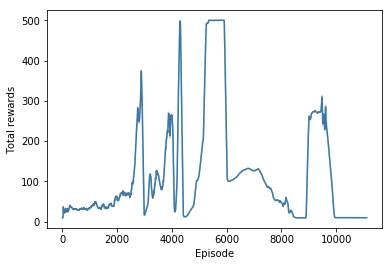

In [25]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

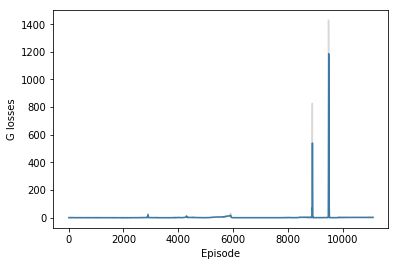

In [26]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

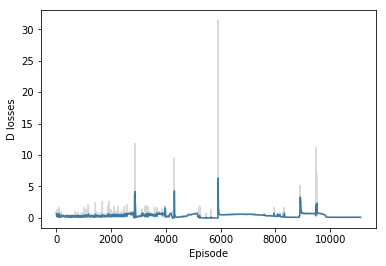

In [28]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [108]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.